# 2024-01-26 23 - Tables and plots for paper January.ipynb
Refactor of notebook 15.

## Parameters

In [1]:
EXPERIMENT_FOLDER_NAME='dev_icml_e16_17'
FIGURES_FOLDER=f'../figures/{EXPERIMENT_FOLDER_NAME}'

## Libraries and setup

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

In [5]:
from utils import wandb_utils

In [6]:
# Creating necessary folders
if not os.path.exists(FIGURES_FOLDER):
    os.makedirs(FIGURES_FOLDER, exist_ok=True)

## Data Download

In [7]:
df = wandb_utils.get_experiment_data("Autoformer","alelab",experiment_tags=[
    "e16_finaljan_allerm_replicated",
    "e17_finaljan_constant_constrained_replicated",
])
raw_df = df.copy() #as backup

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
100%|██████████| 239/239 [00:42<00:00,  5.61it/s]


Fetched 239 runs
Total records: (241344, 81)
Total runs: 239


In [8]:
#TODO deleteme
df = df[df.seed==2021].copy()
df.run_id.nunique()

191

## Data processing
This section contains processing specific to this experiment set. If you clone this notebook. Remove or refactor this section.

### Fixing the missing run issue ((NONREUSABLE))
Sweep `4o2frr5s` has a missing run because of duplicate constraints. Duplicate run `tyvbd19a` that has constraint 0.16   it to not run into issues.

In [9]:
if "cloned_run" not in df.run_id.unique():
    cloned_rows = df.query("run_id== 'tyvbd19a'").copy()
    cloned_rows["run_id"] = "cloned_run"
    cloned_rows.constraint_level = 0.159
    df = df.append(cloned_rows)
else: 
    print("Already cloned run")
# Sanity check
df.query('constraint_type =="constant" and model=="Reformer"').groupby(['data_path','model','pred_len','constraint_type'])['run_id'].nunique().reset_index()

data_path     model  pred_len constraint_type  run_id
0     electricity.csv  Reformer        96        constant       3
1     electricity.csv  Reformer       192        constant       3
2     electricity.csv  Reformer       336        constant       3
3     electricity.csv  Reformer       720        constant       3
4   exchange_rate.csv  Reformer        96        constant       3
5   exchange_rate.csv  Reformer       192        constant       3
6   exchange_rate.csv  Reformer       336        constant       3
7   exchange_rate.csv  Reformer       720        constant       3
8         weather.csv  Reformer        96        constant       3
9         weather.csv  Reformer       192        constant       3
10        weather.csv  Reformer       336        constant       3
11        weather.csv  Reformer       720        constant       3

### Label constraint_levels (`constraint_idx` column)
useful for joining when the constraint values are different for each model.

In [10]:
# There are three constraint levels per run, add a rank column, sorted by constraint level.
df=df.copy()#df_constrained.copy()
#display(df[['seed','data_path','model','pred_len','constraint_level']].drop_duplicates().sort_values(['data_path','model','pred_len','constraint_level']).head())
df.loc[df.constraint_type=='constant','constraint_idx'] = df.query('constraint_type=="constant"').groupby(['seed','data_path','model','pred_len'])['constraint_level'].rank(method='dense', ascending=True).astype(int)
df.loc[df.constraint_type=='erm','constraint_idx'] = 0
df['constraint_idx'] = df['constraint_idx'].astype(int)
ranked_constraint_levels_summary = df[['run_id','data_path','model','pred_len','constraint_type','constraint_level','constraint_idx']].drop_duplicates('run_id').sort_values(['data_path','model','pred_len','constraint_level'])
print("Sanity checking on the summary")
ranked_constraint_levels_summary

Sanity checking on the summary


run_id        data_path        model  pred_len constraint_type  \
224928  uglzgsuo  electricity.csv   Autoformer        96             erm   
142560  idtz7hic  electricity.csv   Autoformer        96        constant   
142272  c4z5umai  electricity.csv   Autoformer        96        constant   
141984  tickbccb  electricity.csv   Autoformer        96        constant   
224352  j30xdff9  electricity.csv   Autoformer       192             erm   
...          ...              ...          ...       ...             ...   
149328  g8i7mdgr      weather.csv  Transformer       336        constant   
225216  2ldijjak      weather.csv  Transformer       720             erm   
147168  2cq0ycz9      weather.csv  Transformer       720        constant   
145008  lk945020      weather.csv  Transformer       720        constant   
142848  ossb6hui      weather.csv  Transformer       720        constant   

        constraint_level  constraint_idx  
224928            -1.000               0  
142560             0.113               1  
142272             0.117               2  
141984             0.120               3  
224352            -1.000               0  
...                  ...             ...  
149328             0.198               3  
225216            -1.000               0  
147168             0.213               1  
145008             0.215               2  
142848             0.216               3  

[192 rows x 7 columns]

### Broadcast ERM runs with constraint levels (`df_to_plot`)
to compare ERM with constrained, we need every ERM run repeated to pair it with a constrained run.

In [11]:
df_constrained = df.query('type=="Constrained"').copy()
df_erm = df.query('type=="ERM"').copy()
#(data_path,model,pred_len,constraint_level,constrained_unconstraled)
distinct_constraints = df_constrained[['data_path','model','pred_len','constraint_level']].drop_duplicates()

# crossjoin the ERM mse to all constraint levels
df_erm_w_broadcasted_constraint_levels = df_erm.drop(columns=['constraint_level']).merge(distinct_constraints,on=['data_path','model','pred_len'],how='left')
df_to_plot = pd.concat([df_constrained,df_erm_w_broadcasted_constraint_levels],axis=0)

# sanity check
display(df_erm_w_broadcasted_constraint_levels.shape)
print(f"Three constraints per experiment, broadcasted dataset size be equal to {df_erm.shape[0]*3}")
display(df_to_plot.shape)
print(f"Final dataset size should be equal to {df_constrained.shape[0]+df_erm.shape[0]*3}")

(145152, 82)

Three constraints per experiment, broadcasted dataset size be equal to 145152


(290304, 82)

Final dataset size should be equal to 290304


### Add constraint violation metric

In [12]:
# Adding the constraint violation column
df_to_plot["constraint_violation"] = (df_to_plot.mse-df_to_plot.constraint_level).clip(lower=0)
df_to_plot['is_infeasible'] = (df_to_plot.constraint_violation>0)*1

# sanity check
dd=df_to_plot[['run_id','model','type','step','mse','constraint_level','constraint_violation','is_infeasible']] 
print("For ERM")
display(dd.query('type=="ERM"').query('constraint_violation>0').head())
print("For Constrained")
display(dd.query('type=="Constrained"').query('constraint_violation>0').head())


For ERM


run_id        model type  step       mse  constraint_level  \
0  k6rl9exh  Transformer  ERM     0  0.095688             0.049   
1  k6rl9exh  Transformer  ERM     0  0.095688             0.051   
2  k6rl9exh  Transformer  ERM     0  0.095688             0.048   
3  k6rl9exh  Transformer  ERM     1  0.060131             0.049   
4  k6rl9exh  Transformer  ERM     1  0.060131             0.051   

   constraint_violation  is_infeasible  
0              0.046688              1  
1              0.044688              1  
2              0.047688              1  
3              0.011131              1  
4              0.009131              1

For Constrained


run_id        model         type  step       mse  constraint_level  \
48384  19itl0ri  Transformer  Constrained     0  0.087145             0.049   
48385  19itl0ri  Transformer  Constrained     1  0.058463             0.049   
48386  19itl0ri  Transformer  Constrained     2  0.056598             0.049   
48387  19itl0ri  Transformer  Constrained     3  0.056623             0.049   
48388  19itl0ri  Transformer  Constrained     4  0.056638             0.049   

       constraint_violation  is_infeasible  
48384              0.038145              1  
48385              0.009463              1  
48386              0.007598              1  
48387              0.007623              1  
48388              0.007638              1

### Summary metrics per run (unused)
Summarize all three runs into metrics per split by averaging mse and constraint levels.

In [13]:
# Calculate mean and std for mse and constraint_violation. Rename them mean_{metric} and std_{metric

summary_metrics_per_run = df_to_plot.groupby([
    "run_id",
    "Algorithm", #Harmless carryover col for legacy purposes (verified the counts are the same)
    "model",'type',"constraint_level","pred_len","data_path",
    "split"
    ])['mse','constraint_violation','infeasible_rate','run_id'].aggregate(
        mse=('mse','mean'),
        #std_mse=('mse','std'),
        mcv=('constraint_violation','mean'),
        #std_mcv=('constraint_violation','std'),
        mean_infeasible_rate=('infeasible_rate','mean'),
        #std_infeasible_rate=('infeasible_rate','std'),
        run_count=('run_id','nunique')
        ).reset_index().round(5)
summary_metrics = summary_metrics_per_run.groupby([
    "Algorithm", #Harmless carryover col for legacy purposes (verified the counts are the same)
    "model",'type',"constraint_level","pred_len","data_path",
    "split"]).aggregate(
        mse=('mse','mean'),
        std_mse=('mse','std'),
        mcv=('mcv','mean'),
        std_mcv=('mcv','std'),
        mean_infeasible_rate=('mean_infeasible_rate','mean'),
        std_infeasible_rate=('mean_infeasible_rate','std'),
        run_count=('run_count','mean')
    ).reset_index()
display(summary_metrics_per_run.shape)
display(summary_metrics.shape)
summary_metrics.head()

/home/jporras/miniconda3/envs/autoformer/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


(864, 12)

(864, 14)

Algorithm       model type  constraint_level  \
0  AllModels_electricity.csv Autoformer  Autoformer  ERM             0.113   
1  AllModels_electricity.csv Autoformer  Autoformer  ERM             0.113   
2  AllModels_electricity.csv Autoformer  Autoformer  ERM             0.113   
3  AllModels_electricity.csv Autoformer  Autoformer  ERM             0.117   
4  AllModels_electricity.csv Autoformer  Autoformer  ERM             0.117   

   pred_len        data_path  split      mse  std_mse      mcv  std_mcv  \
0        96  electricity.csv   test  0.20399      NaN  0.09099      NaN   
1        96  electricity.csv  train  0.11989      NaN  0.00696      NaN   
2        96  electricity.csv    val  0.16142      NaN  0.04842      NaN   
3        96  electricity.csv   test  0.20399      NaN  0.08699      NaN   
4        96  electricity.csv  train  0.11989      NaN  0.00448      NaN   

   mean_infeasible_rate  std_infeasible_rate  run_count  
0                   1.0                  NaN        1.0  
1                   1.0                  NaN        1.0  
2                   1.0                  NaN        1.0  
3                   1.0                  NaN        1.0  
4                   1.0                  NaN        1.0

**END OF PREPROCESSING**

---
---

## Plots

### ERM vs. Constrained on 50th percentile (one seed)
TO DO: Reproduce the ERM vs constrained per model for each window size. Try to unify into one plot if possible.

#### **ERM Vs Constrained 96 (split=train, constraint_idx=2)**

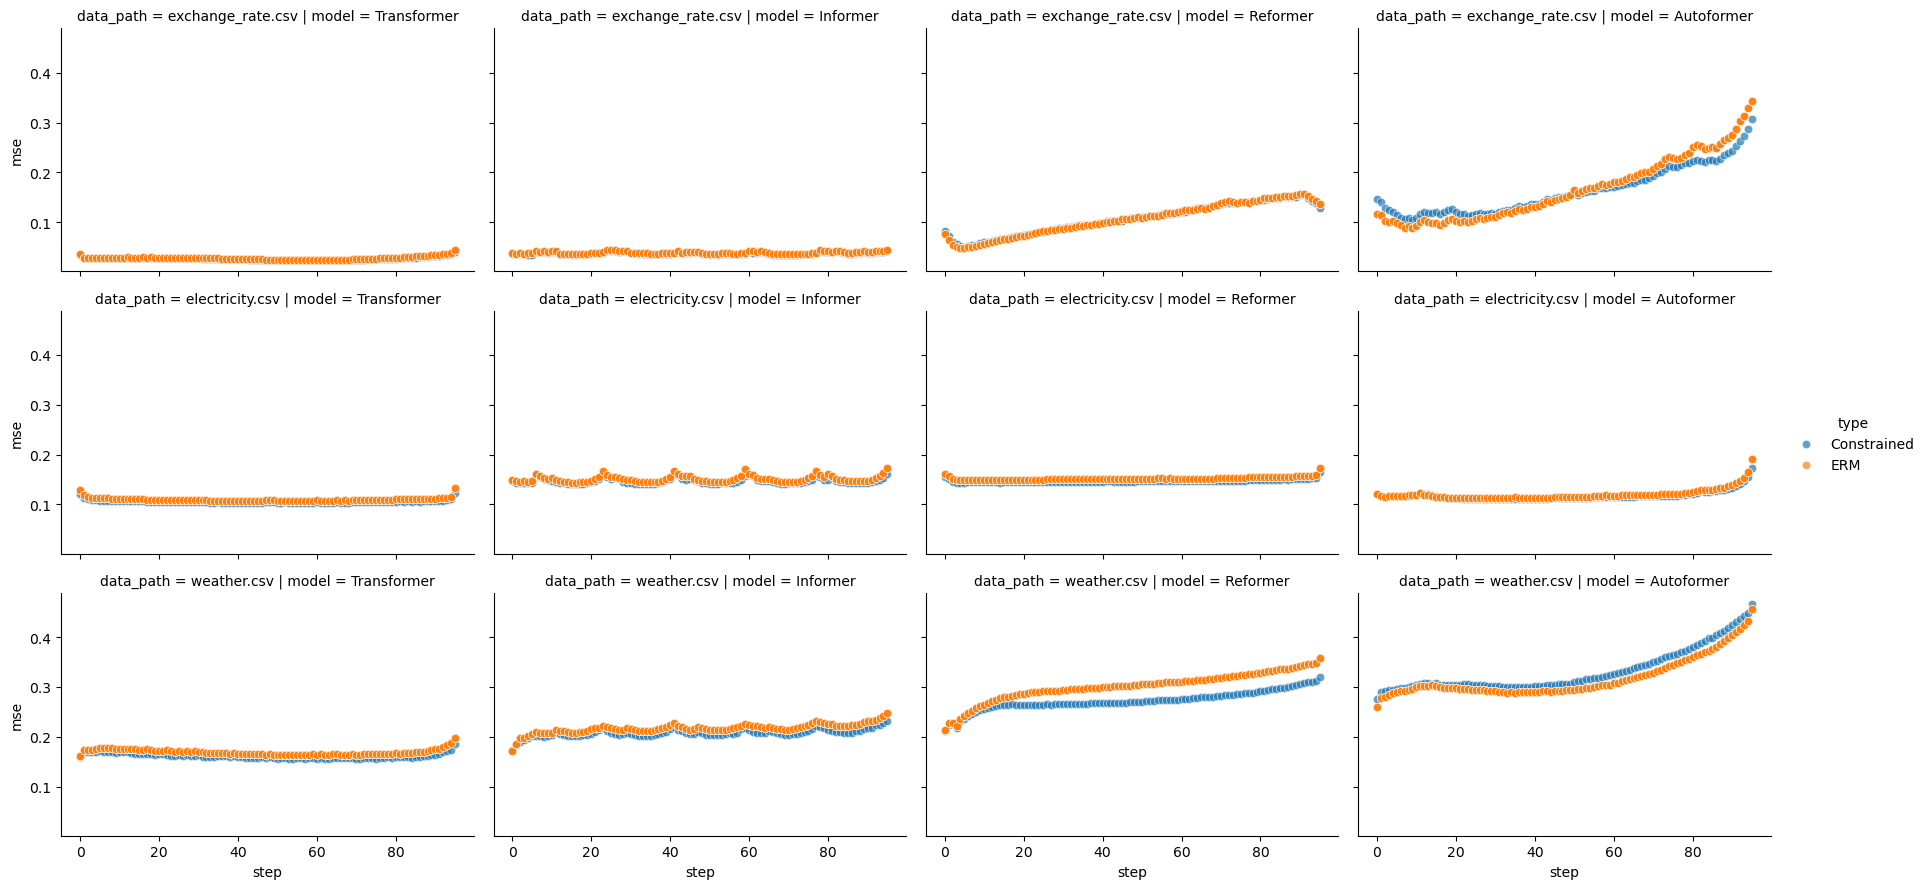

#### **ERM Vs Constrained 192 (split=train, constraint_idx=2)**

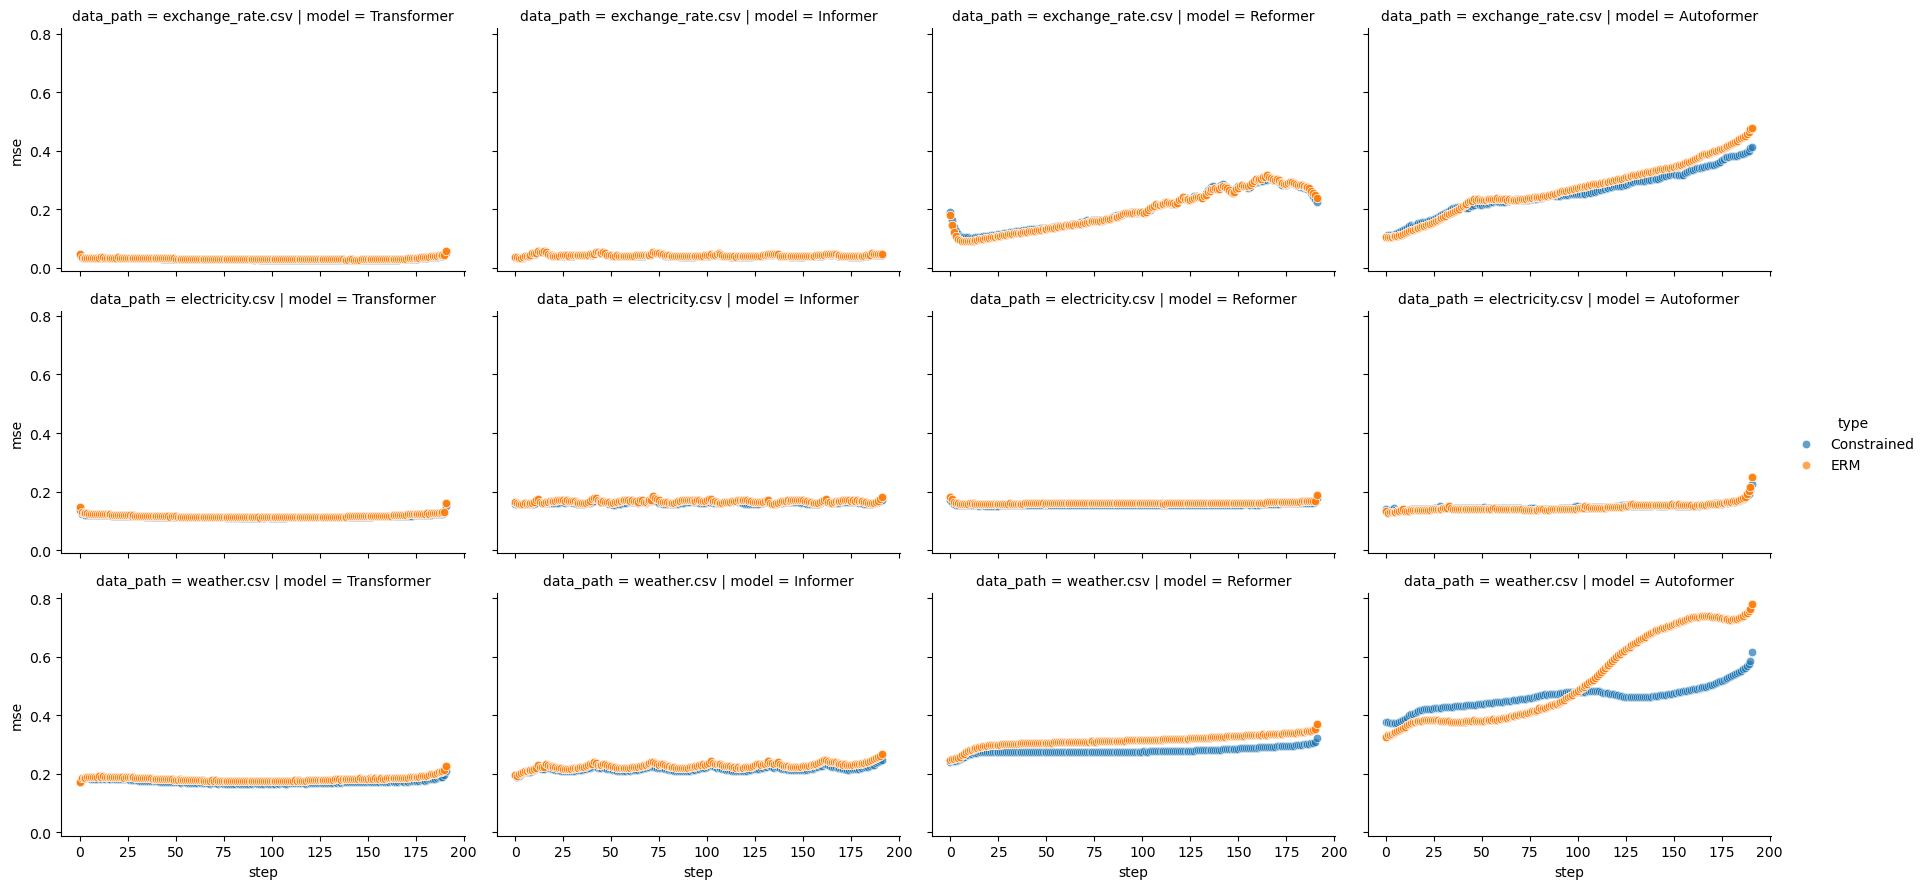

#### **ERM Vs Constrained 336 (split=train, constraint_idx=2)**

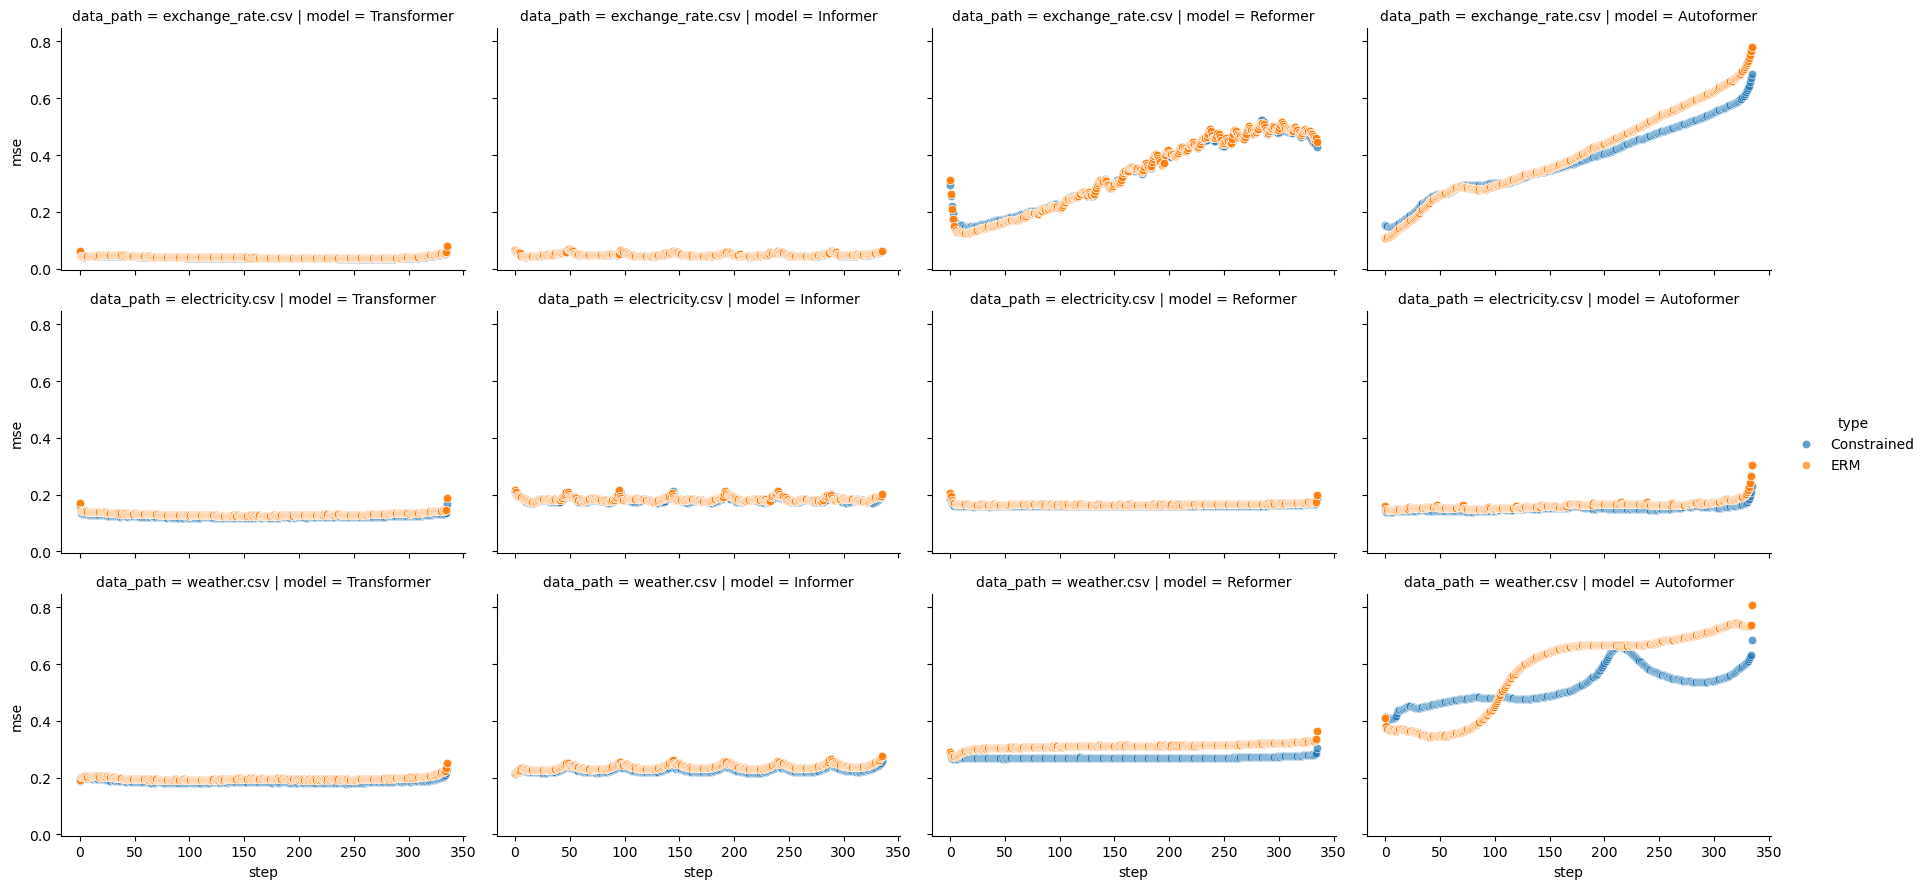

#### **ERM Vs Constrained 720 (split=train, constraint_idx=2)**

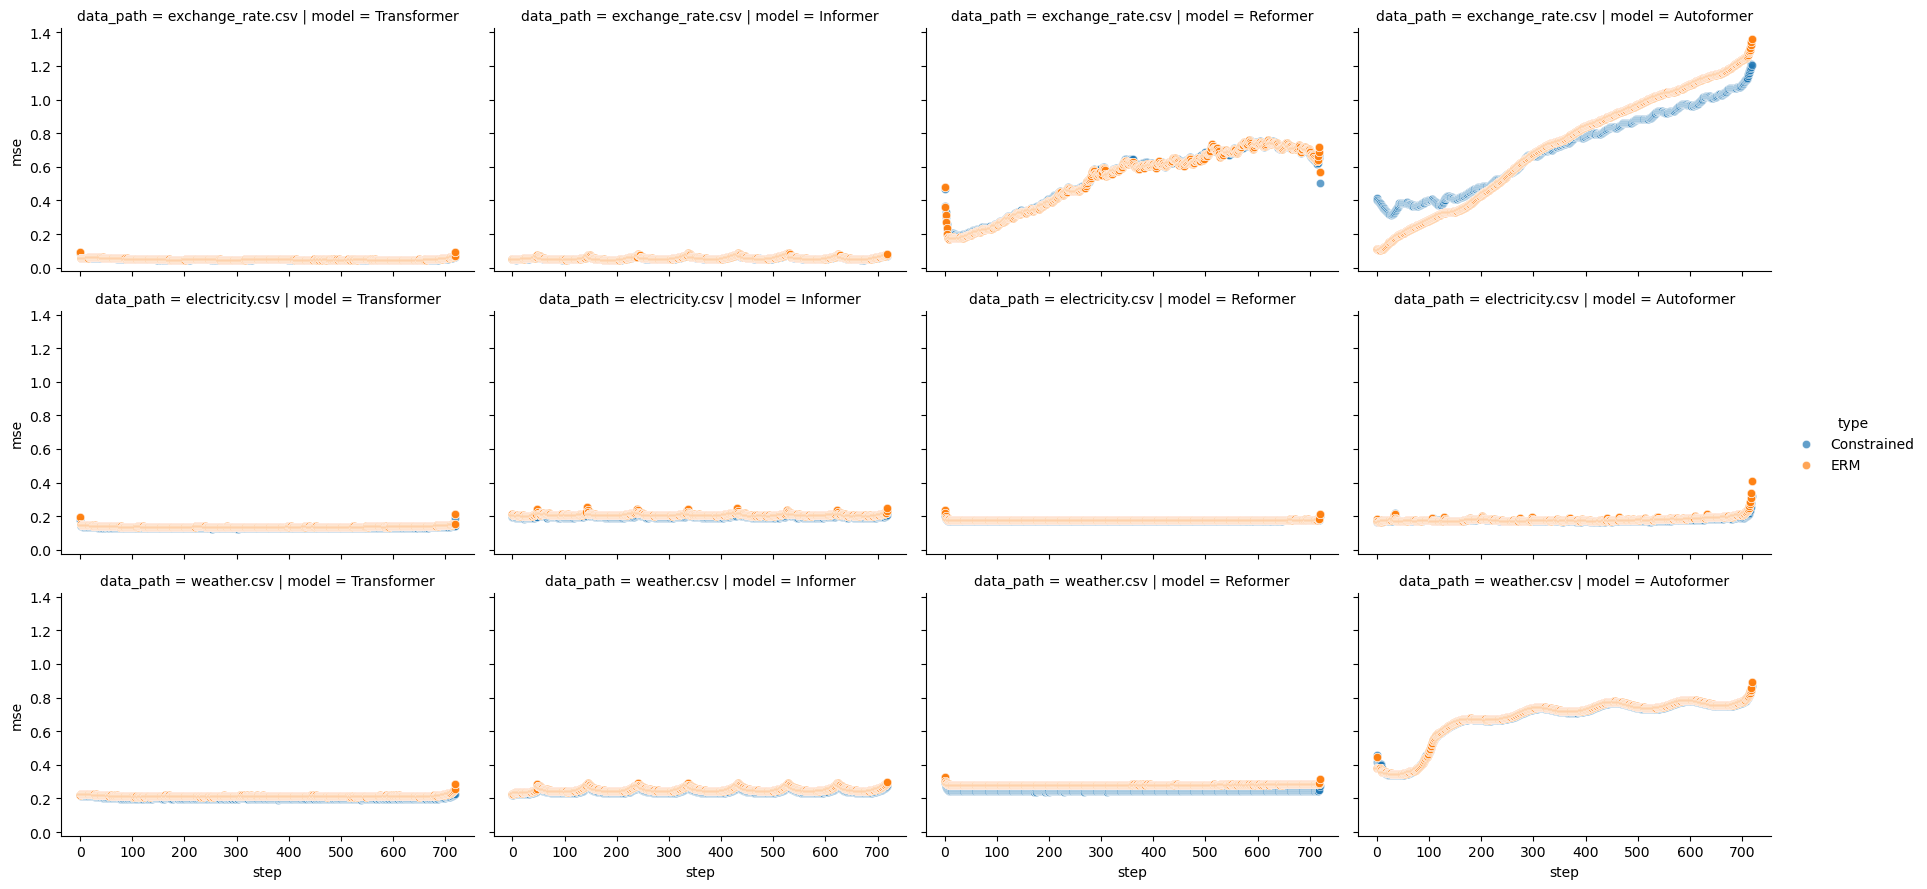

In [19]:
# PARAMS
split="train"
constraint_idx = 2 # use the 50 percentile constraint to plot 1=25,2=50,3=75
seed=2021

# Filter
df_pct50_and_erm = df_to_plot[(df_to_plot.constraint_idx.isin([0,constraint_idx])) & (df_to_plot.seed==seed) & (df_to_plot.split==split)].copy()

PRED_LENS=sorted(df_to_plot.pred_len.unique().tolist())
#PRED_LENS=[96]
for pred_len in PRED_LENS:
    # Add data for constant line
    df_current_plot = df_pct50_and_erm.query('pred_len==@pred_len').copy()
    #constraint_level = df_current_plot.constraint_level.unique()[0]
    #df_current_plot['constraint_level'] = constraint_level
    display(Markdown(f"#### **ERM Vs Constrained {pred_len} (split={split}, constraint_idx={constraint_idx})**"))

    g = sns.FacetGrid(df_current_plot, col='model', row='data_path', hue='type', height=3, aspect=1.5, legend_out=True)
    #g.map(sns.lineplot, "step", "constraint_level", alpha=.7)
    g.map(sns.scatterplot, "step", "mse", alpha=.7)
    g.add_legend()
    #g.savefig(f"{FIGURES_FOLDER}/constrained_vs_erm_{pred_len}_{str(constraint_level).replace('.','')}.png")
    plt.show()

### Multipliers over the window

#### **Multipliers vs loss 96 (split=train, constraint_idx=2)**

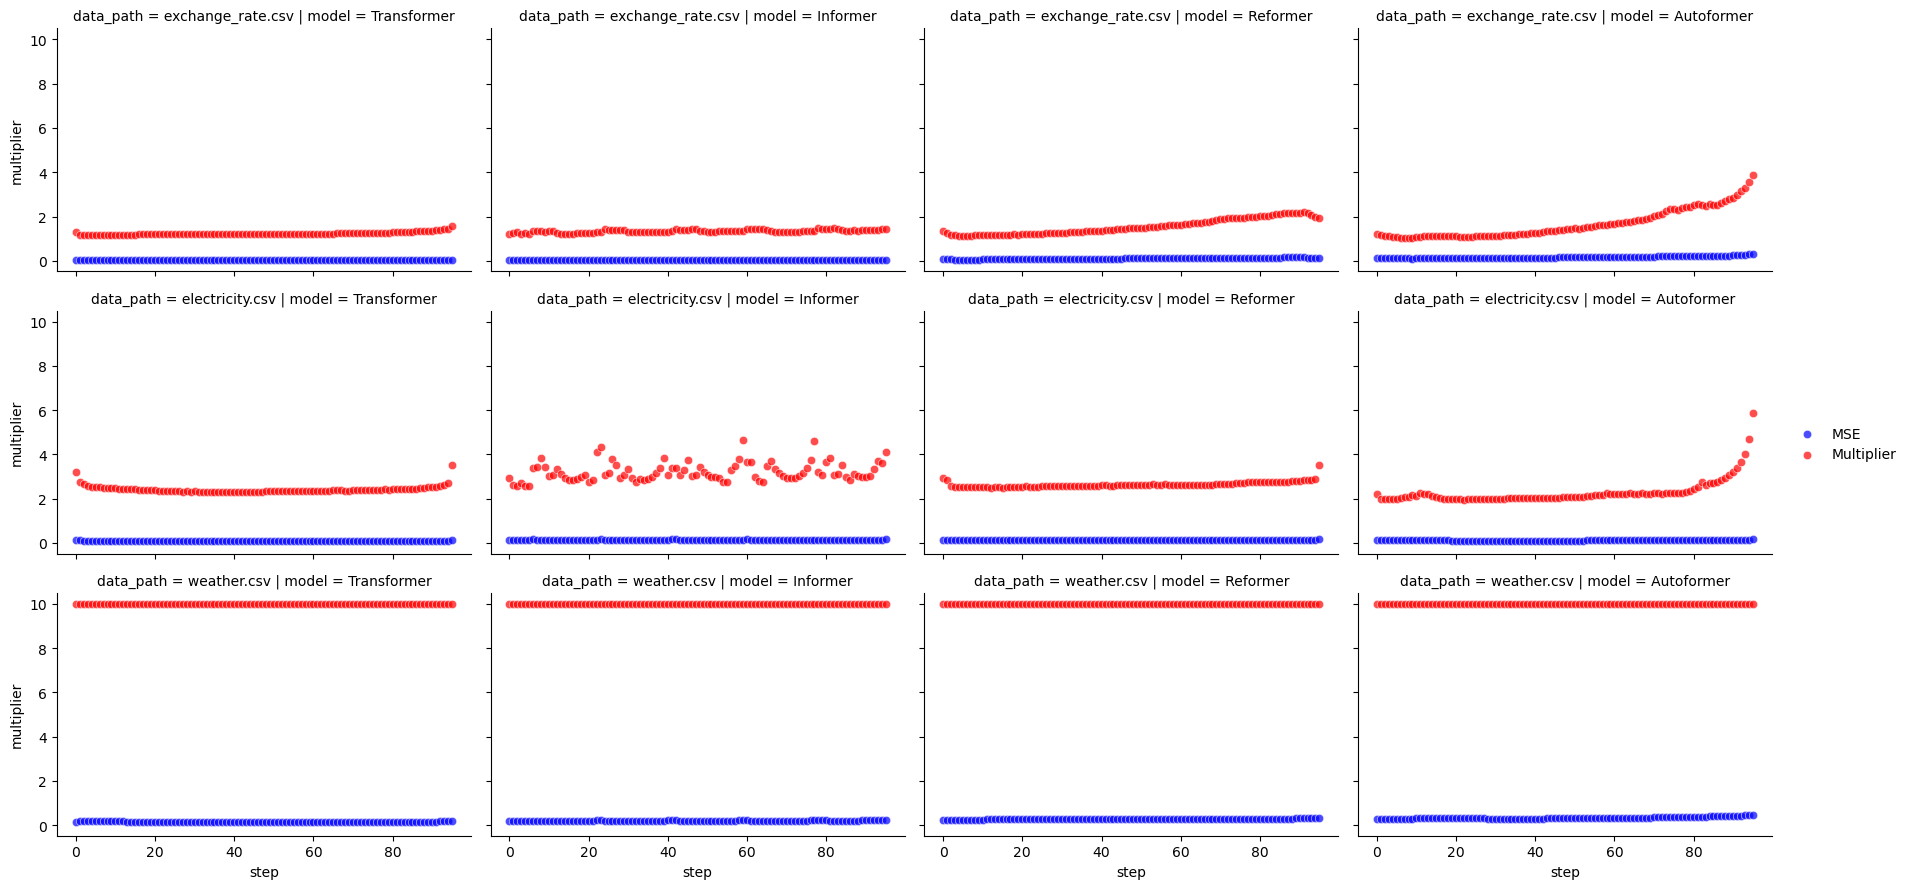

#### **Multipliers vs loss 192 (split=train, constraint_idx=2)**

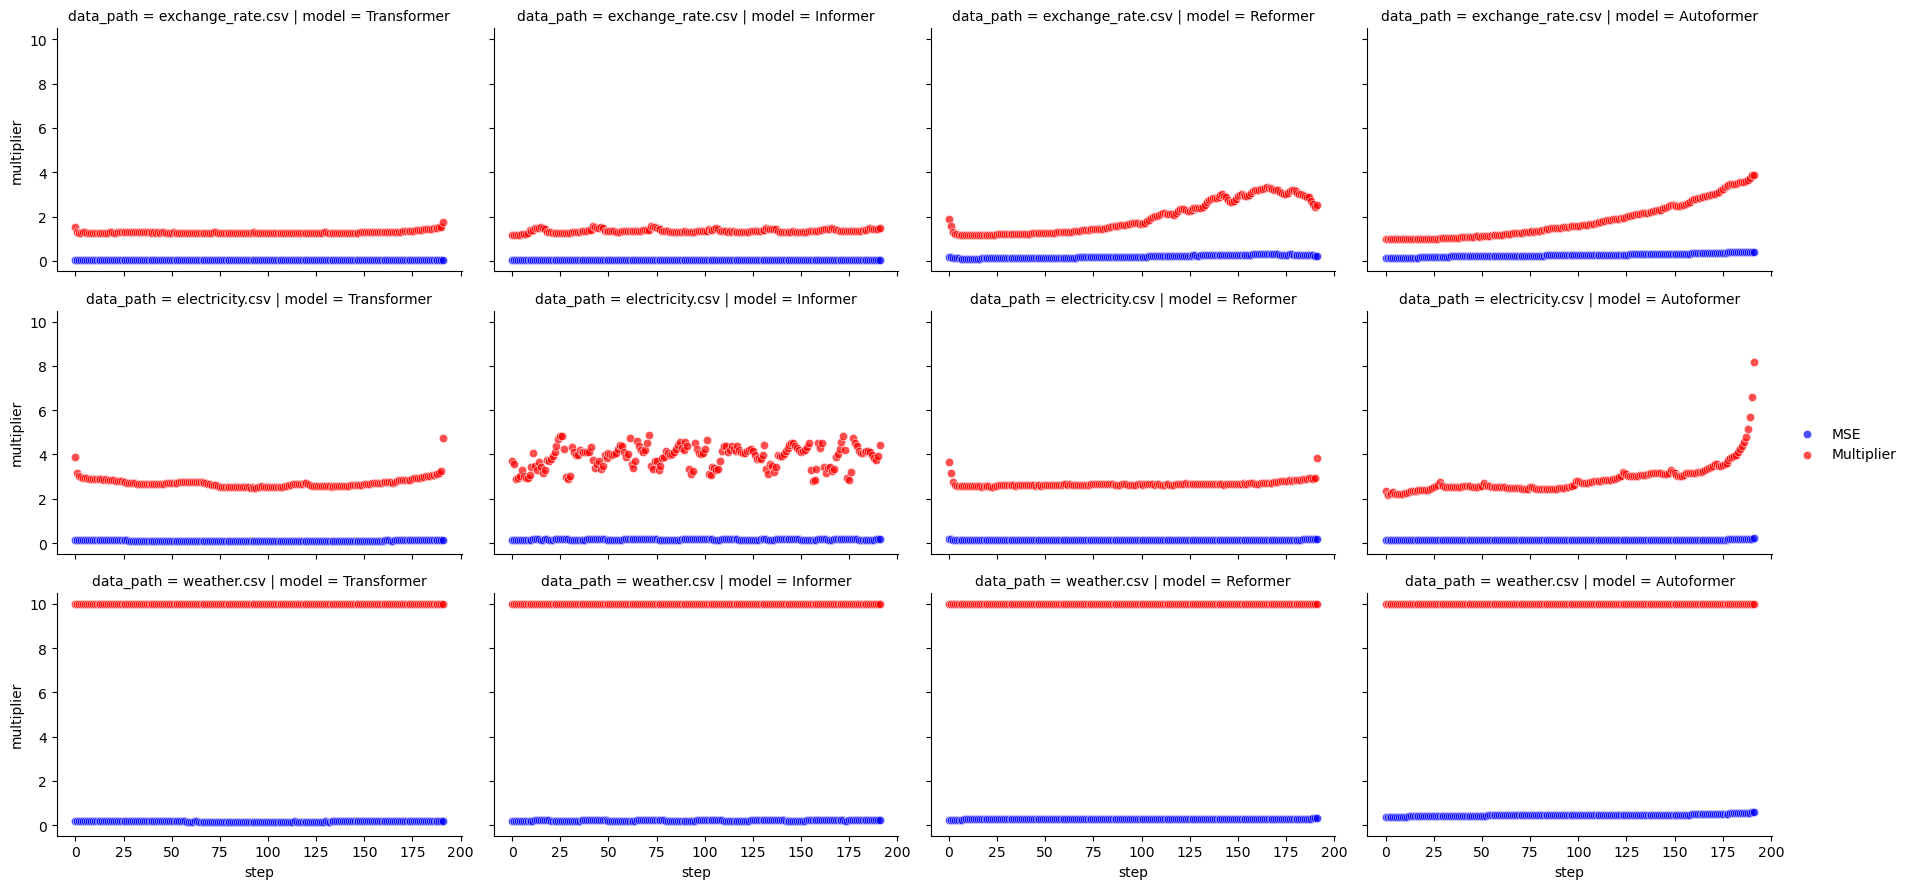

#### **Multipliers vs loss 336 (split=train, constraint_idx=2)**

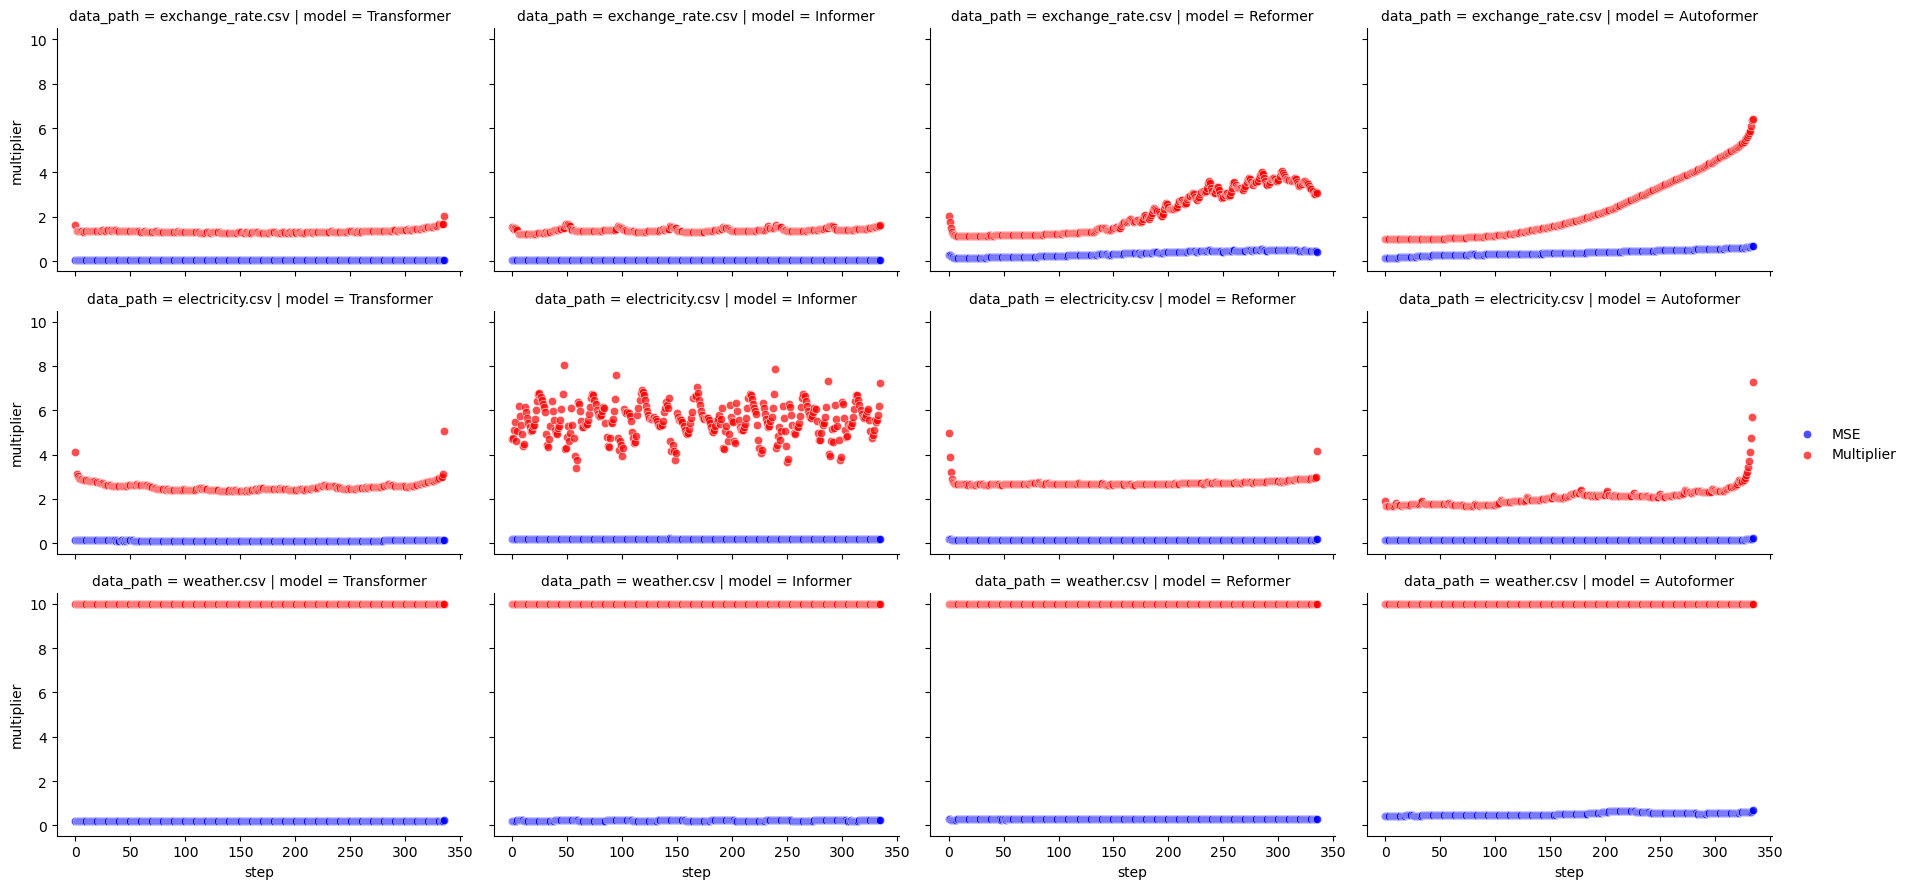

#### **Multipliers vs loss 720 (split=train, constraint_idx=2)**

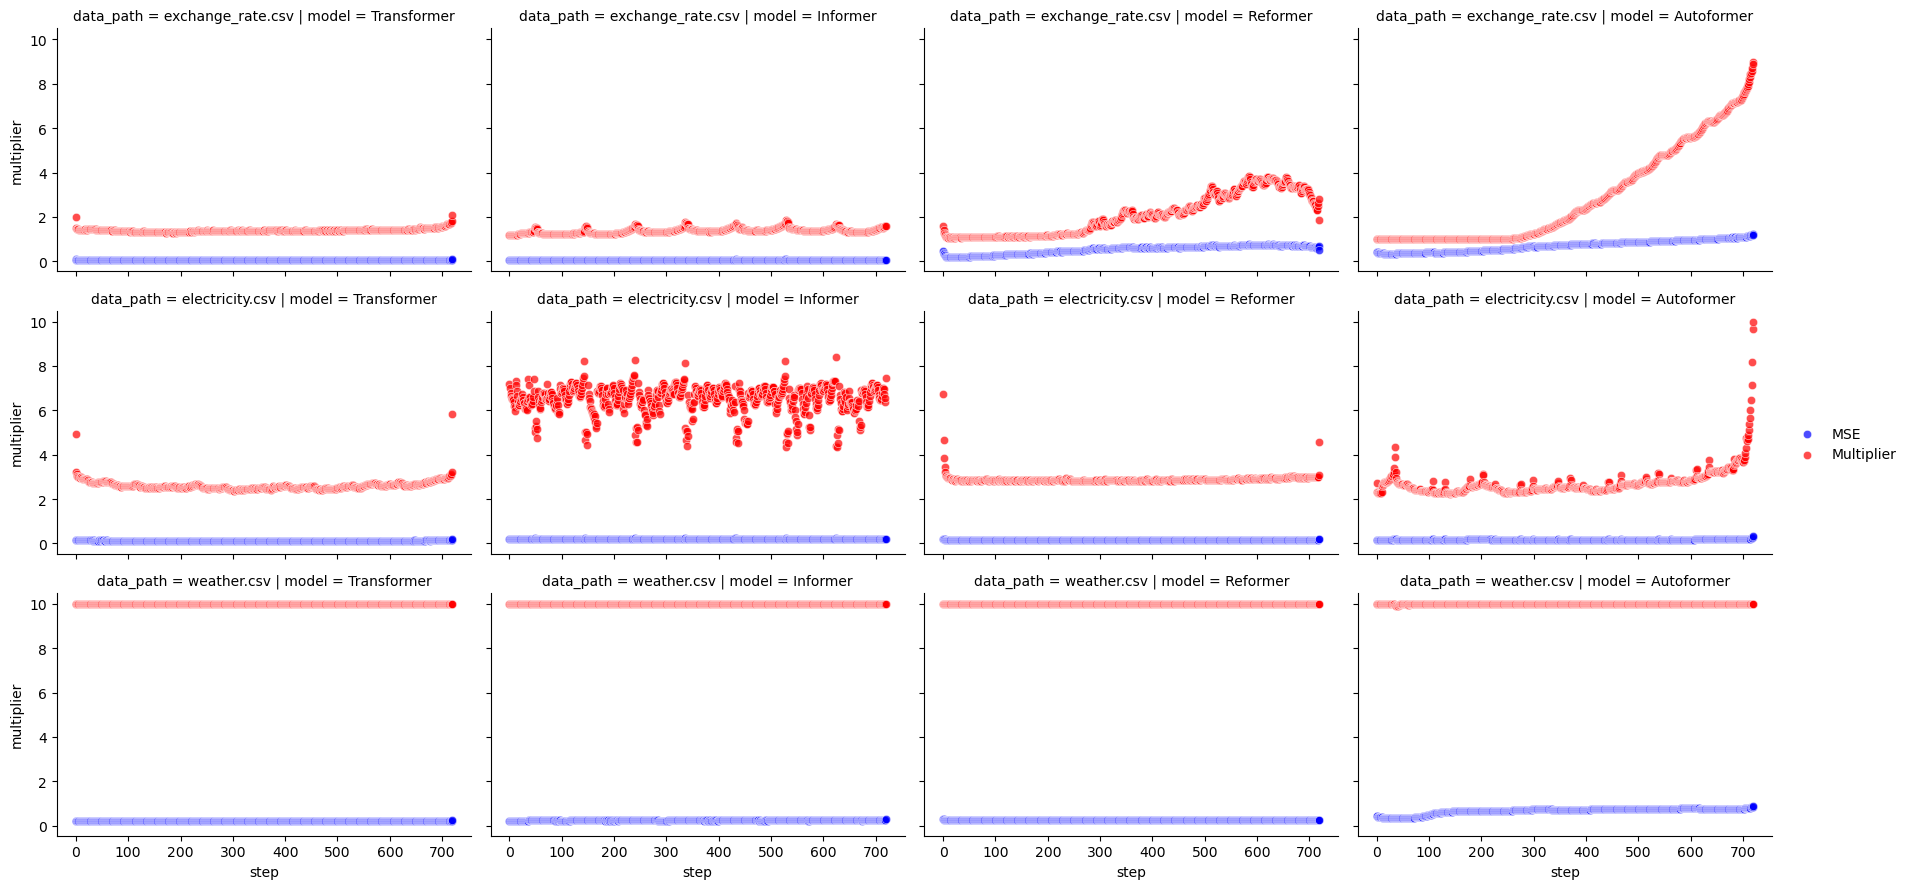

In [17]:
# PARAMS
split="train"
constraint_idx = 2 # use the 50 percentile constraint to plot 1=25,2=50,3=75
seed=2021

# Filter
df_pct50 = df_to_plot[
    (df_to_plot.constraint_idx.isin([0,constraint_idx])) 
    & (df_to_plot.seed==seed) & (df_to_plot.split==split)
    & (df_to_plot.constraint_type=="constant")
    ].copy()

PRED_LENS=sorted(df_to_plot.pred_len.unique().tolist())
#PRED_LENS=[96]
for pred_len in PRED_LENS:
    # Add data for constant line
    df_current_plot = df_pct50.query('pred_len==@pred_len').copy()
    #constraint_level = df_current_plot.constraint_level.unique()[0]
    #df_current_plot['constraint_level'] = constraint_level
    display(Markdown(f"#### **Multipliers vs loss {pred_len} (split={split}, constraint_idx={constraint_idx})**"))

    g = sns.FacetGrid(df_current_plot, col='model', row='data_path', height=3, aspect=1.5, legend_out=True)
    # Plot multipliers and MSEs
    g.map(sns.scatterplot, "step", "mse", alpha=.7,color='blue',label='MSE')
    g.map(sns.scatterplot, "step", "multiplier", alpha=.7,color='red',label='Multiplier')
    # Add legend the series

    g.add_legend()
    #g.savefig(f"{FIGURES_FOLDER}/constrained_vs_erm_{pred_len}_{str(constraint_level).replace('.','')}.png")
    plt.show()

### Multipliers over training

In [248]:
import wandb #todo move up
from tqdm import tqdm
sample_run = "hrngi6tk"
pred_len=192
api = wandb.Api()
run = api.run(f"alelab/Autoformer/{sample_run}")
# Get the history of multiplier/0
multiplier_histories=[]
for i in tqdm(range(pred_len)):
    multiplier_histories.append(run.history(keys=[f'multiplier/{i}']))

  0%|          | 0/192 [00:00<?, ?it/s]

100%|██████████| 192/192 [01:24<00:00,  2.27it/s]


In [263]:
# merge all of the DFs in multiplier_histories on _step
multiplier_hist_df = multiplier_histories[0]
for i in range(1,len(multiplier_histories)):
    multiplier_hist_df = multiplier_hist_df.merge(multiplier_histories[i],on='_step')

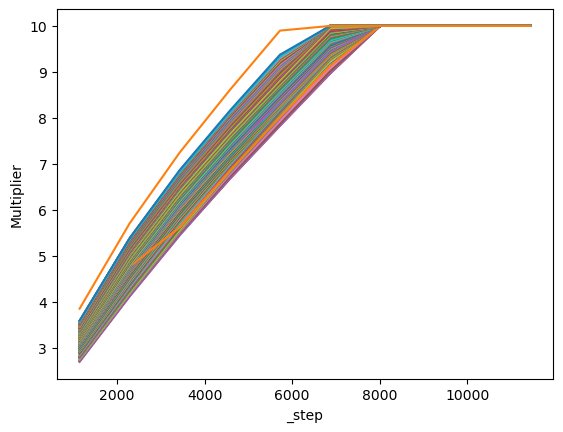

In [264]:
# Plot all multiplier columns as a line plot
for i in range(pred_len):
    #plt.plot(df[f'multiplier/{i}'])
    sns.lineplot(data=multiplier_hist_df,x='_step',y=f'multiplier/{i}')
plt.ylabel("Multiplier")
plt.show()

#### (Dev) Debugging Why are the multipliers blowing up if it's mostly feasible.

In [293]:
df_dd=df_to_plot.query("run_id=='hrngi6tk' and constraint_type=='constant' and split=='train'").copy()
pd.set_option('display.max_rows', 500)
#df_dd[['multiplier','mse','constraint_level','constraint_violation','is_infeasible']]
df_dd[['multiplier','mse','constraint_level','constraint_violation','is_infeasible']].query('constraint_violation >0')

multiplier      mse  constraint_level  constraint_violation  \
159743        10.0  0.32363             0.315               0.00863   

        is_infeasible  
159743              1

### (old) ERM vs constrained

[0.11  0.109 0.107 0.155 0.149 0.146 0.153 0.151 0.15  0.12  0.117 0.113]


### Dataset: electricity.csv pred_len: 96 constraint_level: 0.11

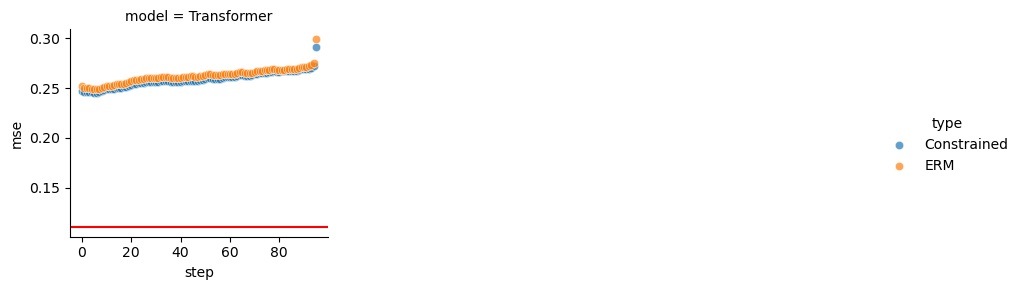

### Dataset: electricity.csv pred_len: 96 constraint_level: 0.109

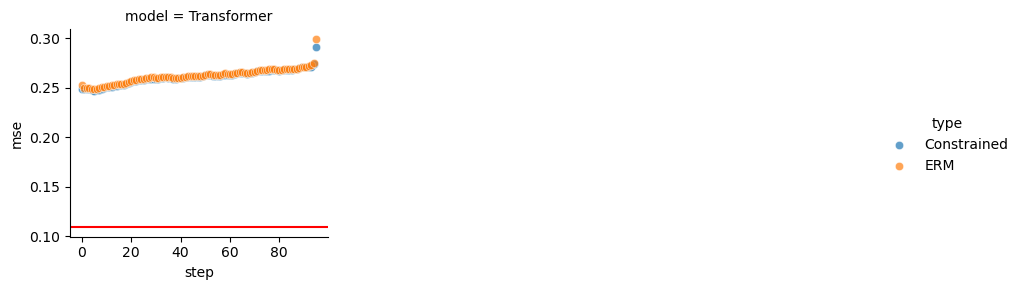

### Dataset: electricity.csv pred_len: 96 constraint_level: 0.107

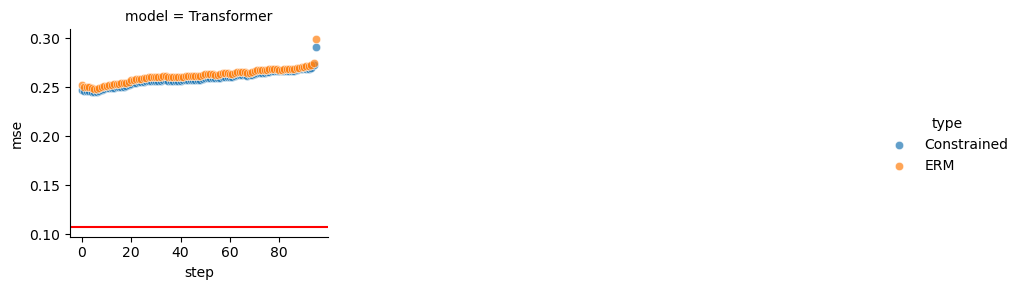

### Dataset: electricity.csv pred_len: 96 constraint_level: 0.155

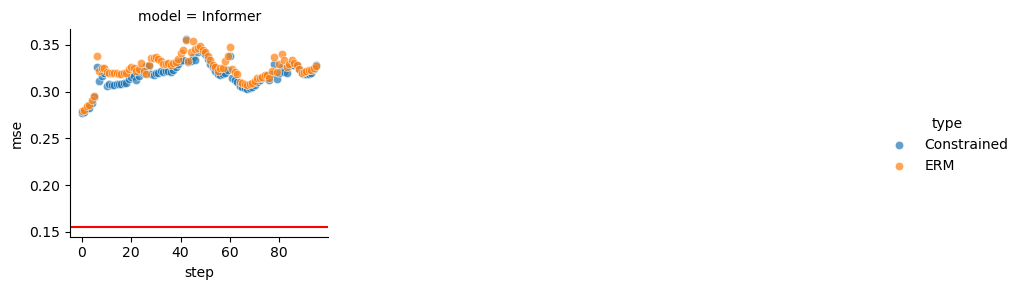

### Dataset: electricity.csv pred_len: 96 constraint_level: 0.149

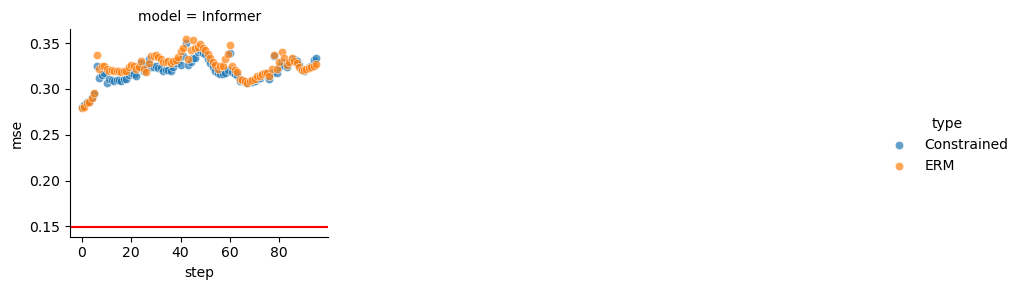

### Dataset: electricity.csv pred_len: 96 constraint_level: 0.146

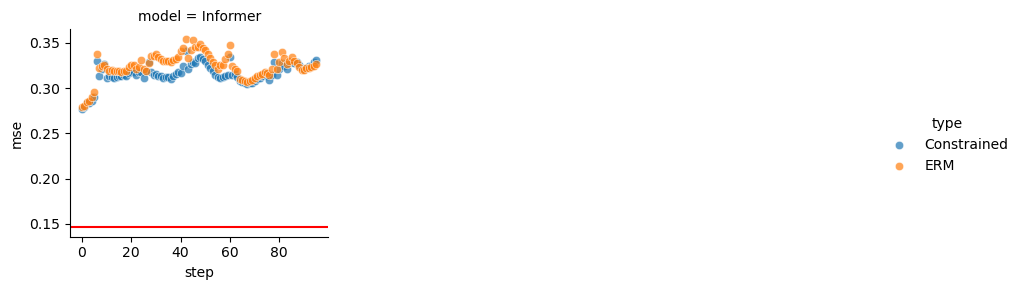

### Dataset: electricity.csv pred_len: 96 constraint_level: 0.153

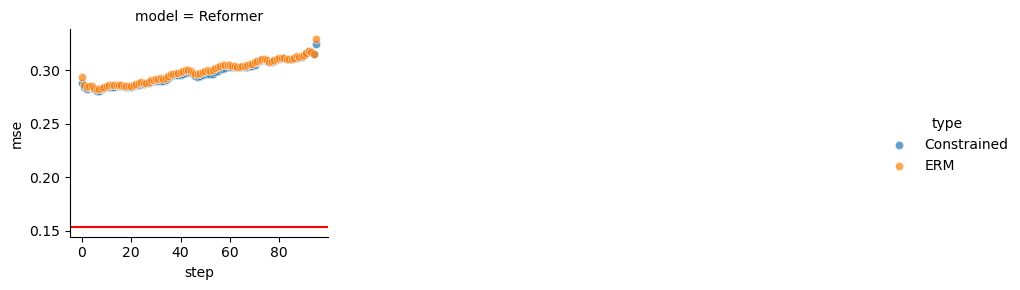

### Dataset: electricity.csv pred_len: 96 constraint_level: 0.151

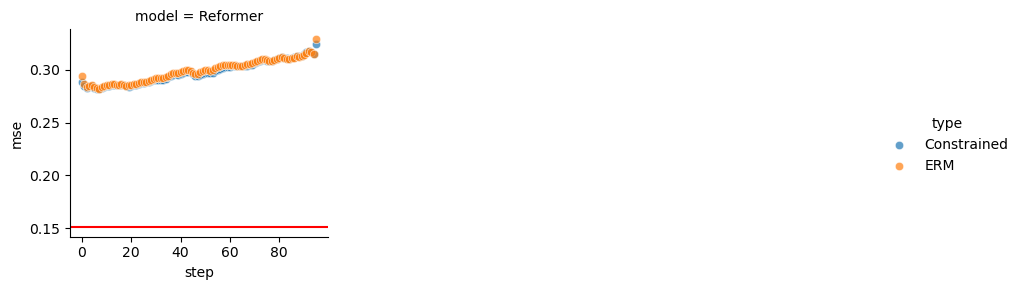

### Dataset: electricity.csv pred_len: 96 constraint_level: 0.15

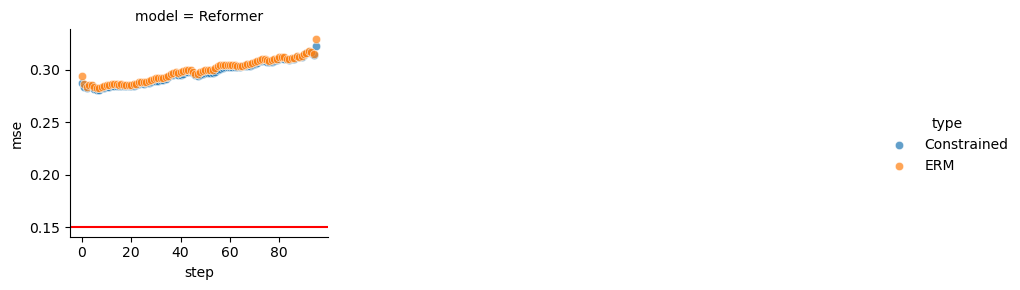

### Dataset: electricity.csv pred_len: 96 constraint_level: 0.12

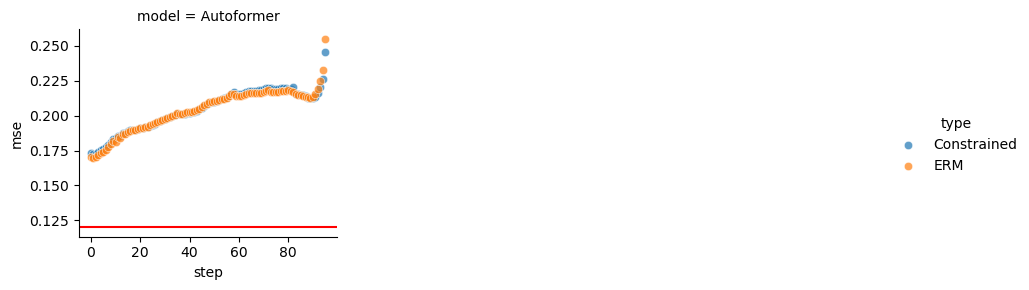

### Dataset: electricity.csv pred_len: 96 constraint_level: 0.117

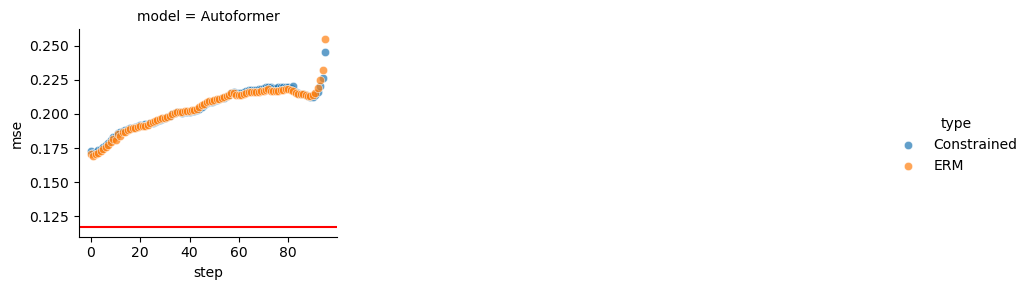

### Dataset: electricity.csv pred_len: 96 constraint_level: 0.113

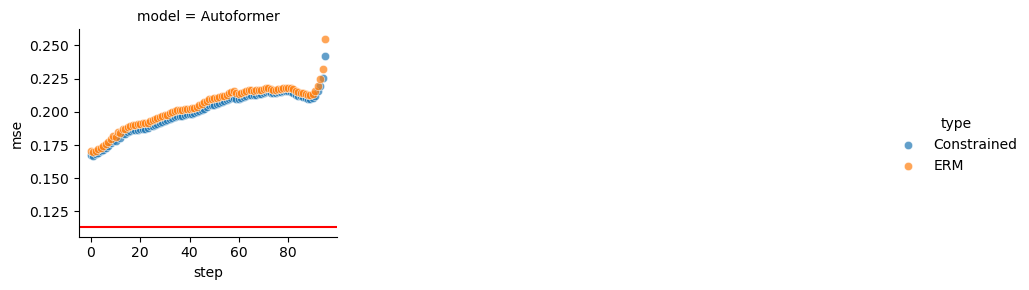

[0.12  0.115 0.113 0.17  0.168 0.164 0.161 0.16  0.154 0.143 0.14  0.159]


### Dataset: electricity.csv pred_len: 192 constraint_level: 0.12

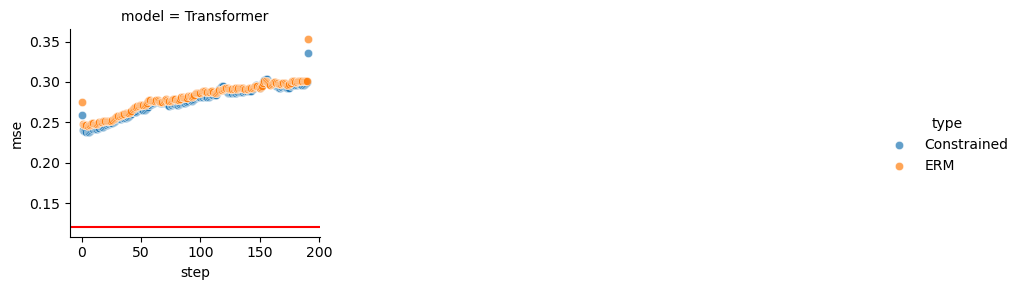

### Dataset: electricity.csv pred_len: 192 constraint_level: 0.115

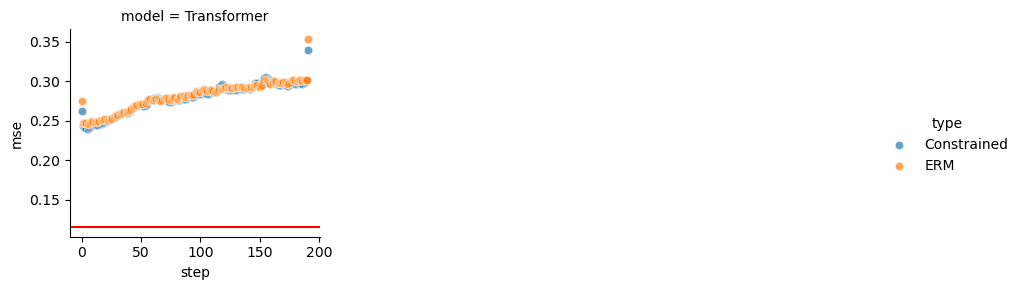

### Dataset: electricity.csv pred_len: 192 constraint_level: 0.113

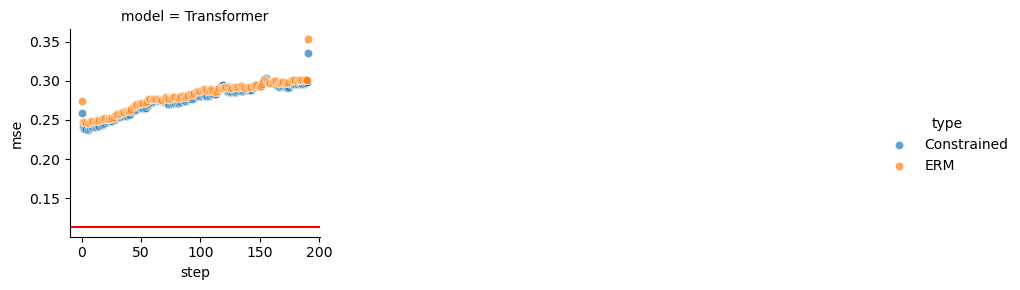

### Dataset: electricity.csv pred_len: 192 constraint_level: 0.17

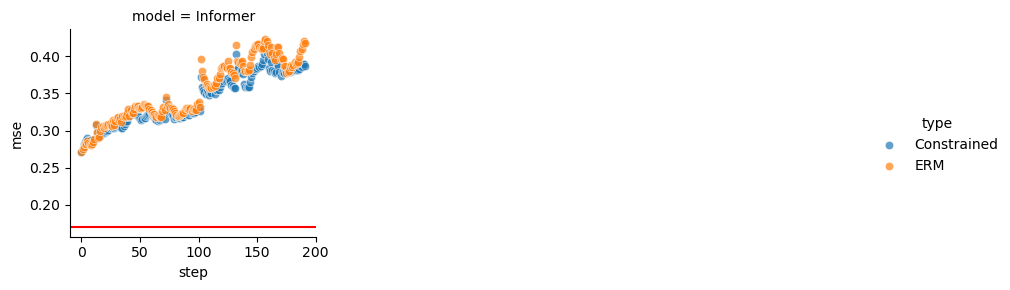

### Dataset: electricity.csv pred_len: 192 constraint_level: 0.168

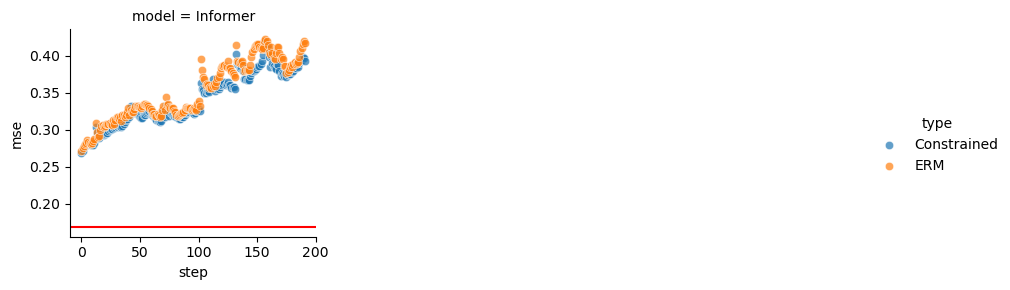

### Dataset: electricity.csv pred_len: 192 constraint_level: 0.164

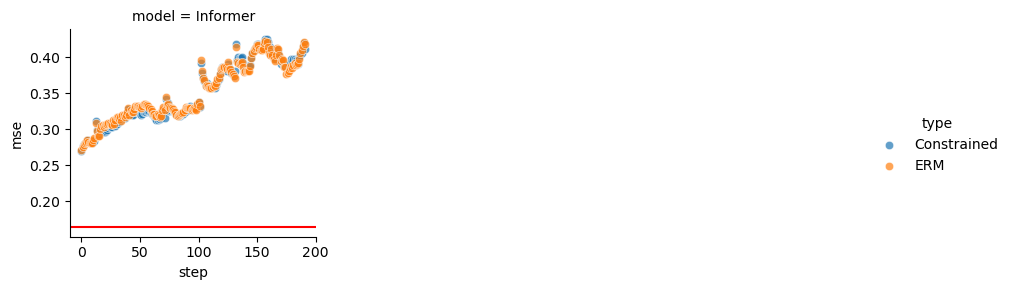

### Dataset: electricity.csv pred_len: 192 constraint_level: 0.161

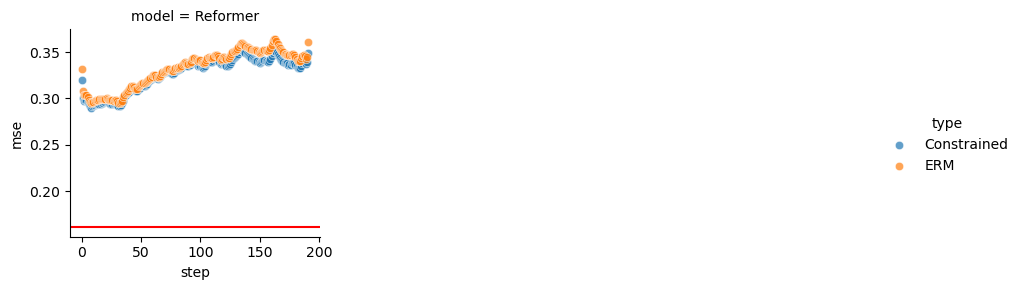

### Dataset: electricity.csv pred_len: 192 constraint_level: 0.16

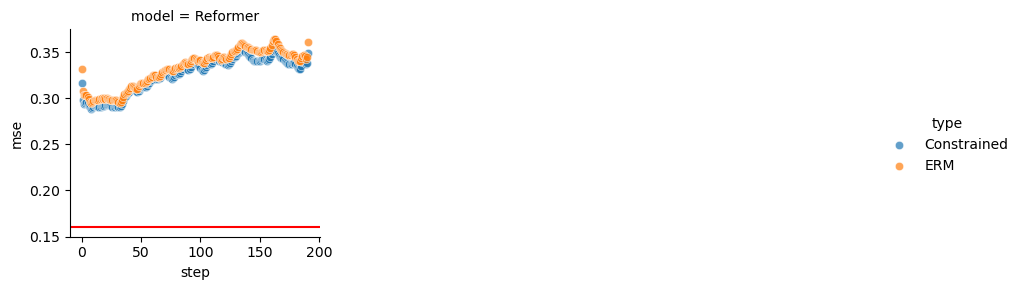

### Dataset: electricity.csv pred_len: 192 constraint_level: 0.154

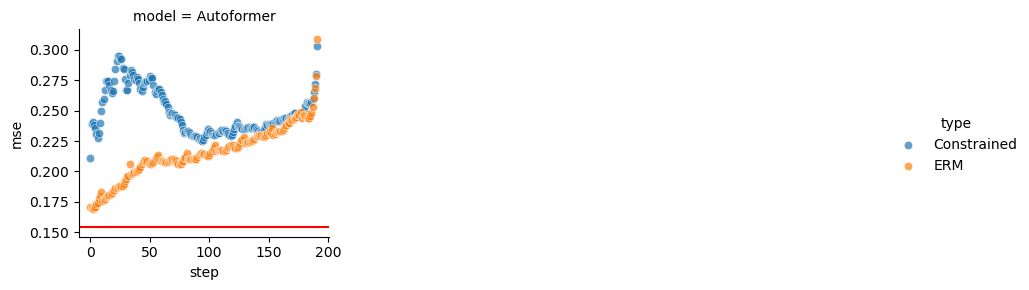

### Dataset: electricity.csv pred_len: 192 constraint_level: 0.143

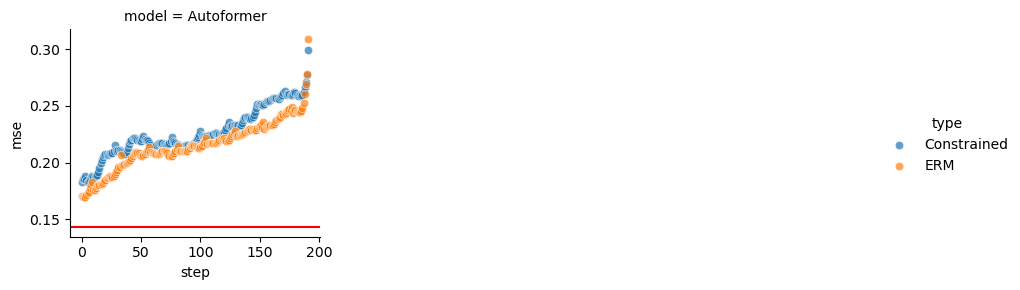

### Dataset: electricity.csv pred_len: 192 constraint_level: 0.14

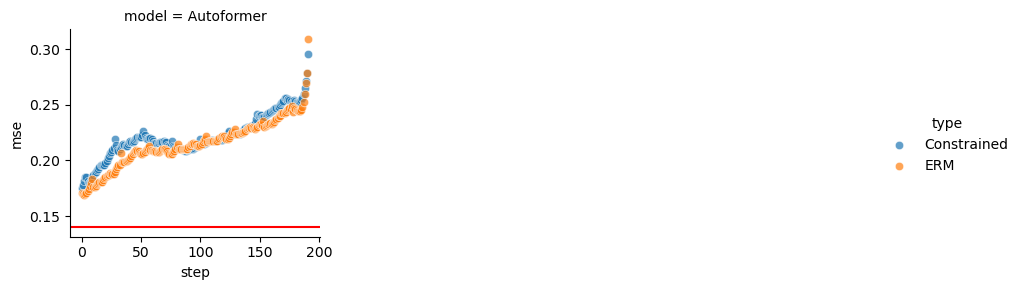

### Dataset: electricity.csv pred_len: 192 constraint_level: 0.159

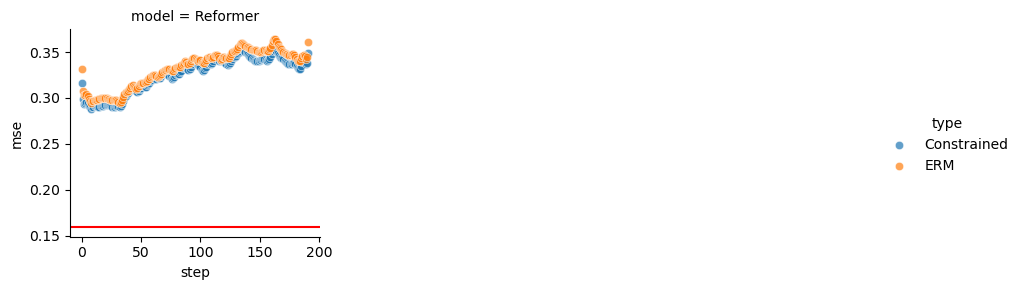

[0.134 0.13  0.127 0.189 0.184 0.18  0.167 0.166 0.165 0.163 0.155]


### Dataset: electricity.csv pred_len: 336 constraint_level: 0.134

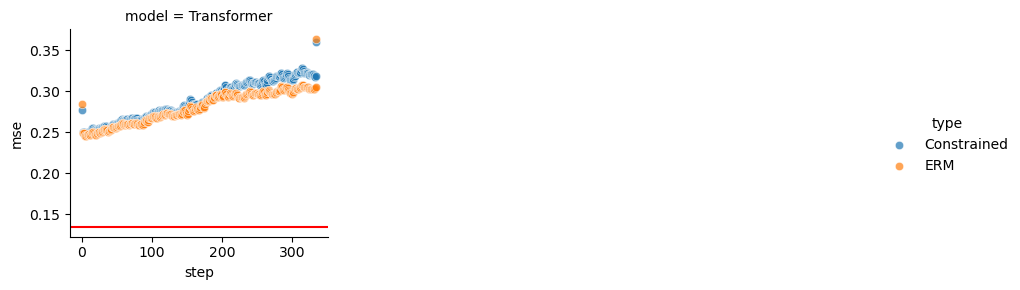

### Dataset: electricity.csv pred_len: 336 constraint_level: 0.13

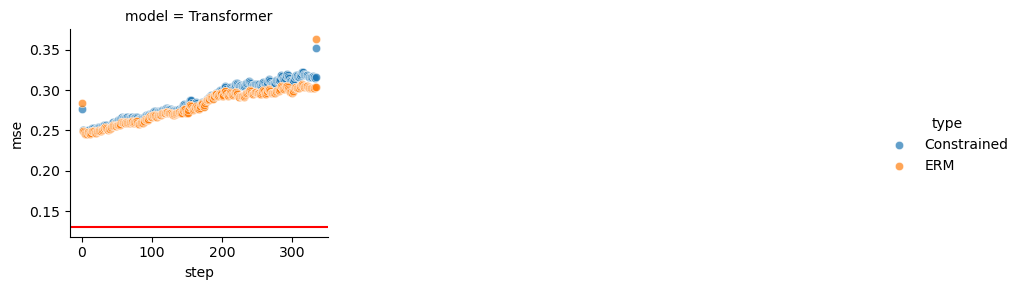

### Dataset: electricity.csv pred_len: 336 constraint_level: 0.127

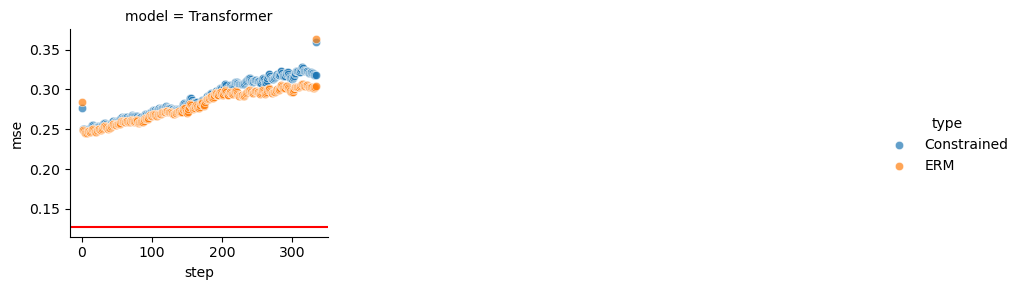

### Dataset: electricity.csv pred_len: 336 constraint_level: 0.189

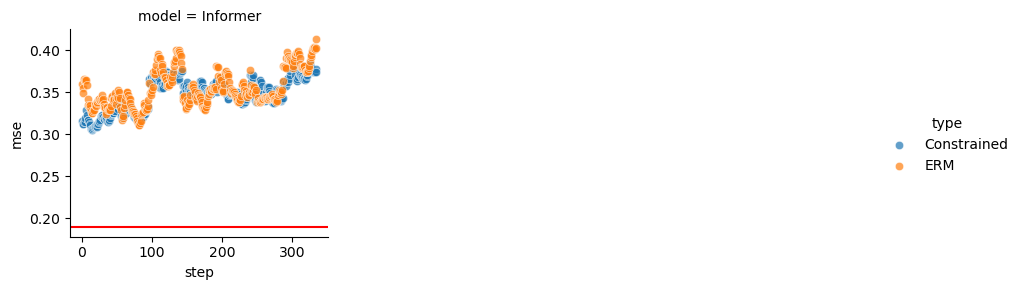

### Dataset: electricity.csv pred_len: 336 constraint_level: 0.184

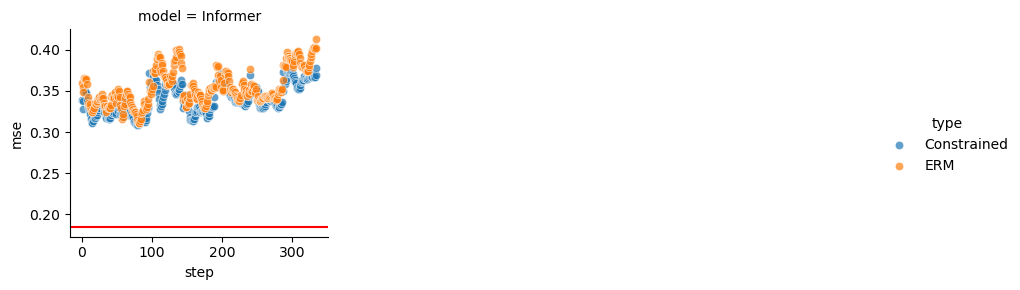

### Dataset: electricity.csv pred_len: 336 constraint_level: 0.18

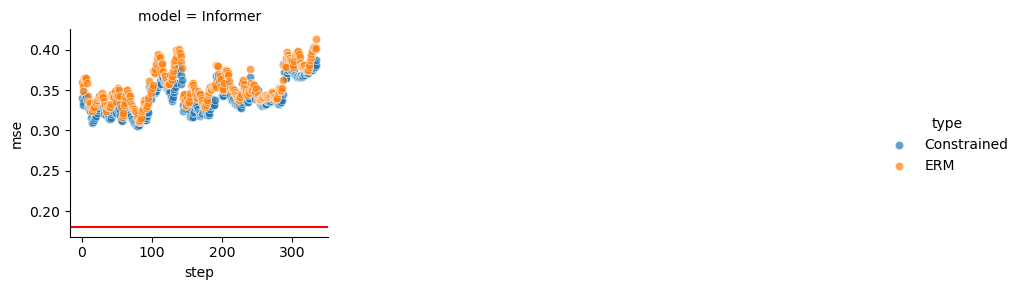

### Dataset: electricity.csv pred_len: 336 constraint_level: 0.167

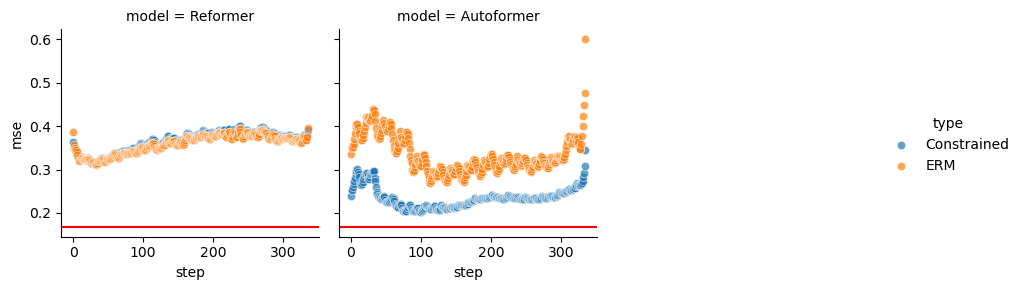

### Dataset: electricity.csv pred_len: 336 constraint_level: 0.166

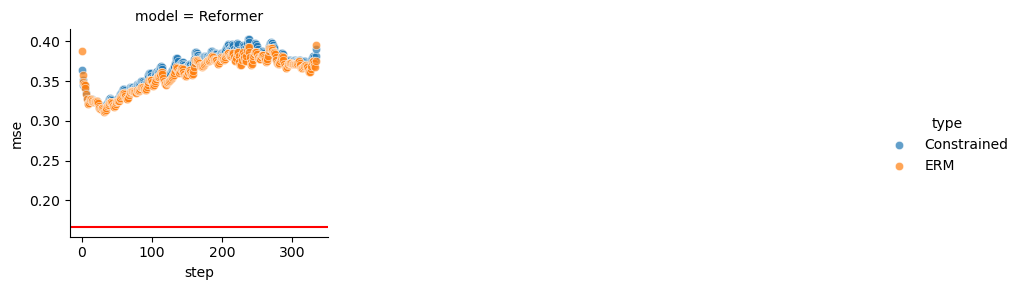

### Dataset: electricity.csv pred_len: 336 constraint_level: 0.165

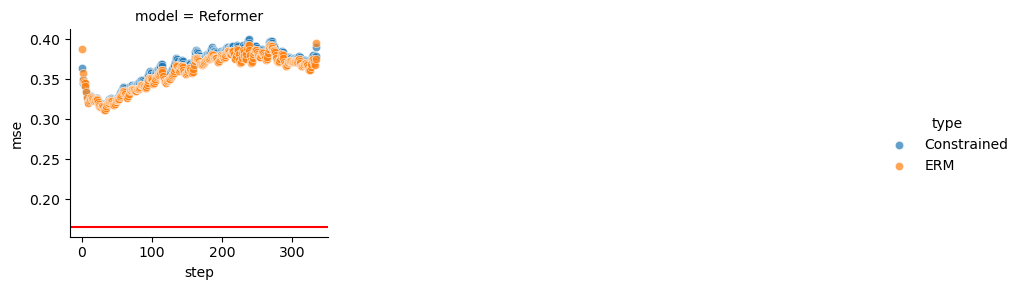

### Dataset: electricity.csv pred_len: 336 constraint_level: 0.163

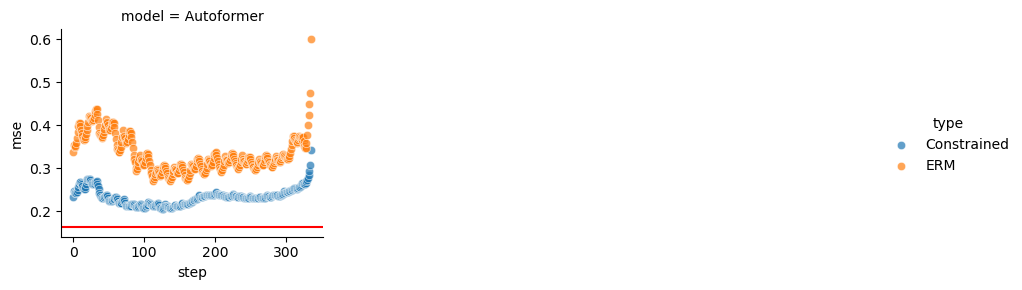

### Dataset: electricity.csv pred_len: 336 constraint_level: 0.155

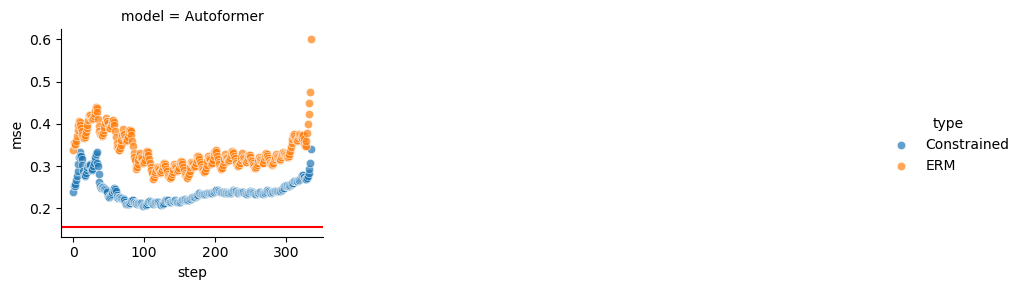

[0.141 0.138 0.137 0.212 0.208 0.206 0.178 0.177 0.176 0.185 0.174]


### Dataset: electricity.csv pred_len: 720 constraint_level: 0.141

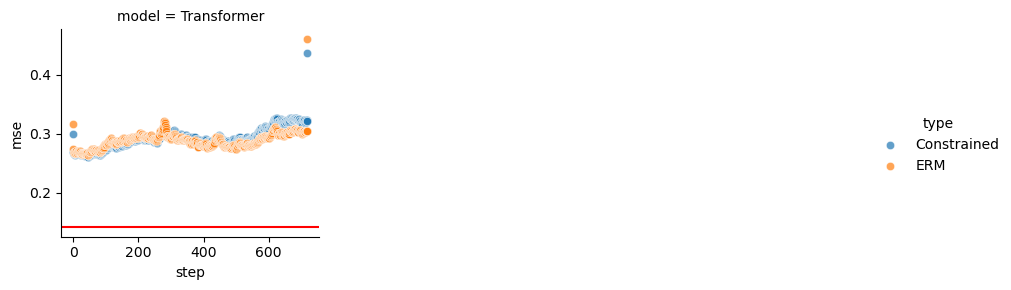

### Dataset: electricity.csv pred_len: 720 constraint_level: 0.138

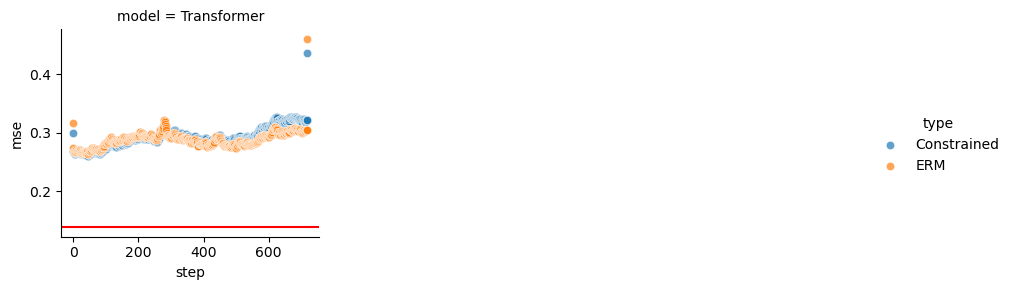

### Dataset: electricity.csv pred_len: 720 constraint_level: 0.137

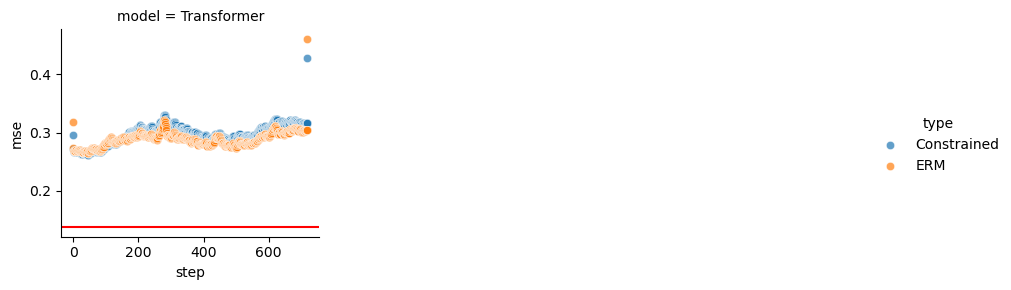

### Dataset: electricity.csv pred_len: 720 constraint_level: 0.212

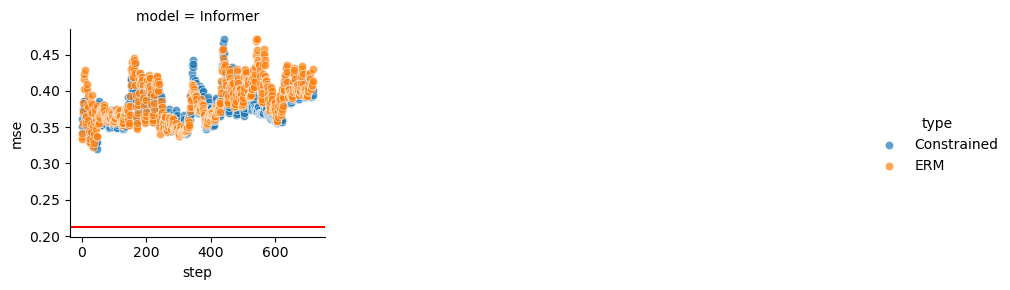

### Dataset: electricity.csv pred_len: 720 constraint_level: 0.208

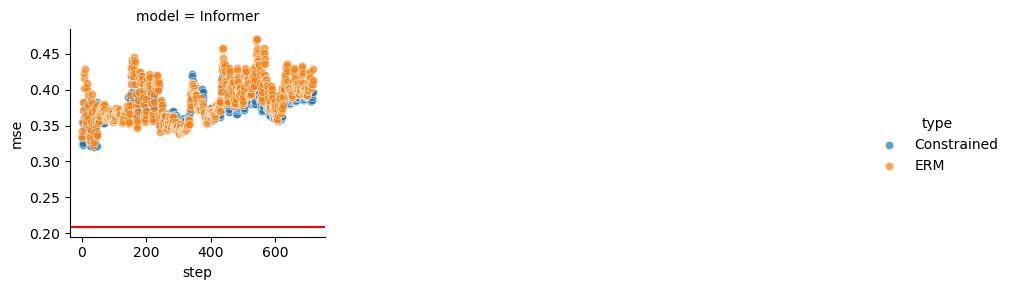

### Dataset: electricity.csv pred_len: 720 constraint_level: 0.206

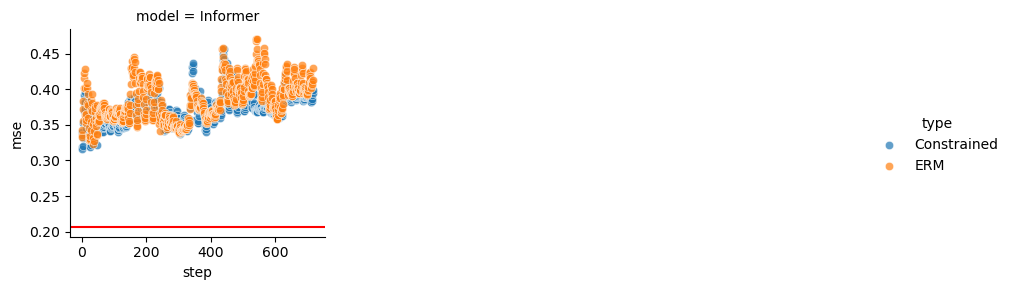

### Dataset: electricity.csv pred_len: 720 constraint_level: 0.178

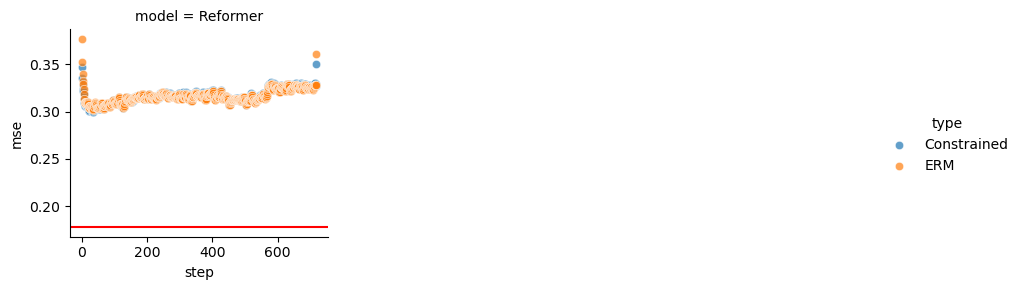

### Dataset: electricity.csv pred_len: 720 constraint_level: 0.177

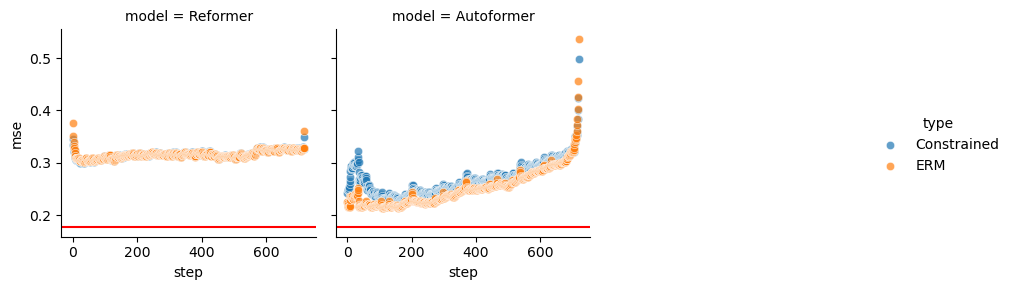

### Dataset: electricity.csv pred_len: 720 constraint_level: 0.176

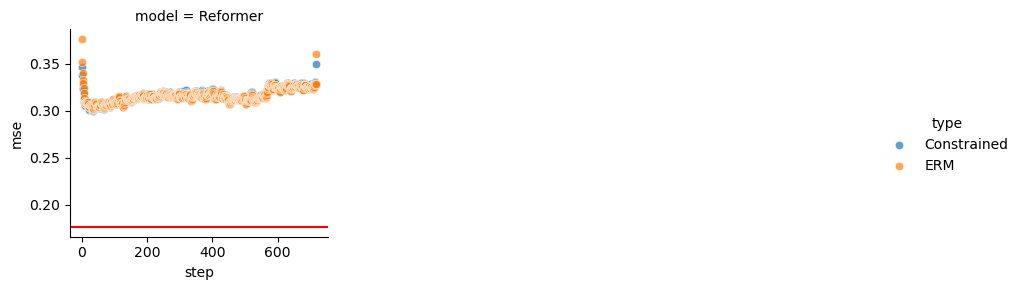

### Dataset: electricity.csv pred_len: 720 constraint_level: 0.185

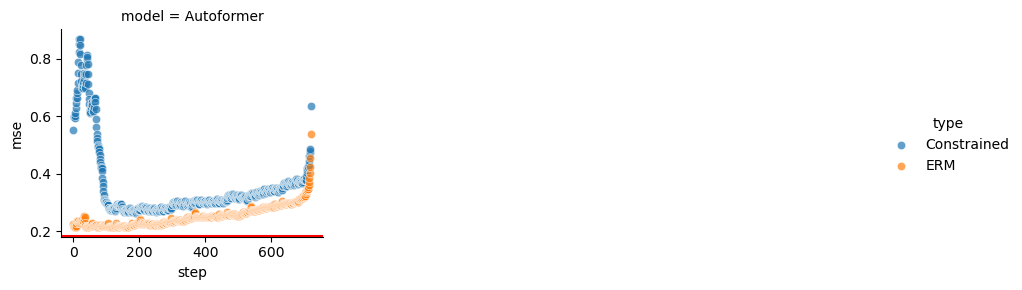

### Dataset: electricity.csv pred_len: 720 constraint_level: 0.174

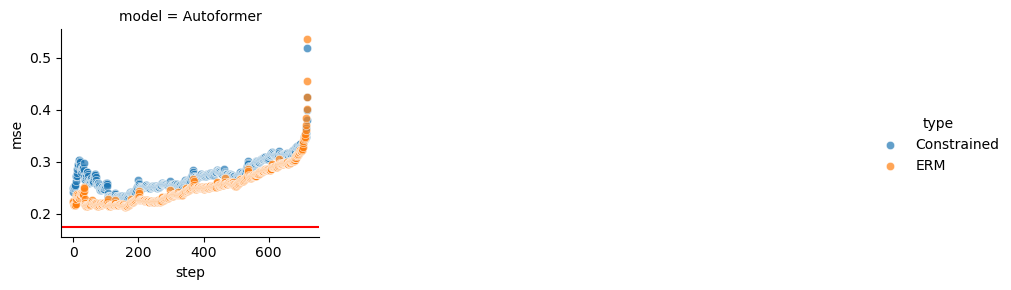

[0.029 0.028 0.025 0.041 0.038 0.037 0.138 0.108 0.079 0.214 0.15  0.107]


### Dataset: exchange_rate.csv pred_len: 96 constraint_level: 0.029

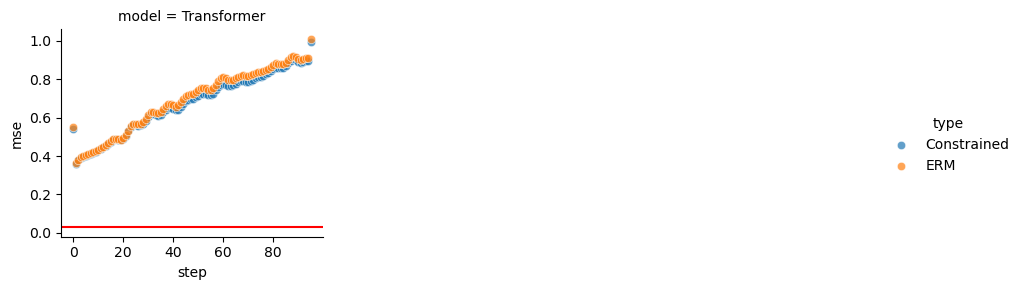

### Dataset: exchange_rate.csv pred_len: 96 constraint_level: 0.028

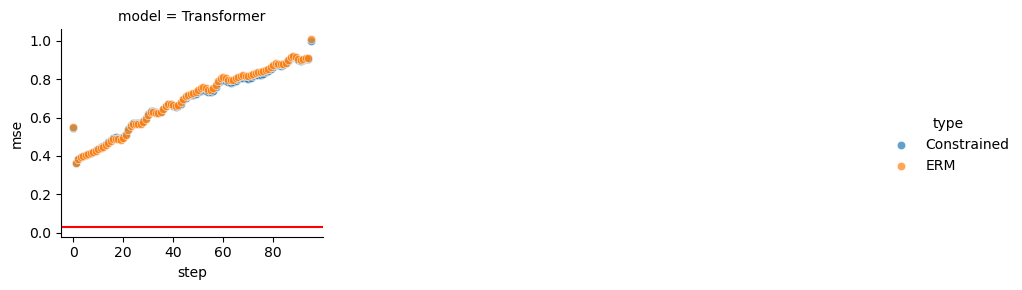

### Dataset: exchange_rate.csv pred_len: 96 constraint_level: 0.025

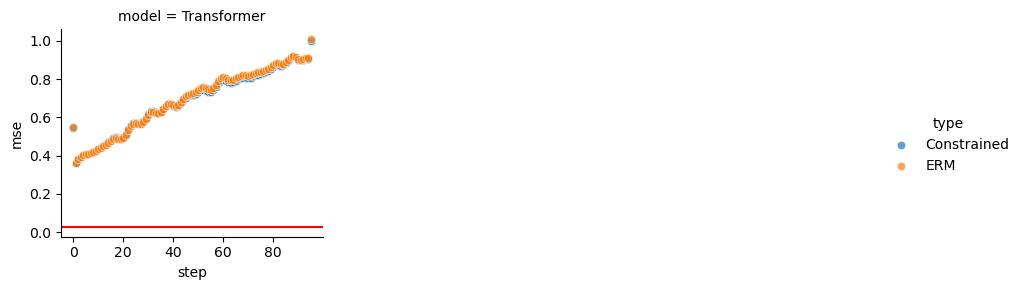

### Dataset: exchange_rate.csv pred_len: 96 constraint_level: 0.041

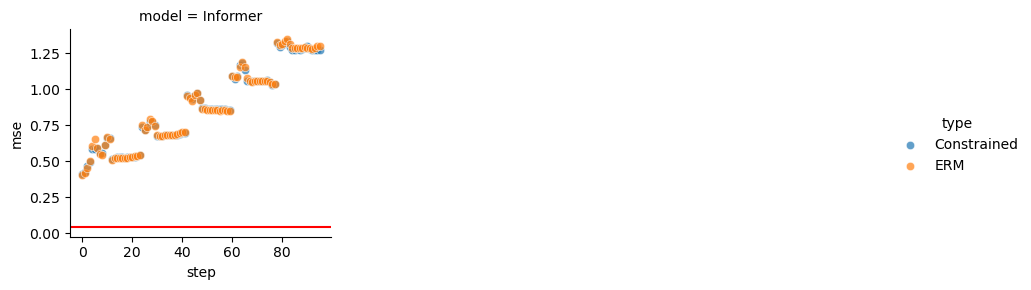

### Dataset: exchange_rate.csv pred_len: 96 constraint_level: 0.038

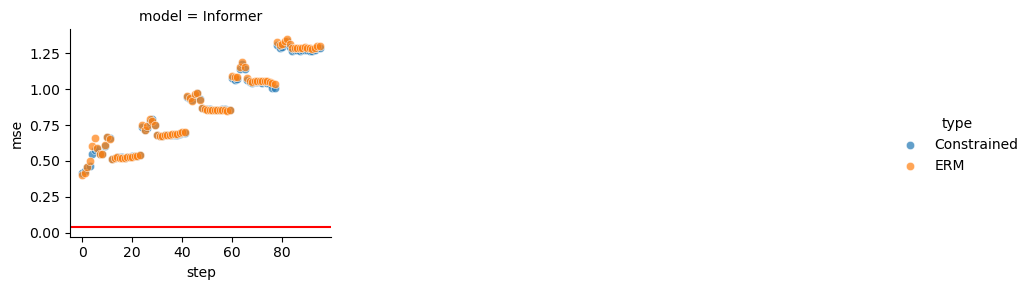

### Dataset: exchange_rate.csv pred_len: 96 constraint_level: 0.037

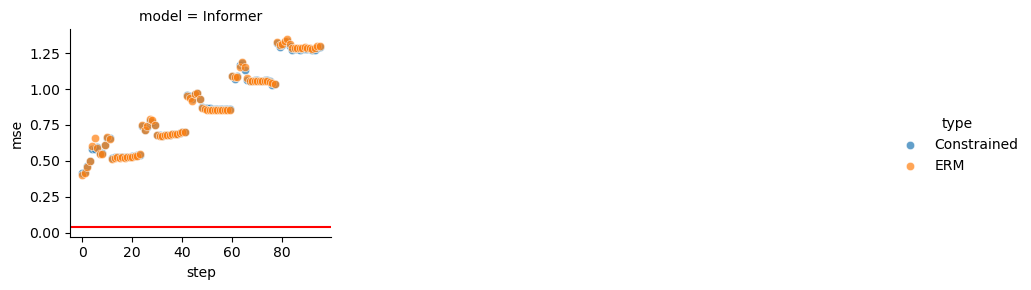

### Dataset: exchange_rate.csv pred_len: 96 constraint_level: 0.138

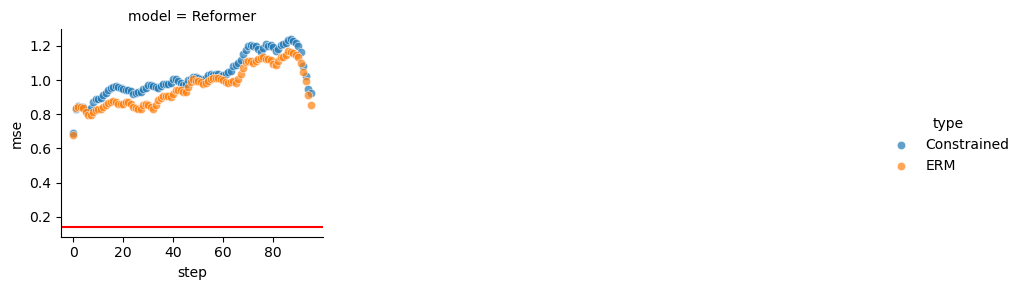

### Dataset: exchange_rate.csv pred_len: 96 constraint_level: 0.108

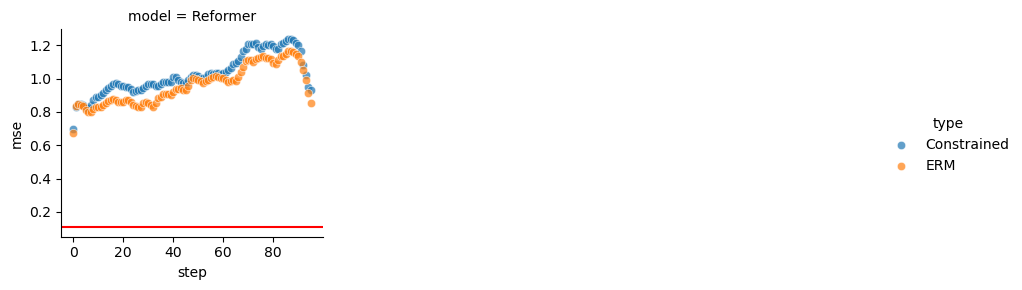

### Dataset: exchange_rate.csv pred_len: 96 constraint_level: 0.079

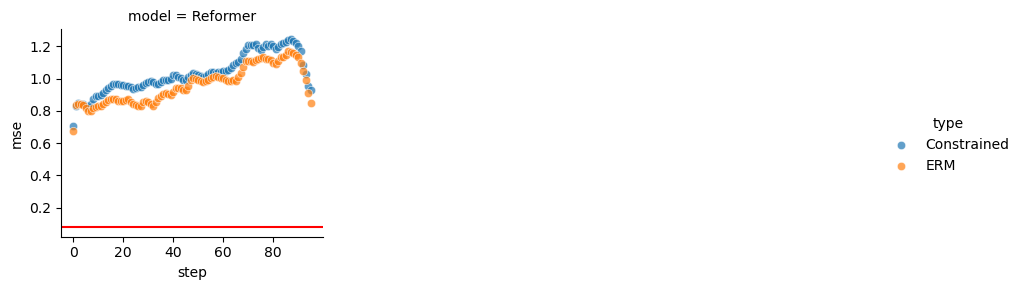

### Dataset: exchange_rate.csv pred_len: 96 constraint_level: 0.214

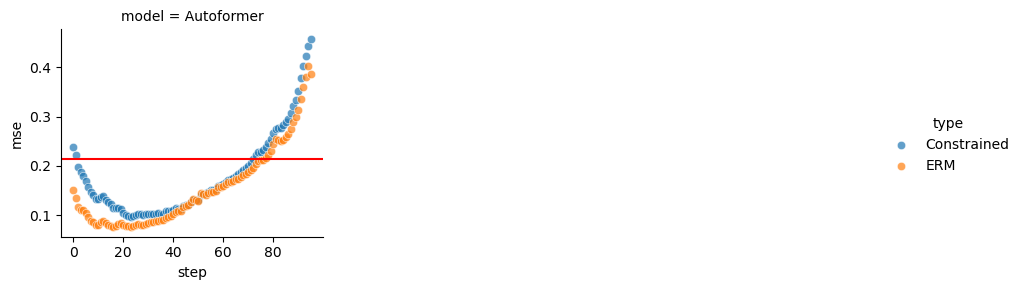

### Dataset: exchange_rate.csv pred_len: 96 constraint_level: 0.15

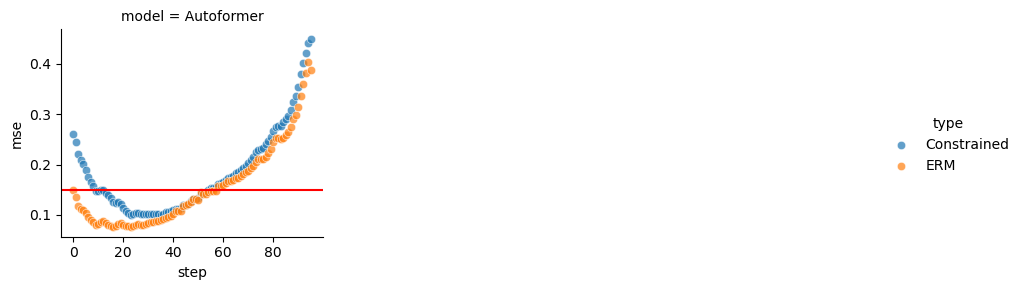

### Dataset: exchange_rate.csv pred_len: 96 constraint_level: 0.107

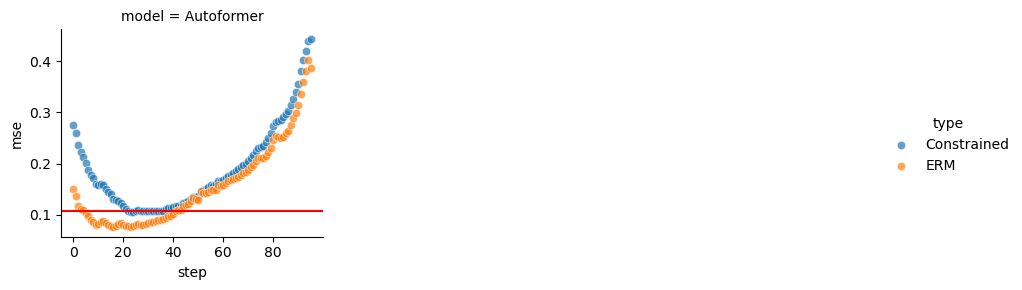

[0.035 0.029 0.031 0.046 0.042 0.04  0.267 0.189 0.134 0.336 0.266 0.232]


### Dataset: exchange_rate.csv pred_len: 192 constraint_level: 0.035

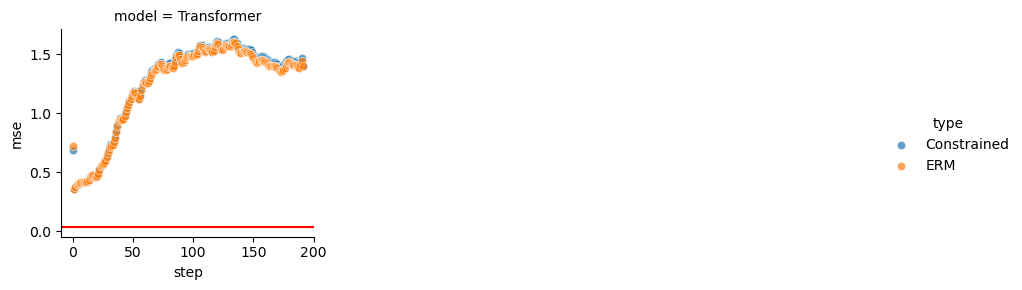

### Dataset: exchange_rate.csv pred_len: 192 constraint_level: 0.029

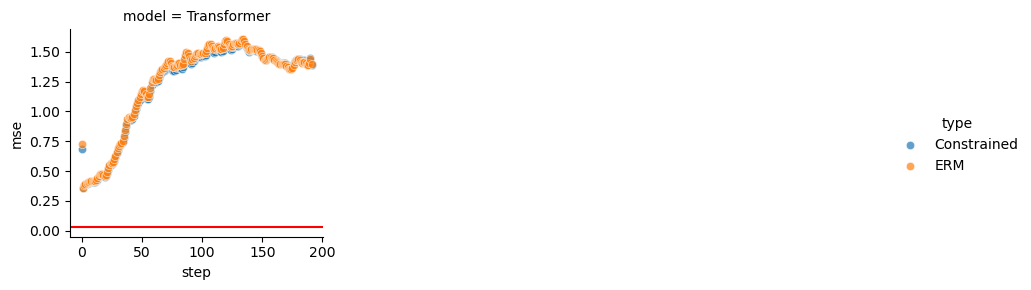

### Dataset: exchange_rate.csv pred_len: 192 constraint_level: 0.031

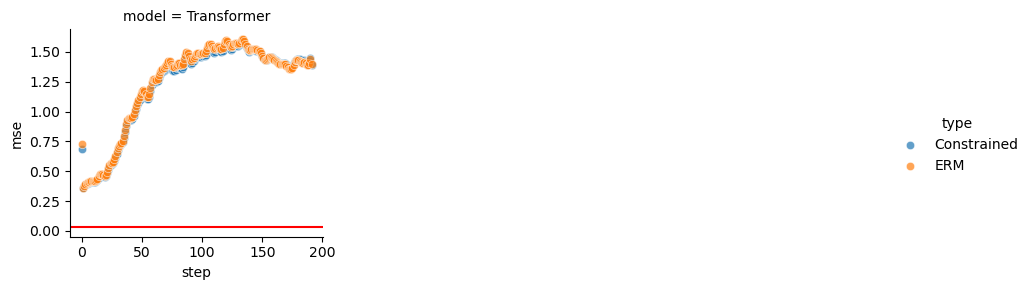

### Dataset: exchange_rate.csv pred_len: 192 constraint_level: 0.046

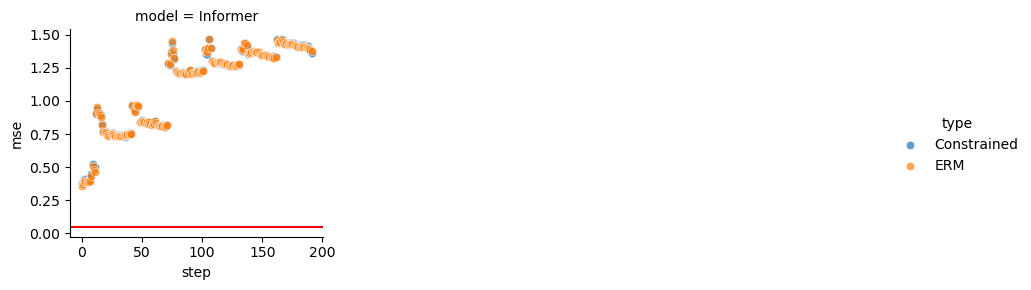

### Dataset: exchange_rate.csv pred_len: 192 constraint_level: 0.042

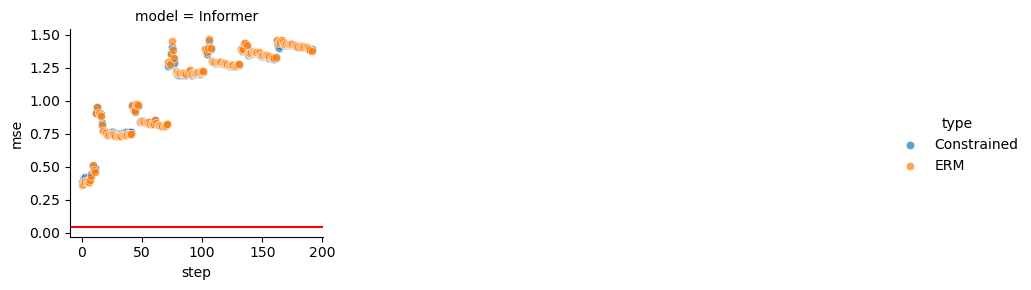

### Dataset: exchange_rate.csv pred_len: 192 constraint_level: 0.04

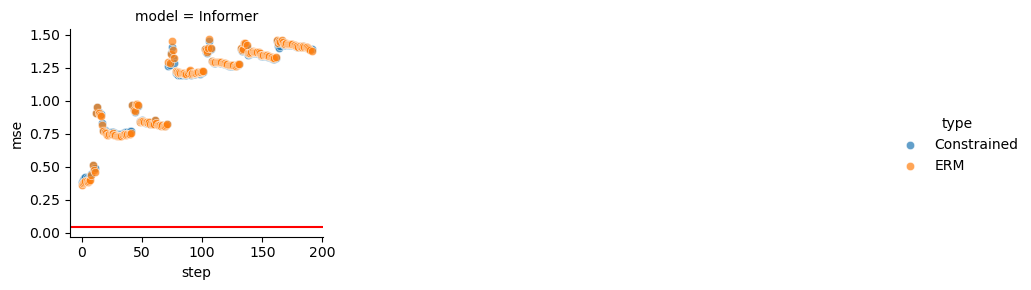

### Dataset: exchange_rate.csv pred_len: 192 constraint_level: 0.267

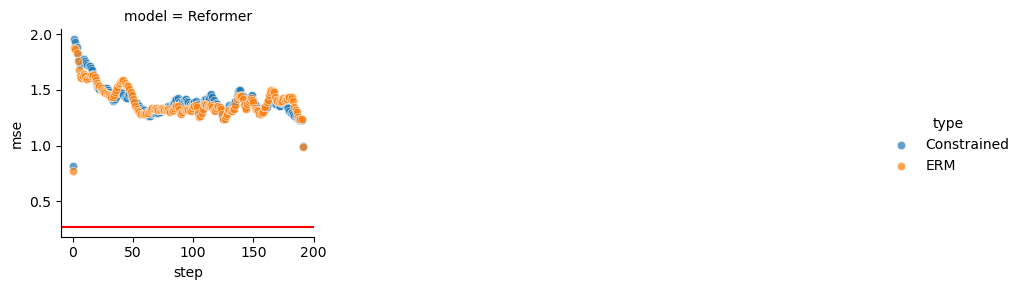

### Dataset: exchange_rate.csv pred_len: 192 constraint_level: 0.189

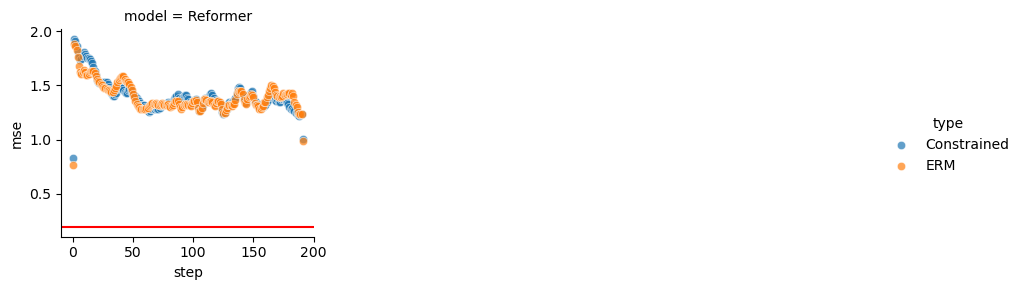

### Dataset: exchange_rate.csv pred_len: 192 constraint_level: 0.134

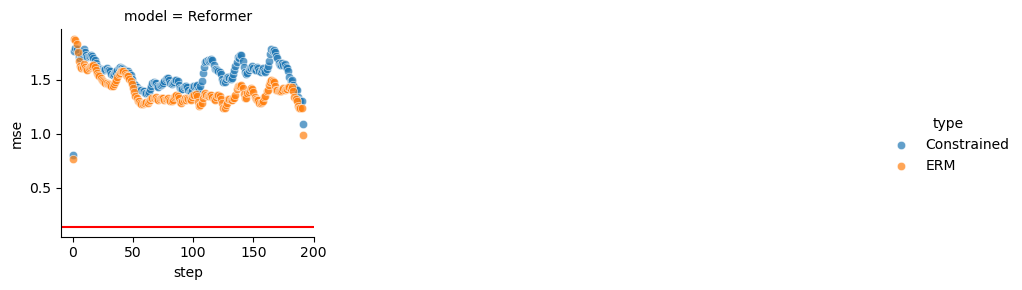

### Dataset: exchange_rate.csv pred_len: 192 constraint_level: 0.336

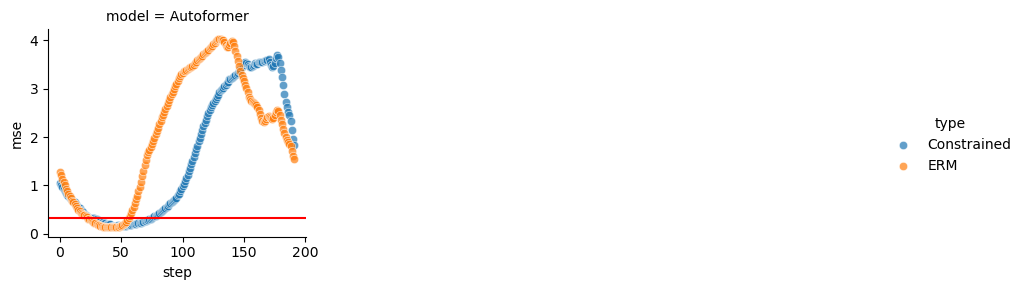

### Dataset: exchange_rate.csv pred_len: 192 constraint_level: 0.266

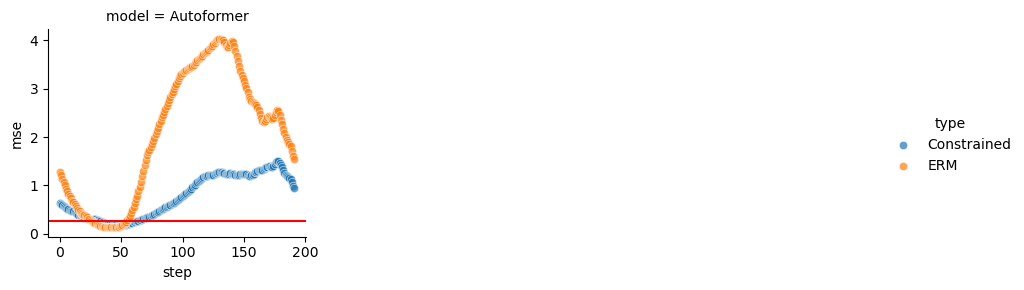

### Dataset: exchange_rate.csv pred_len: 192 constraint_level: 0.232

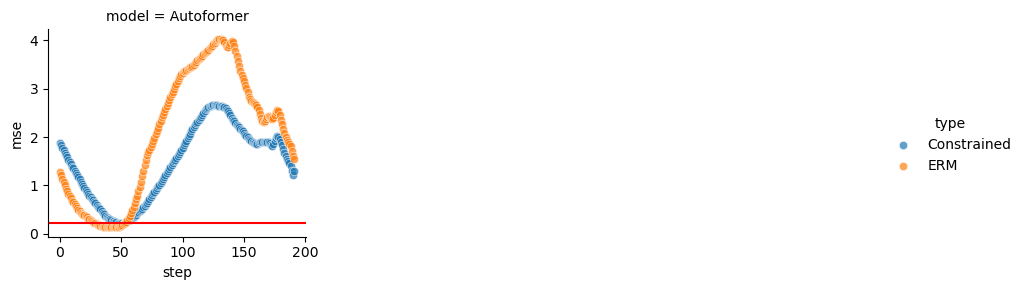

[0.043 0.039 0.037 0.053 0.048 0.046 0.461 0.35  0.209 0.539 0.379 0.285]


### Dataset: exchange_rate.csv pred_len: 336 constraint_level: 0.043

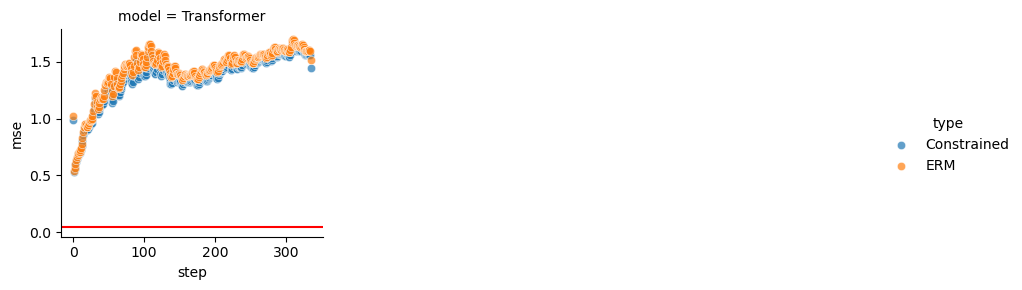

### Dataset: exchange_rate.csv pred_len: 336 constraint_level: 0.039

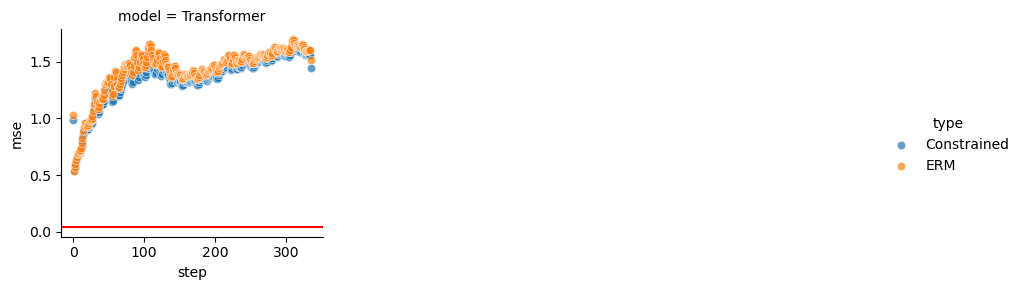

### Dataset: exchange_rate.csv pred_len: 336 constraint_level: 0.037

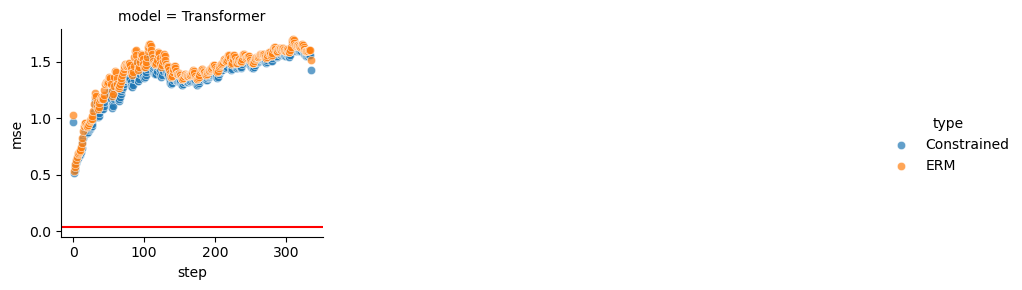

### Dataset: exchange_rate.csv pred_len: 336 constraint_level: 0.053

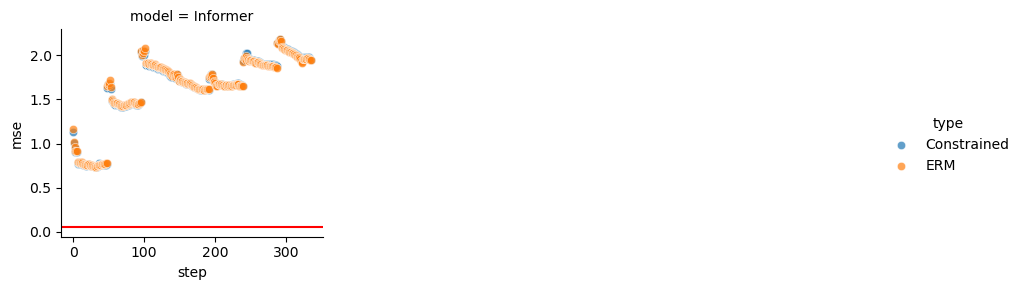

### Dataset: exchange_rate.csv pred_len: 336 constraint_level: 0.048

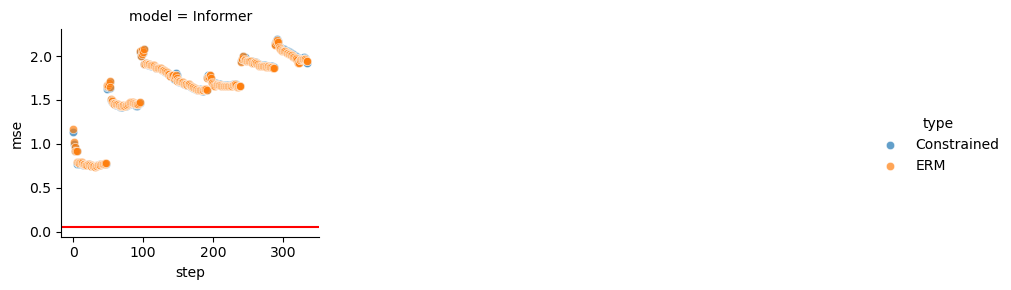

### Dataset: exchange_rate.csv pred_len: 336 constraint_level: 0.046

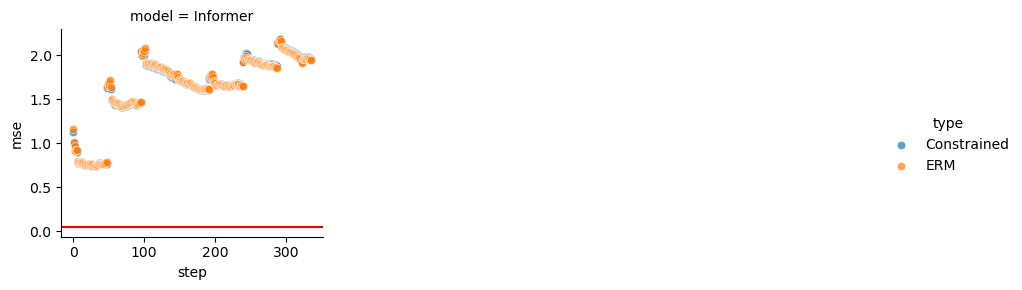

### Dataset: exchange_rate.csv pred_len: 336 constraint_level: 0.461

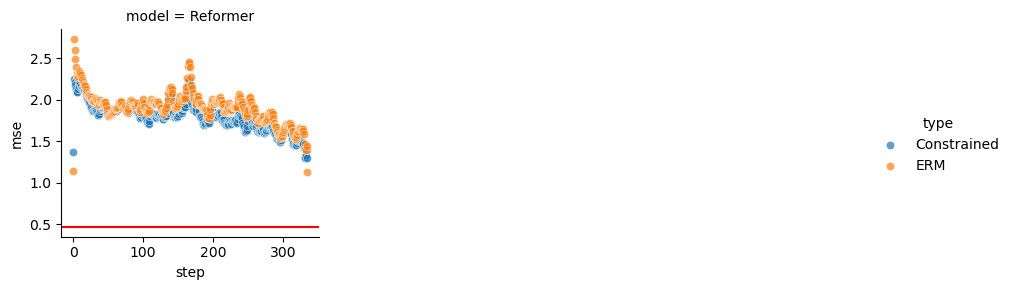

### Dataset: exchange_rate.csv pred_len: 336 constraint_level: 0.35

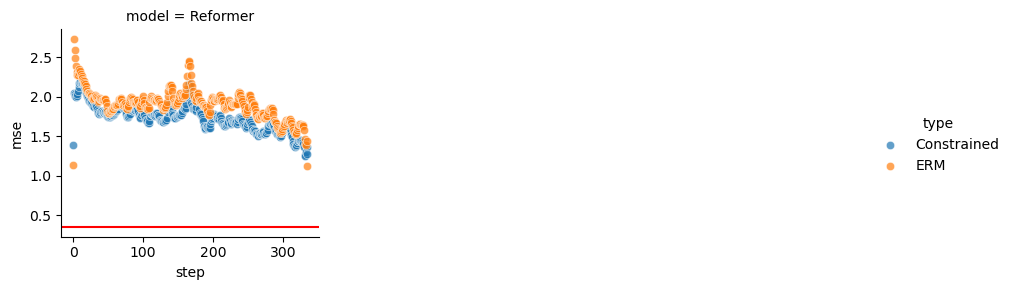

### Dataset: exchange_rate.csv pred_len: 336 constraint_level: 0.209

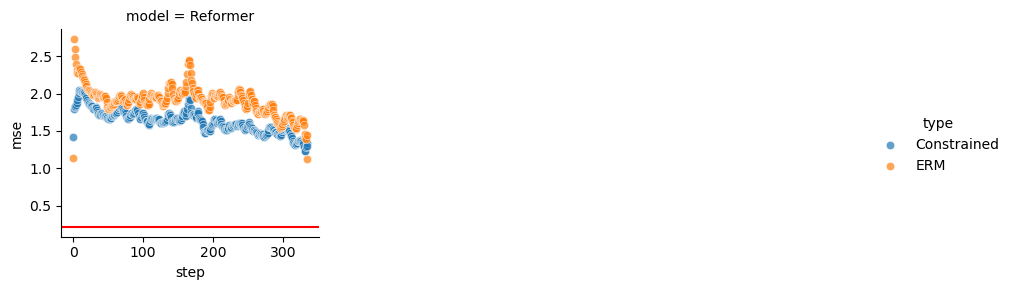

### Dataset: exchange_rate.csv pred_len: 336 constraint_level: 0.539

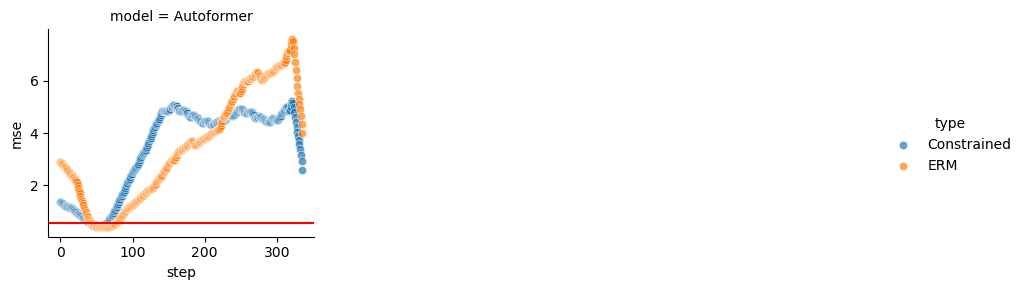

### Dataset: exchange_rate.csv pred_len: 336 constraint_level: 0.379

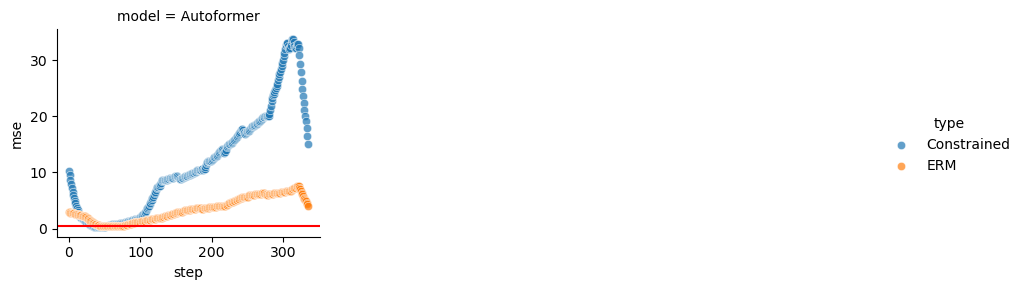

### Dataset: exchange_rate.csv pred_len: 336 constraint_level: 0.285

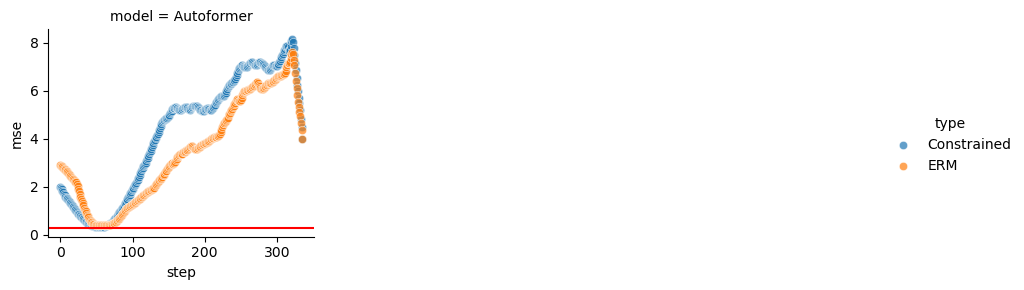

[0.049 0.051 0.048 0.062 0.055 0.688 0.603 0.354 1.024 0.765 0.383]


### Dataset: exchange_rate.csv pred_len: 720 constraint_level: 0.049

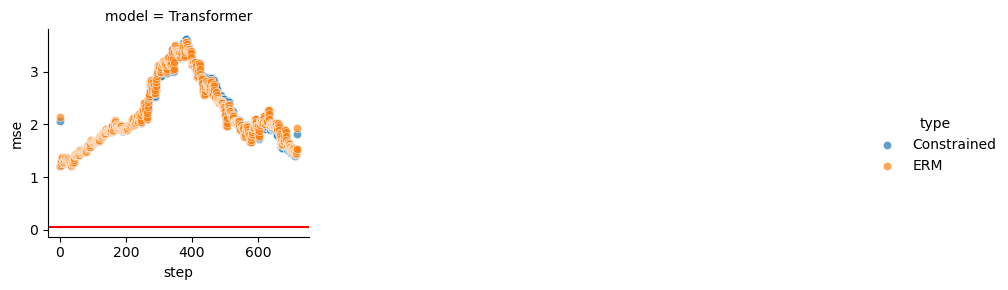

### Dataset: exchange_rate.csv pred_len: 720 constraint_level: 0.051

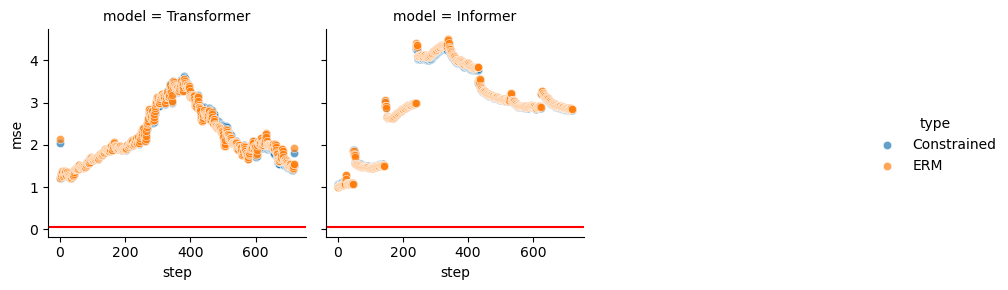

### Dataset: exchange_rate.csv pred_len: 720 constraint_level: 0.048

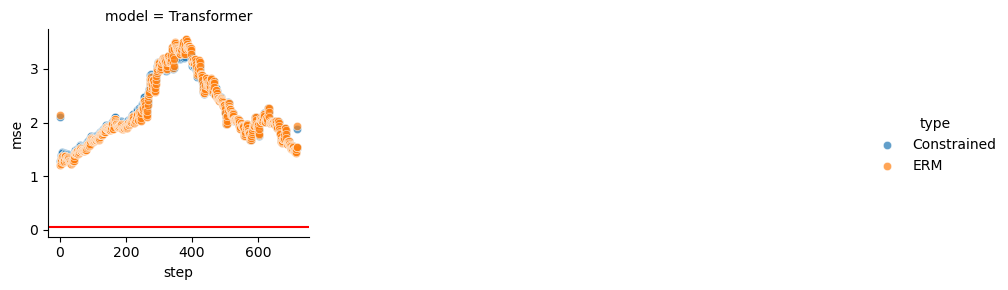

### Dataset: exchange_rate.csv pred_len: 720 constraint_level: 0.062

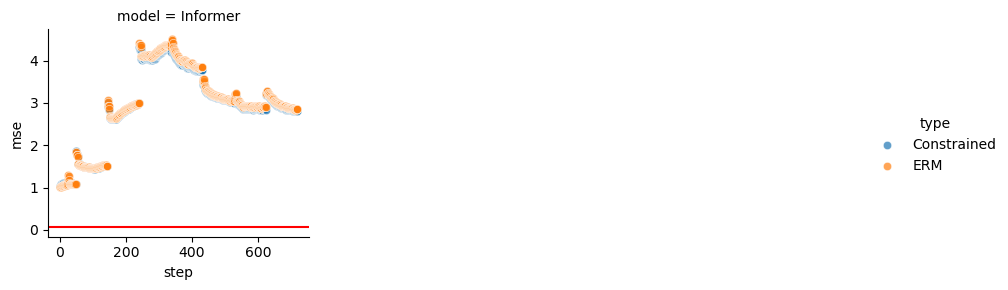

### Dataset: exchange_rate.csv pred_len: 720 constraint_level: 0.055

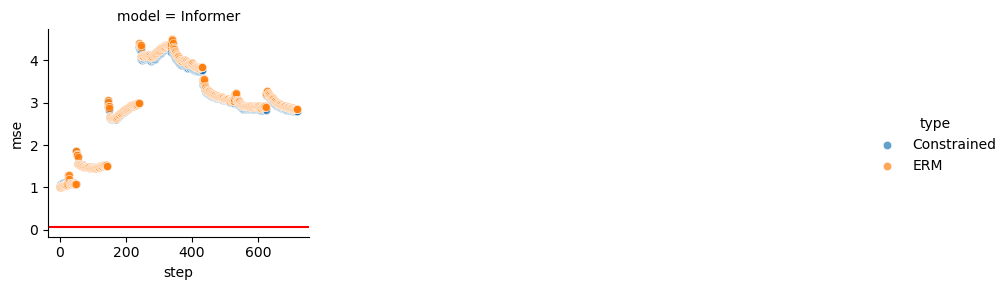

### Dataset: exchange_rate.csv pred_len: 720 constraint_level: 0.688

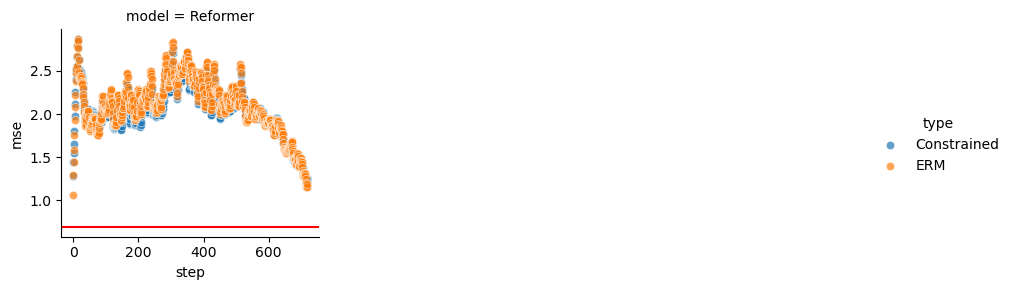

### Dataset: exchange_rate.csv pred_len: 720 constraint_level: 0.603

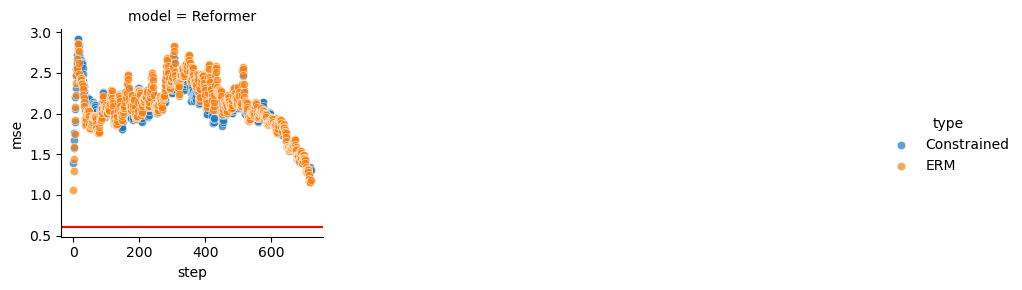

### Dataset: exchange_rate.csv pred_len: 720 constraint_level: 0.354

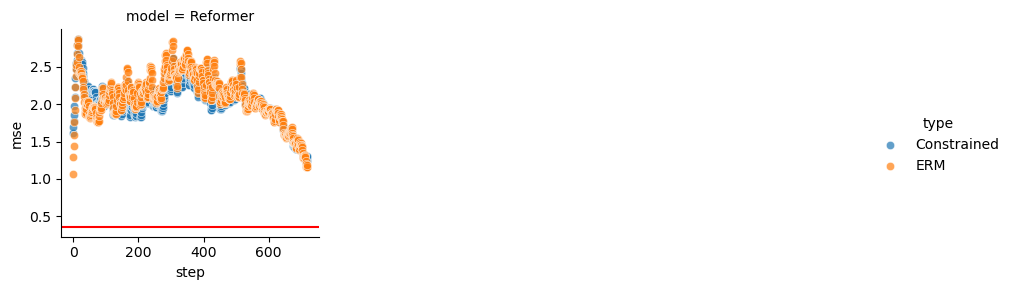

### Dataset: exchange_rate.csv pred_len: 720 constraint_level: 1.024

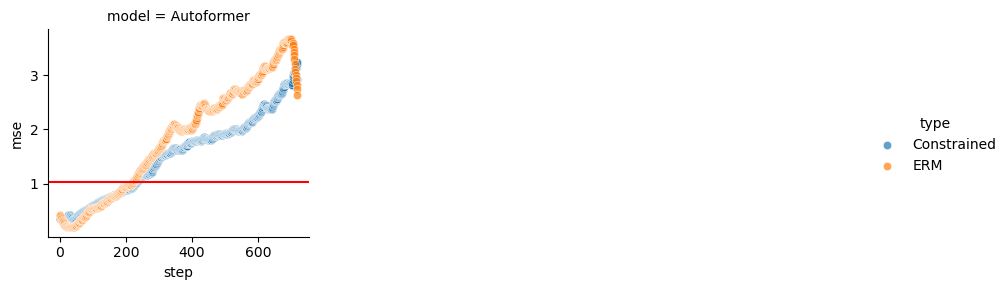

### Dataset: exchange_rate.csv pred_len: 720 constraint_level: 0.765

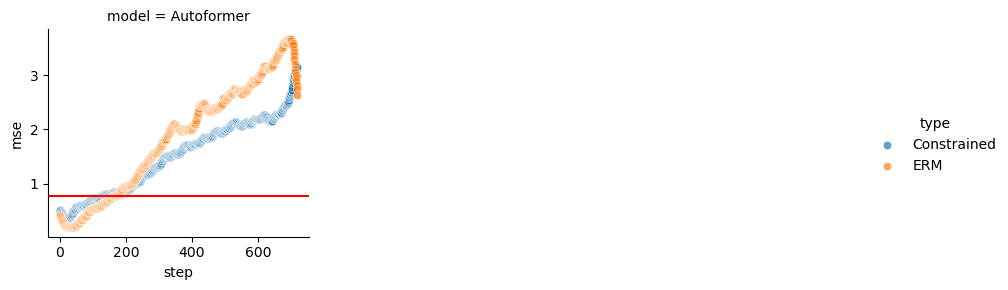

### Dataset: exchange_rate.csv pred_len: 720 constraint_level: 0.383

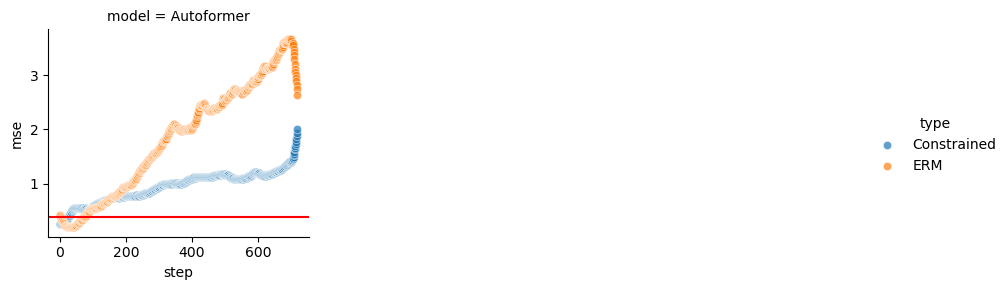

[0.173 0.167 0.164 0.222 0.217 0.213 0.32  0.303 0.29  0.332 0.299 0.292]


### Dataset: weather.csv pred_len: 96 constraint_level: 0.173

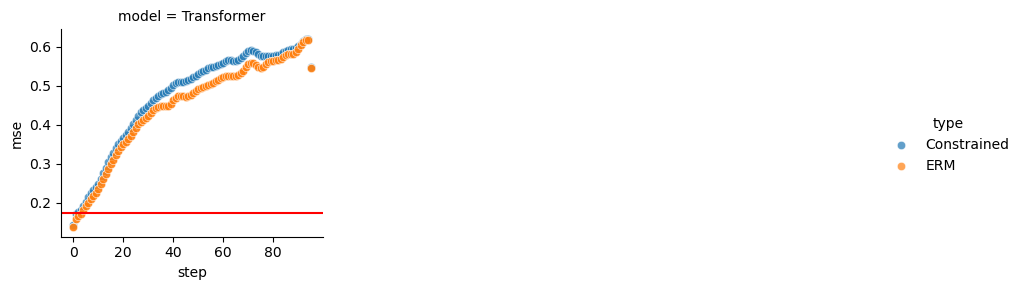

### Dataset: weather.csv pred_len: 96 constraint_level: 0.167

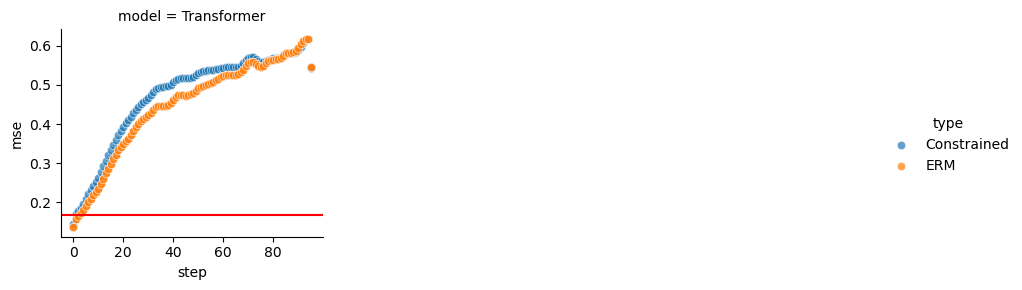

### Dataset: weather.csv pred_len: 96 constraint_level: 0.164

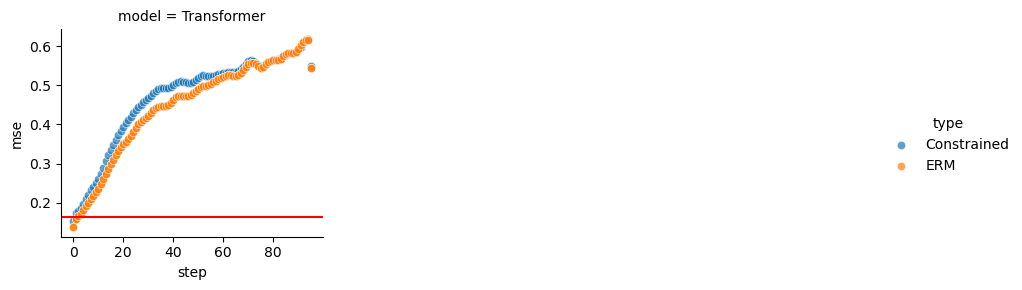

### Dataset: weather.csv pred_len: 96 constraint_level: 0.222

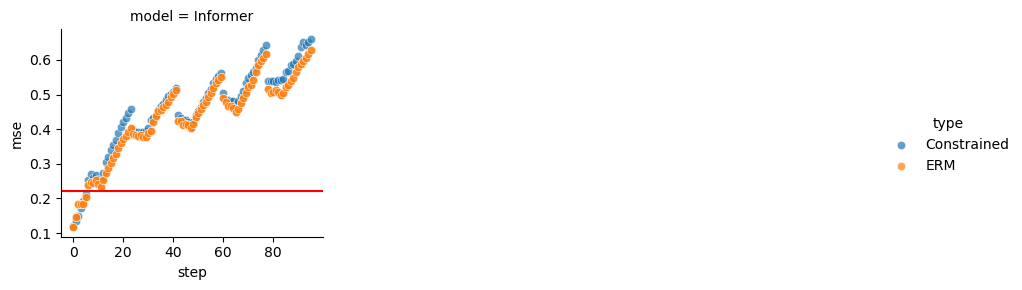

### Dataset: weather.csv pred_len: 96 constraint_level: 0.217

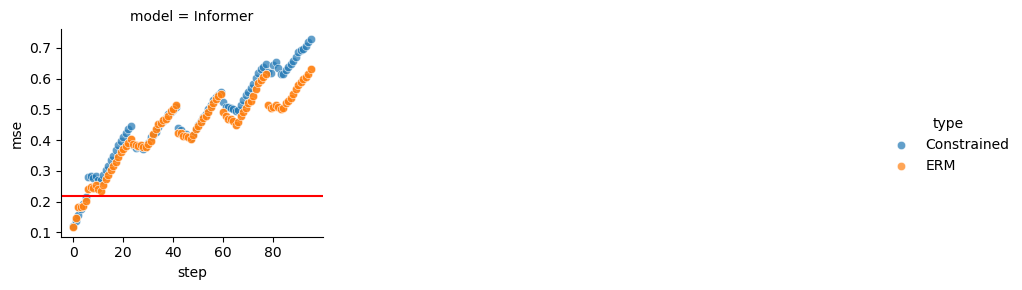

### Dataset: weather.csv pred_len: 96 constraint_level: 0.213

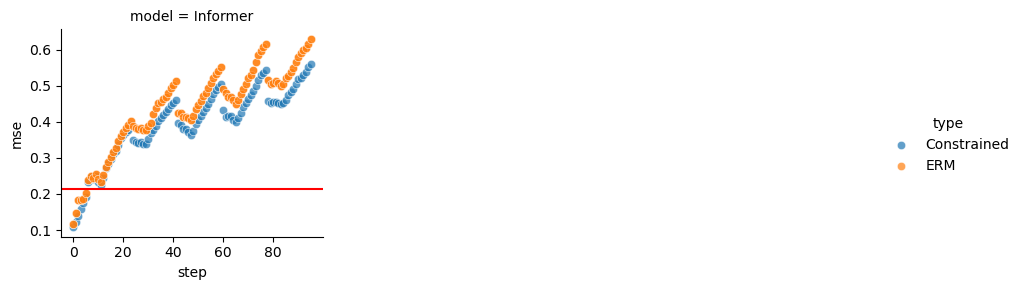

### Dataset: weather.csv pred_len: 96 constraint_level: 0.32

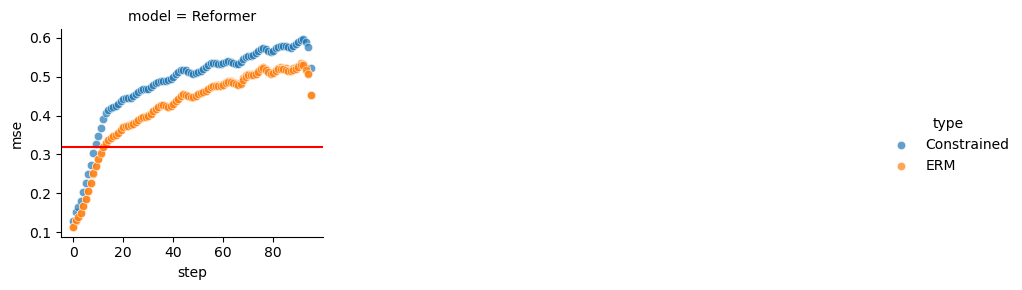

### Dataset: weather.csv pred_len: 96 constraint_level: 0.303

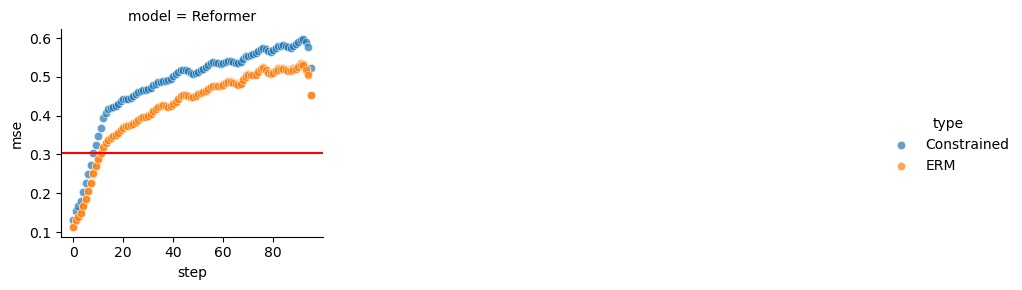

### Dataset: weather.csv pred_len: 96 constraint_level: 0.29

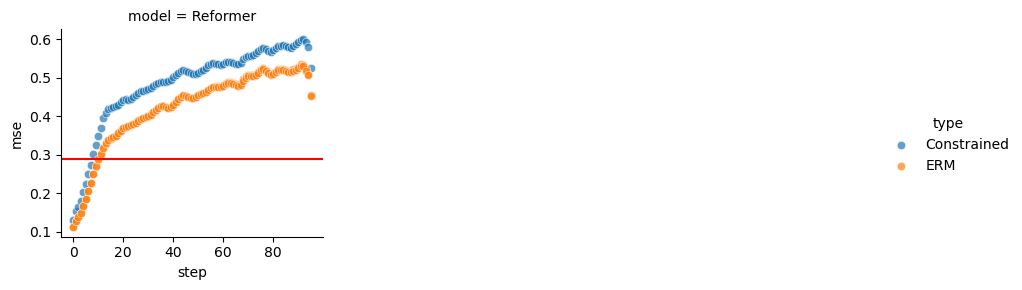

### Dataset: weather.csv pred_len: 96 constraint_level: 0.332

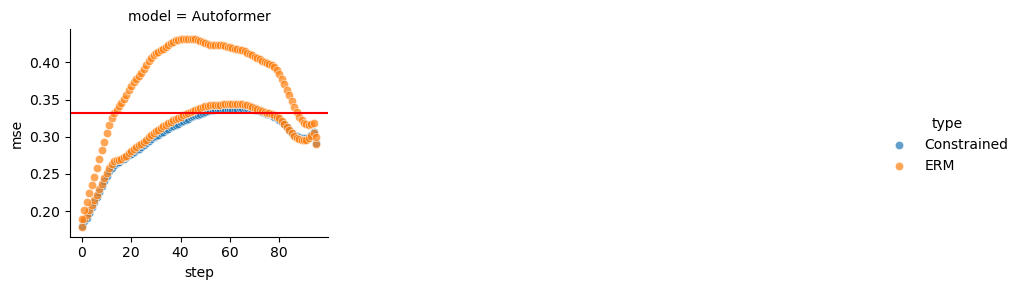

### Dataset: weather.csv pred_len: 96 constraint_level: 0.299

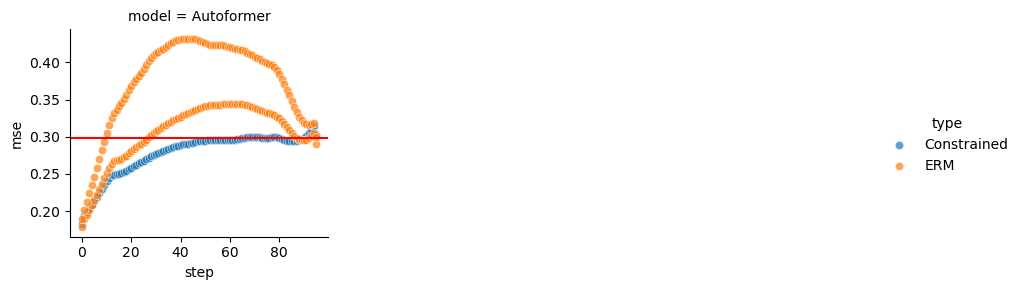

### Dataset: weather.csv pred_len: 96 constraint_level: 0.292

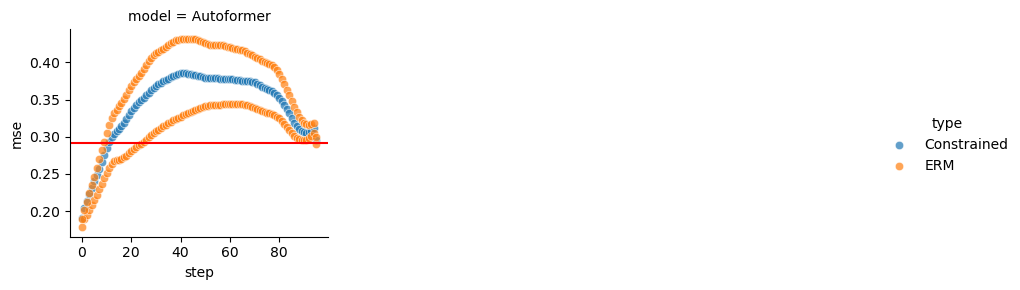

[0.187 0.182 0.177 0.234 0.228 0.222 0.327 0.315 0.306 0.696 0.464 0.383]


### Dataset: weather.csv pred_len: 192 constraint_level: 0.187

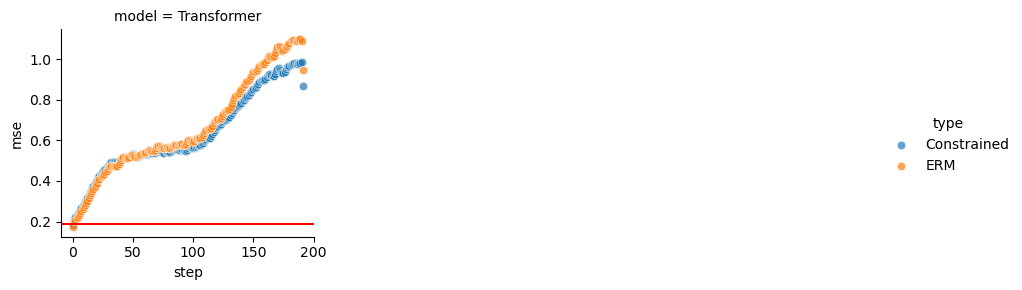

### Dataset: weather.csv pred_len: 192 constraint_level: 0.182

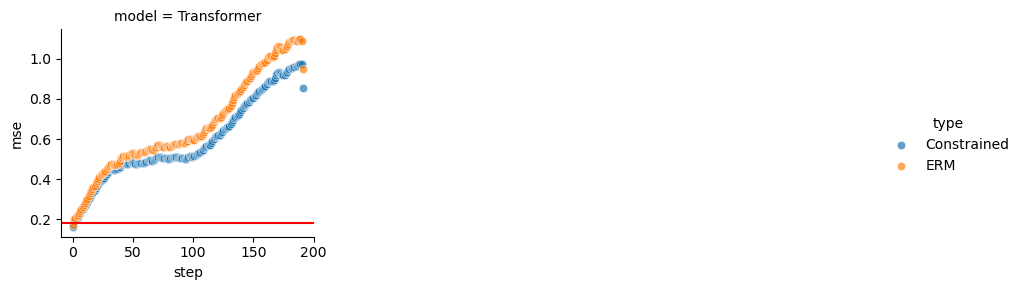

### Dataset: weather.csv pred_len: 192 constraint_level: 0.177

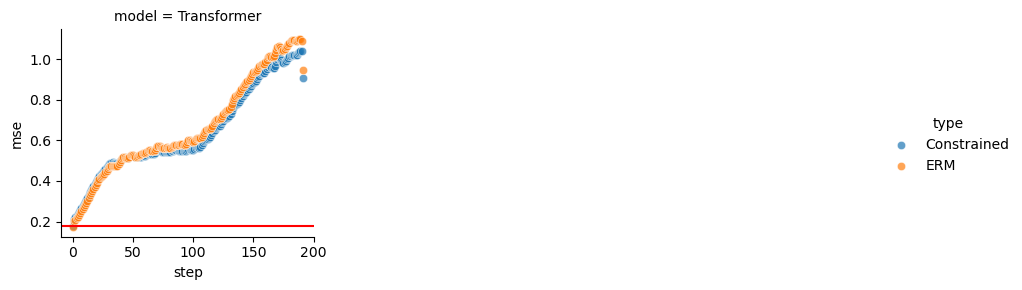

### Dataset: weather.csv pred_len: 192 constraint_level: 0.234

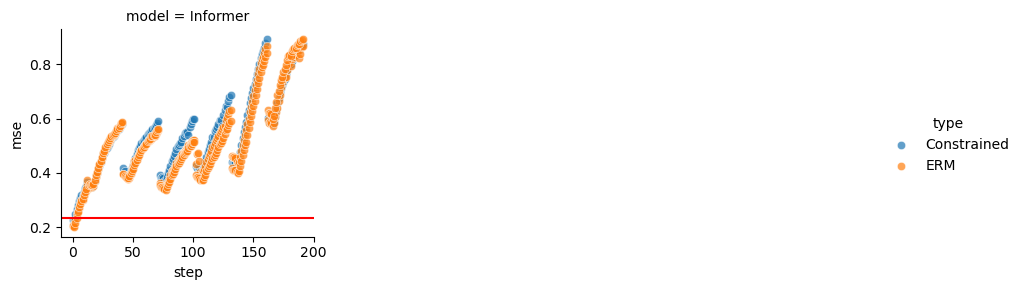

### Dataset: weather.csv pred_len: 192 constraint_level: 0.228

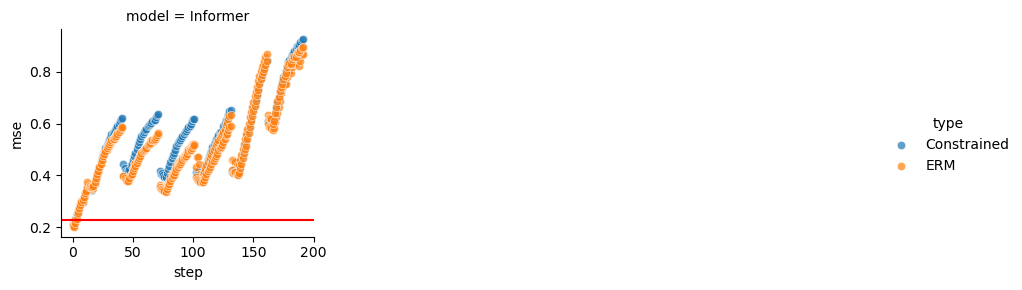

### Dataset: weather.csv pred_len: 192 constraint_level: 0.222

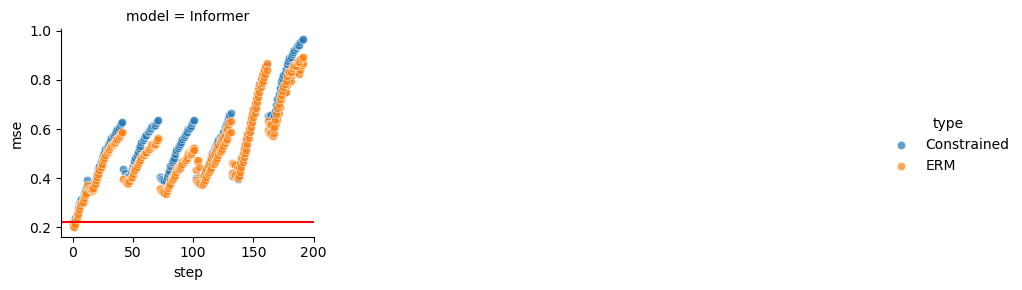

### Dataset: weather.csv pred_len: 192 constraint_level: 0.327

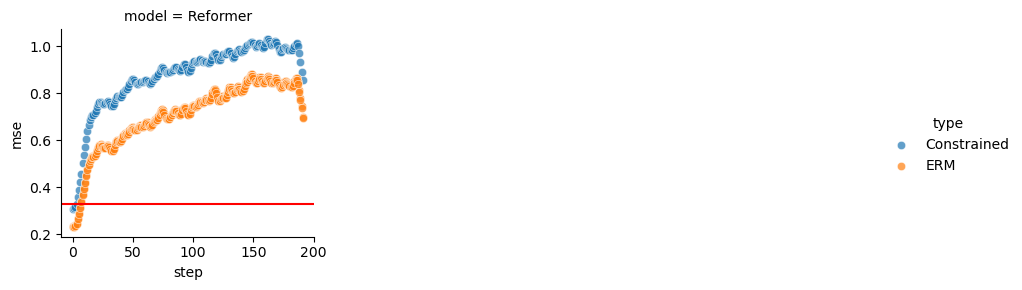

### Dataset: weather.csv pred_len: 192 constraint_level: 0.315

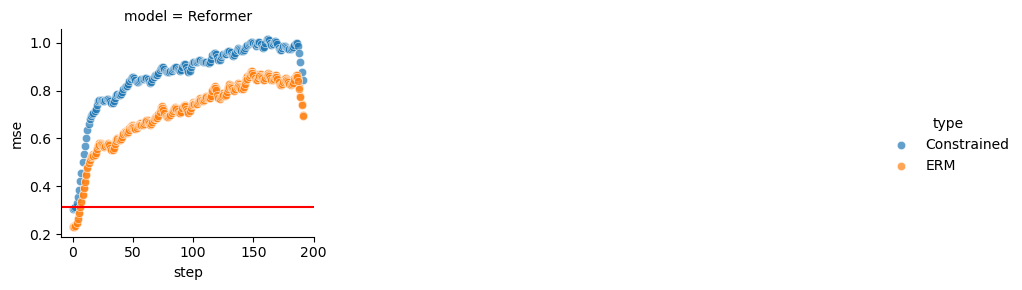

### Dataset: weather.csv pred_len: 192 constraint_level: 0.306

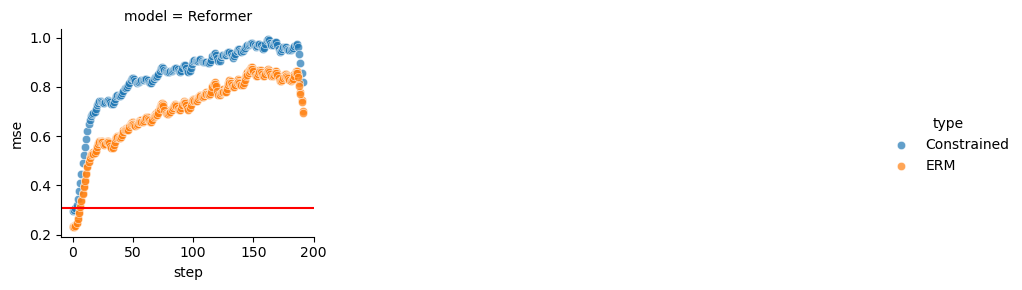

### Dataset: weather.csv pred_len: 192 constraint_level: 0.696

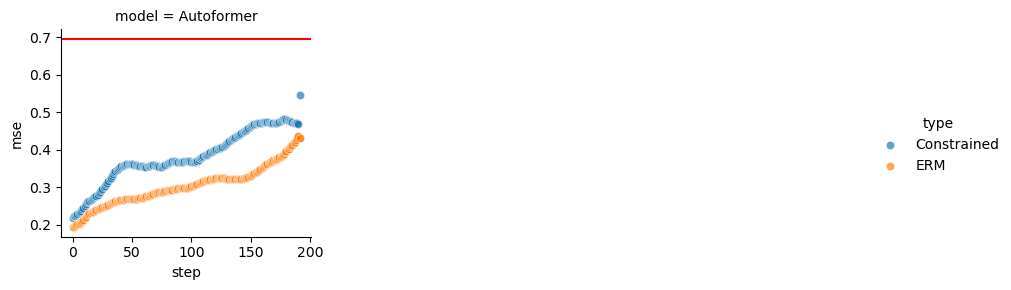

### Dataset: weather.csv pred_len: 192 constraint_level: 0.464

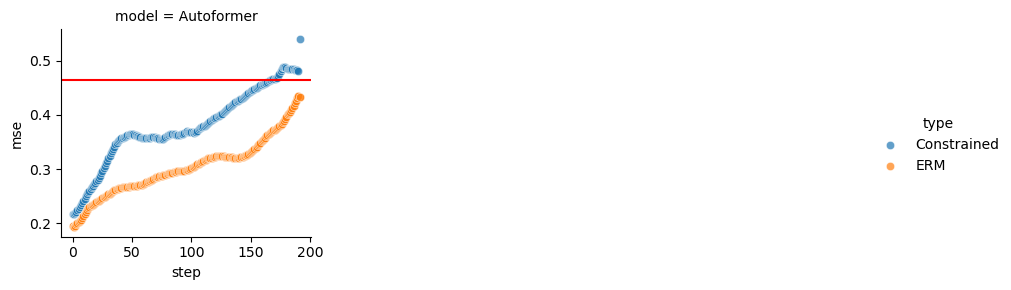

### Dataset: weather.csv pred_len: 192 constraint_level: 0.383

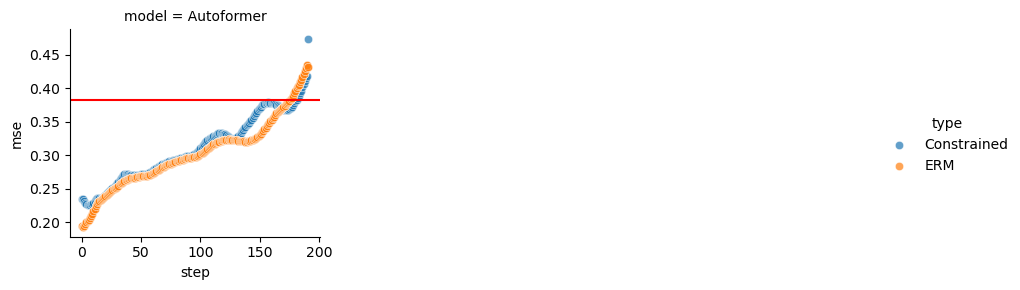

[0.198 0.195 0.194 0.245 0.237 0.232 0.316 0.313 0.309 0.681 0.661 0.392]


### Dataset: weather.csv pred_len: 336 constraint_level: 0.198

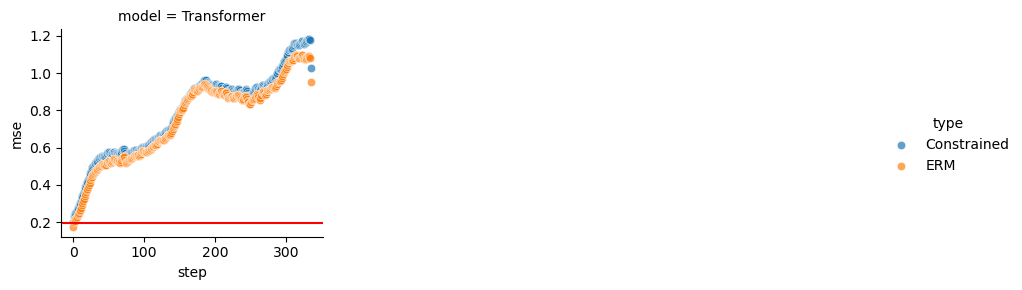

### Dataset: weather.csv pred_len: 336 constraint_level: 0.195

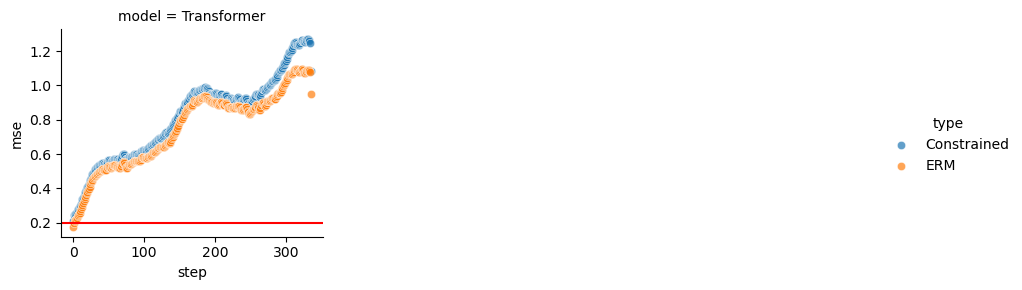

### Dataset: weather.csv pred_len: 336 constraint_level: 0.194

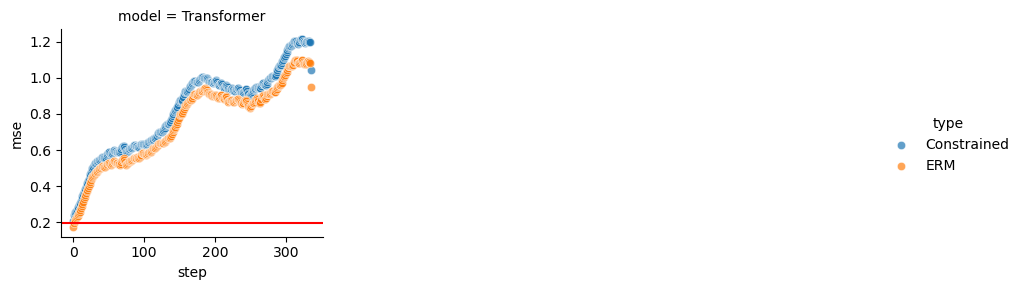

### Dataset: weather.csv pred_len: 336 constraint_level: 0.245

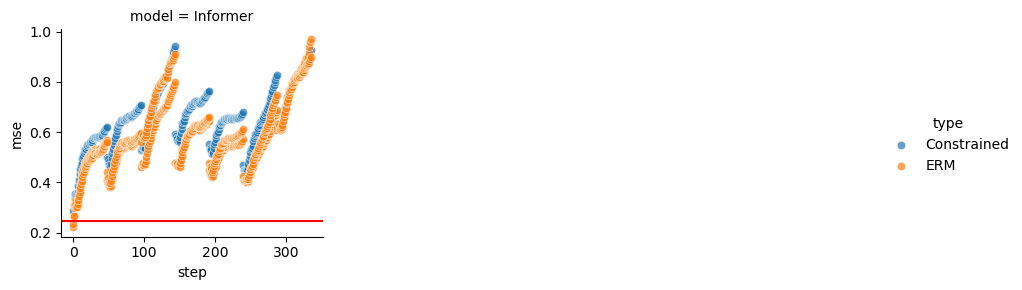

### Dataset: weather.csv pred_len: 336 constraint_level: 0.237

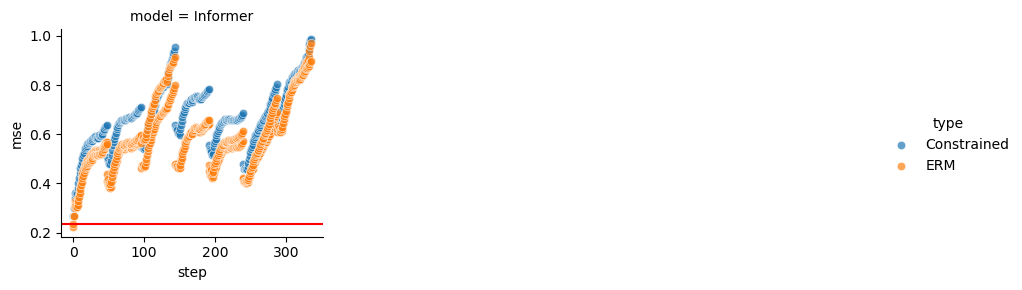

### Dataset: weather.csv pred_len: 336 constraint_level: 0.232

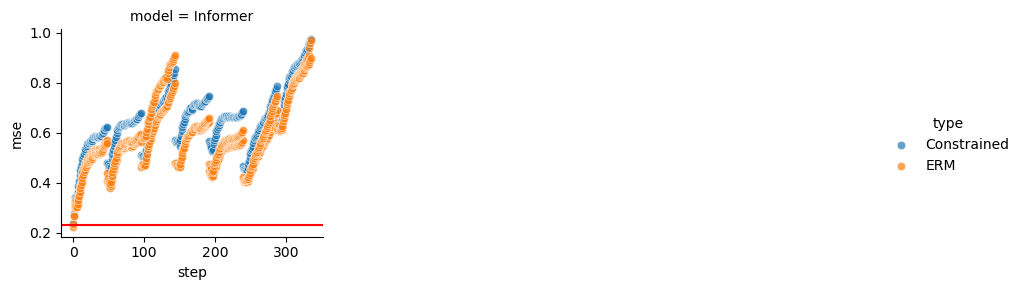

### Dataset: weather.csv pred_len: 336 constraint_level: 0.316

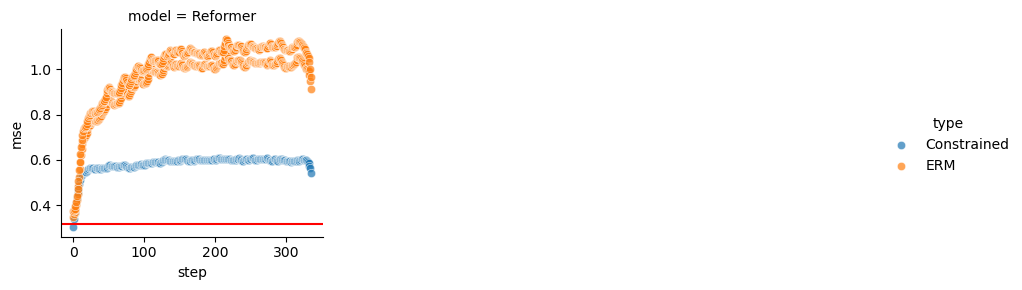

### Dataset: weather.csv pred_len: 336 constraint_level: 0.313

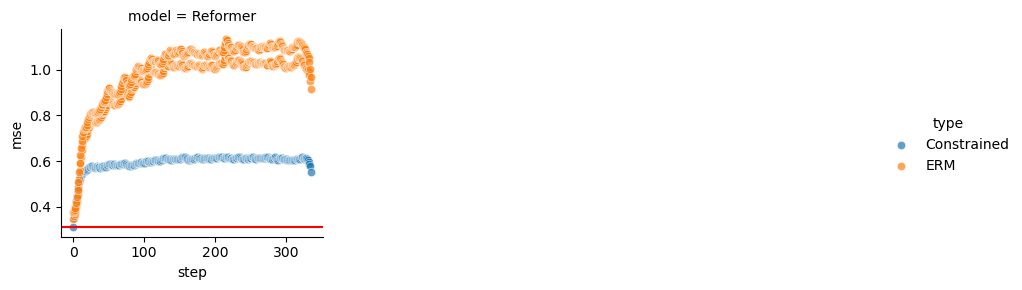

### Dataset: weather.csv pred_len: 336 constraint_level: 0.309

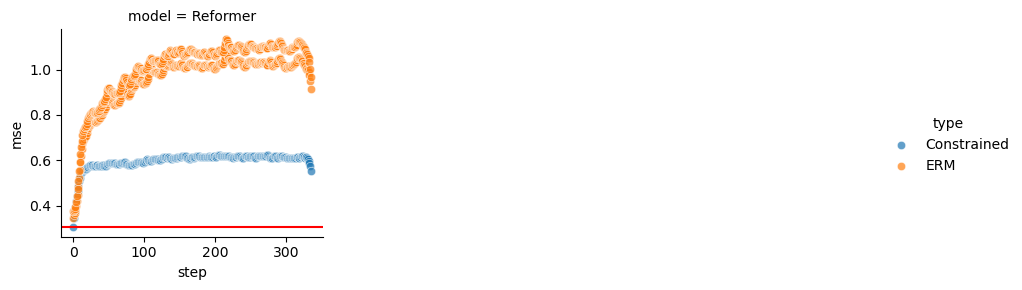

### Dataset: weather.csv pred_len: 336 constraint_level: 0.681

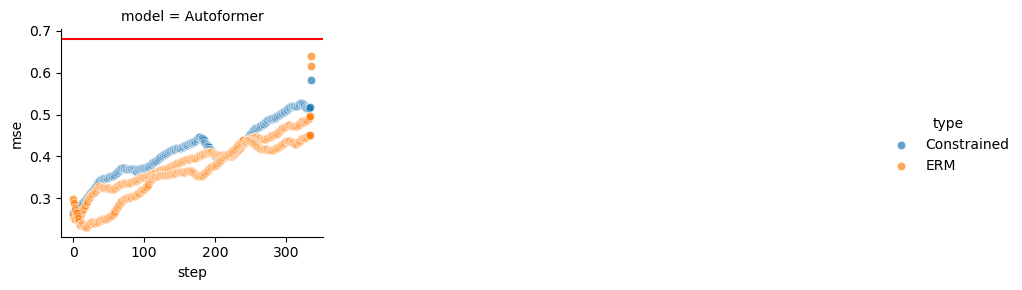

### Dataset: weather.csv pred_len: 336 constraint_level: 0.661

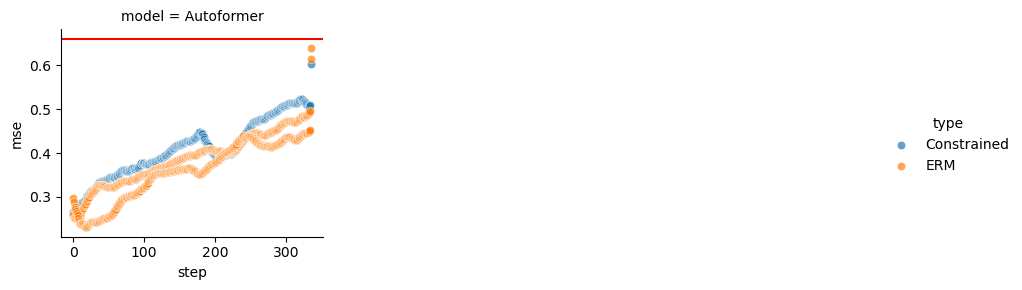

### Dataset: weather.csv pred_len: 336 constraint_level: 0.392

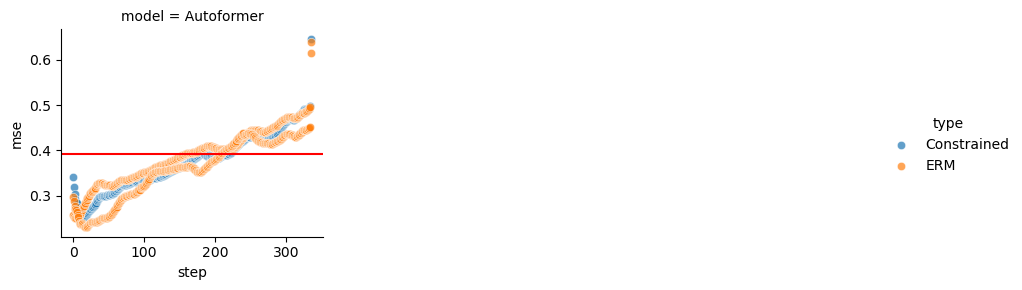

[0.216 0.215 0.213 0.26  0.249 0.245 0.283 0.282 0.281 0.759 0.732 0.67 ]


### Dataset: weather.csv pred_len: 720 constraint_level: 0.216

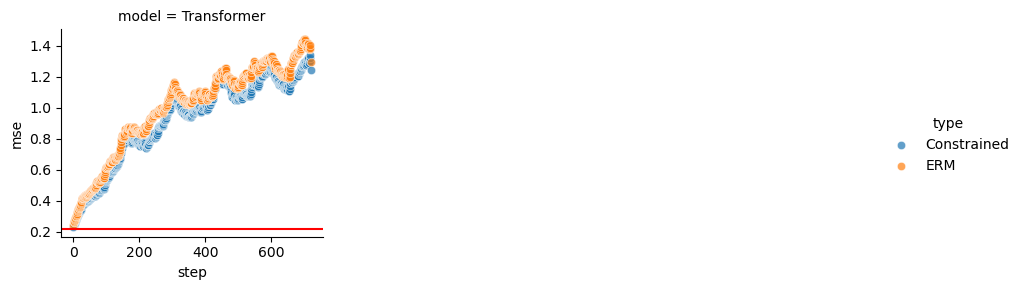

### Dataset: weather.csv pred_len: 720 constraint_level: 0.215

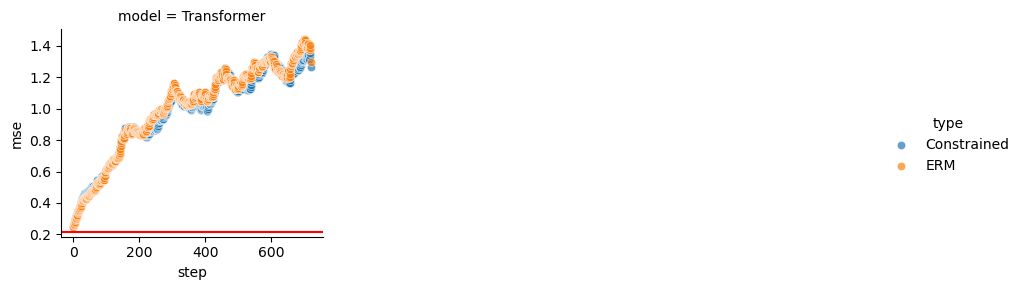

### Dataset: weather.csv pred_len: 720 constraint_level: 0.213

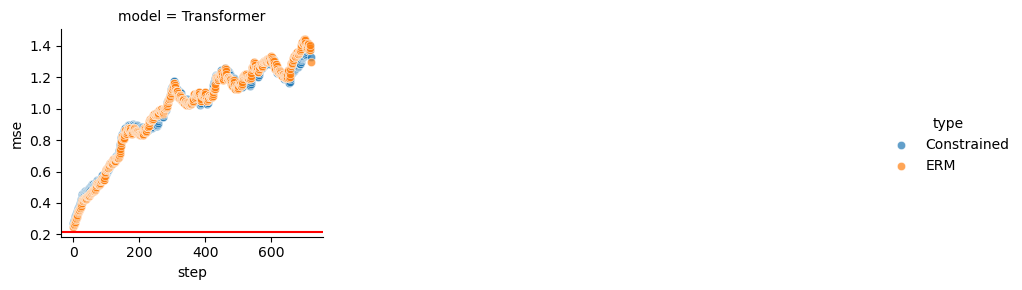

### Dataset: weather.csv pred_len: 720 constraint_level: 0.26

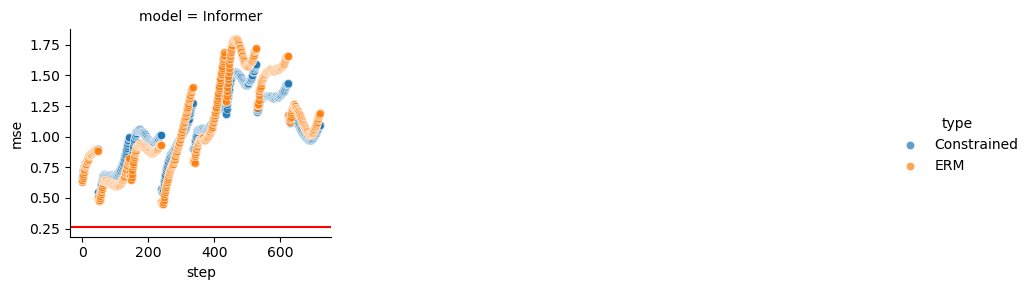

### Dataset: weather.csv pred_len: 720 constraint_level: 0.249

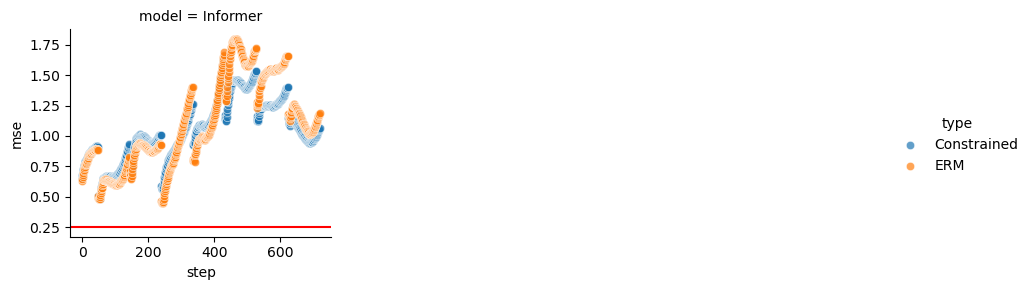

### Dataset: weather.csv pred_len: 720 constraint_level: 0.245

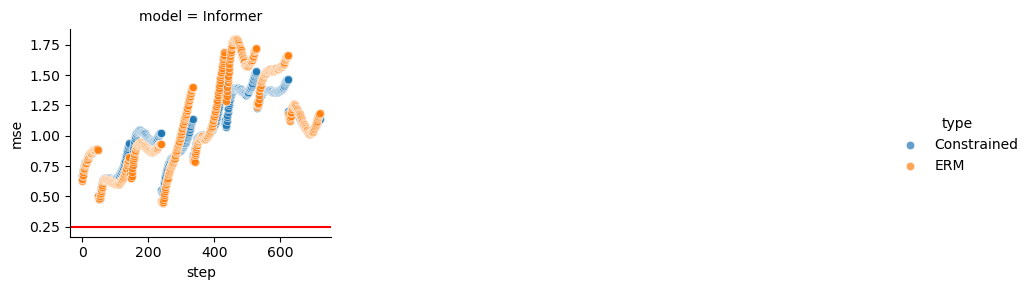

### Dataset: weather.csv pred_len: 720 constraint_level: 0.283

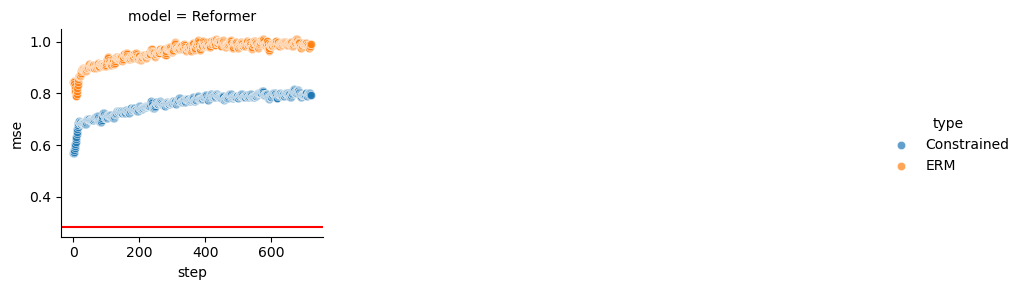

### Dataset: weather.csv pred_len: 720 constraint_level: 0.282

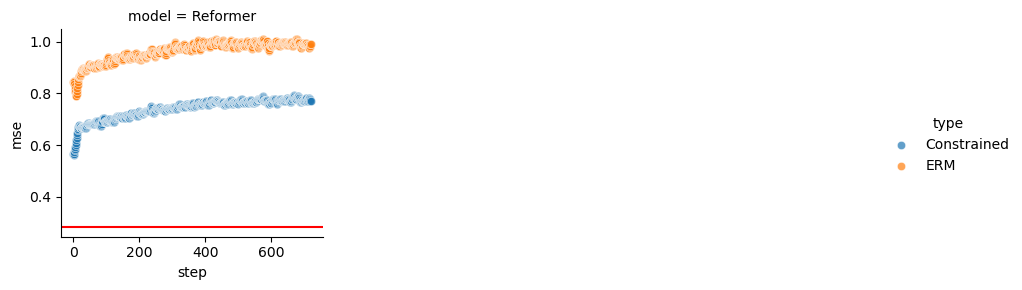

### Dataset: weather.csv pred_len: 720 constraint_level: 0.281

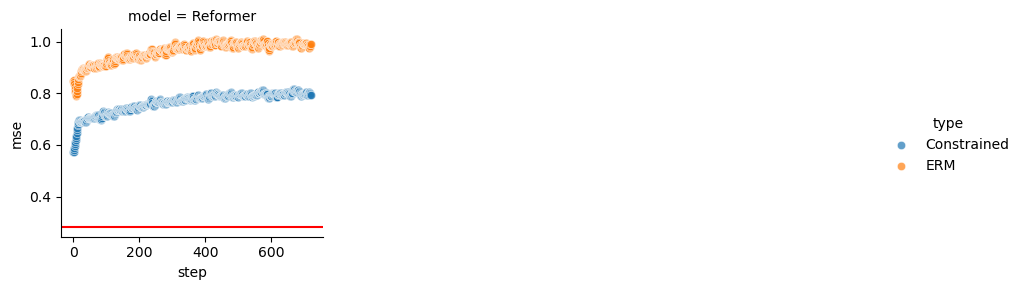

### Dataset: weather.csv pred_len: 720 constraint_level: 0.759

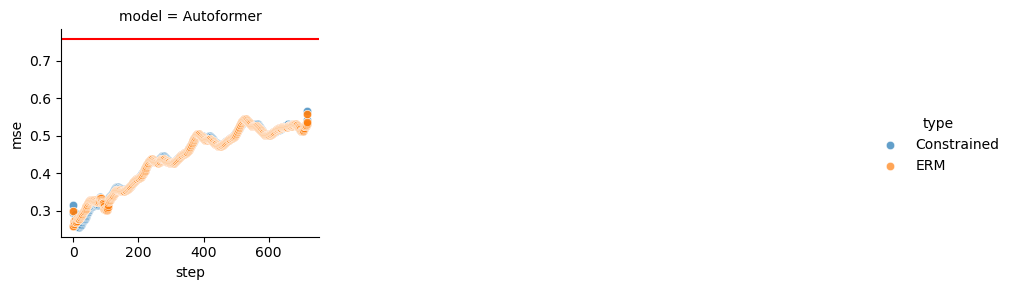

### Dataset: weather.csv pred_len: 720 constraint_level: 0.732

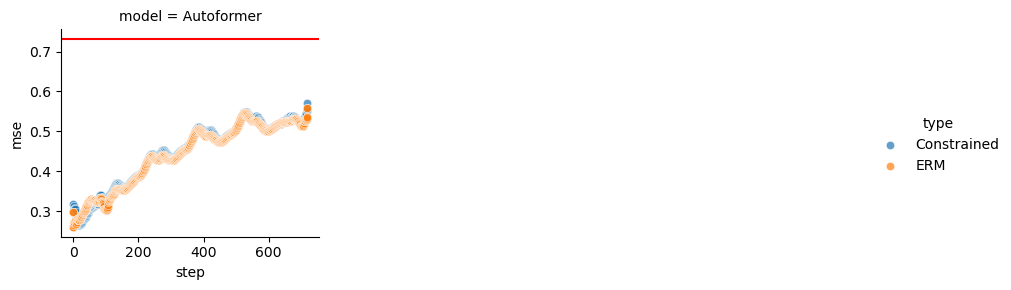

### Dataset: weather.csv pred_len: 720 constraint_level: 0.67

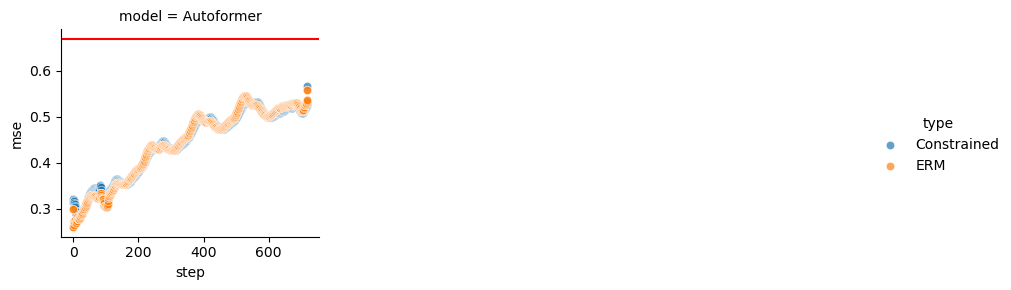

In [127]:
from IPython.display import display, Markdown
to_plot = df_to_plot[(df_to_plot.split=='test')].copy()
for (data_path,pred_len), series in to_plot.groupby(['data_path',"pred_len"]):
    constraints = series.constraint_level.unique()
    print(constraints)
    constraints = constraints[constraints!=-1] # to iterate over all constraints explored.
    for constraint_level in constraints:
        display(Markdown(f"### Dataset: {data_path} pred_len: {pred_len} constraint_level: {constraint_level}"))
        plot_series = series[series["constraint_level"]==constraint_level]
        
        #means_per_experiment = plot_series.groupby(['pred_len','constraint_level','Algorithm','model','epoch','type'])['mse'].mean().reset_index()
        #display(means_per_experiment)
        # do a pivot where model are the rows, and the columns constrained and unconstrained
        #display(means_per_experiment.pivot(index=['model'], columns='type', values='mse').reset_index())

        # sns.scatterplot(x="step", y="mse", hue="Algorithm",style="split", data=plot_series)
        
        # plt.axhline(y=constraint_level, color='r', linestyle='-')
        # plt.title(f"Pred Length: {pred_len}, Constraint_level: {constraint_level}")
        # plt.show()

        # This same scatterplot but in a grid by algorithm. 
        g = sns.FacetGrid(plot_series, col="model", hue="type",col_wrap=3)
        g.map(sns.scatterplot, "step", "mse", alpha=.7) 
        g.add_legend()
        # add the hline
        for ax in g.axes:
            ax.axhline(y=constraint_level, color='r', linestyle='-')
        plt.show()
        # export this plot to latex. Remove the dot in constraint_level decimal
        #TODO fix
        #g.savefig(f"{FIGURES_FOLDER}/constrained_vs_erm_{data_path.replace('.','')}_{pred_len}_{str(constraint_level).replace('.','')}.png")
        # Fix [Errno 2] No such file or directory: 'figures/electricity.csv_96_0.17_individual.png'


### ERM on multiple algorithms
As a front page chart to illustrate the problem

In [ ]:
#TODO ( I think Nacho already did this)

### Loss shaping single instance qualitative analysis

### Plotting dual variables

In [ ]:
df_to_plot[['run_id','pred_len','constraint_level','data_path','model','type']].drop_duplicates().query("data_path=='weather.csv' and model=='Reformer' and type=='Constrained'")

run_id  pred_len  constraint_level    data_path     model  \
68544  p9izzn2r        96             0.556  weather.csv  Reformer   
68832  b1adswkj        96             0.553  weather.csv  Reformer   
69120  dowv2wrc        96             0.516  weather.csv  Reformer   
69408  i7gx5ivx       192             0.665  weather.csv  Reformer   
69984  v4rwuch4       192             0.567  weather.csv  Reformer   
70560  mitm69y2       192             0.553  weather.csv  Reformer   
71136  chbkcq99       336             0.970  weather.csv  Reformer   
72144  749ywu49       336             0.741  weather.csv  Reformer   
73152  fe29o3il       336             0.682  weather.csv  Reformer   
74160  n1dluqy8       720             0.912  weather.csv  Reformer   
76320  ds6fdrqd       720             0.862  weather.csv  Reformer   
78480  f11og493       720             0.698  weather.csv  Reformer   

              type  
68544  Constrained  
68832  Constrained  
69120  Constrained  
69408  Constrained  
69984  Constrained  
70560  Constrained  
71136  Constrained  
72144  Constrained  
73152  Constrained  
74160  Constrained  
76320  Constrained  
78480  Constrained

In [ ]:
constrained_runs = df_to_plot.query('type=="Constrained"').copy()
# Sum the multilpiers, fill with 0
key_cols=['run_id','model','pred_len','constraint_level','data_path']
multiplier_sum=constrained_runs.groupby(key_cols)['multiplier'].sum().reset_index()

#TO DO: plot MSE 
# get test mse
test_mses=constrained_runs.query('split=="test"').groupby(key_cols)['mse'].mean().reset_index()
mult_vs_test_mse=multiplier_sum.merge(test_mses,on=key_cols)
#sns.scatterplot(x="multiplier", y="mse", hue="constraint_level",style="pred_len", data=mult_vs_test_mse)
#g = sns.FacetGrid(mult_vs_test_mse, col="model",row='data_path',style="pred_len")
# scatterplot with hue="constraint_level",style="pred_len"
#g.map(sns.scatterplot, "multiplier", "mse", alpha=.7,)#sns.scatterplot(**args,hue="constraint_level",style="pred_len",alpha=0.3)
#g.map(sns.scatterplot, "multiplier", "mse",alpha=.7)

In [ ]:
# #df_to_plot.query('split=="train" and pred_len==96').run_id.head(1)
# #mult_cols = [f"multiplier/{i}" for i in range(0,96)]
# # Plot for every constraint level in the 96 pred len window
# #for pred_len in df_to_plot.pred_len.unique():
# display(Markdown(f"# Multipliers for window of {pred_len}"))
# # sns.scatterplot(x="step", y="multiplier", hue="model",style="constraint_level", 
# #     data=df_to_plot.query(f"split=='train' and type=='Constrained' and pred_len=={96} and data_path=='weather.csv'"))
# # same plot, but grid with one plot per model
# dd = df_to_plot#df_to_plot.query("run_id=='6fgam2dx' and split=='train'")#.query(f"split=='train' and type=='Constrained' and pred_len==96 and data_path=='electricity.csv' and model=='Reformer' and constraint_level==0.157")
# dd_test = df_to_plot#df_to_plot.query("run_id=='6fgam2dx' and split=='test'")#.query(f"split=='test' and type=='Constrained' and pred_len==96 and data_path=='electricity.csv' and model=='Reformer' and constraint_level==0.157")

# #print(dd_test.constraint_level.unique())
# test_set_plus_multipliers = dd[['step','multiplier']].merge(dd_test[['step','split','mse']],on='step')

# unioned = pd.concat([dd[['step','split','multiplier','mse']],test_set_plus_multipliers[['step','split','multiplier','mse']]])

# display(unioned)


# display(test_set_plus_multipliers)

# #constraint_level==0.553
# # mult on x, mse@train and mse@test on y. hue=split
# # Add step over every point
# sns.scatterplot(unioned,x="multiplier", y="mse",hue='split', alpha=.3,legend='full')



# g = sns.FacetGrid(dd, col="model", row="constraint_level")
# g.map(sns.scatterplot, "step", "multiplier", alpha=.3)
# #g.map(sns.scatterplot, "step", "mse", alpha=.3)

# Multipliers for window of 720

step  split  multiplier       mse
16128        0  train    2.801533  0.209369
16129        1  train    1.050123  0.204042
16130        2  train    0.269966  0.194581
16131        3  train    0.000000  0.189056
16132        4  train    0.000000  0.187635
...        ...    ...         ...       ...
17418235   719   test         NaN  1.910884
17418236   719   test         NaN  1.910884
17418237   719    val         NaN  1.909591
17418238   719    val         NaN  1.909591
17418239   719    val         NaN  1.909591

[17515008 rows x 4 columns]

step  multiplier  split       mse
0            0    2.801533  train  0.209369
1            0    2.801533   test  0.268508
2            0    2.801533    val  0.266284
3            0    2.801533  train  0.215619
4            0    2.801533   test  0.247226
...        ...         ...    ...       ...
17418235   719         NaN   test  1.910884
17418236   719         NaN   test  1.910884
17418237   719         NaN    val  1.909591
17418238   719         NaN    val  1.909591
17418239   719         NaN    val  1.909591

[17418240 rows x 4 columns]

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fedbc19fa70> (for post_execute):


KeyboardInterrupt: 

/home/jporras/miniconda3/envs/autoformer/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Error in callback <function flush_figures at 0x7fedbc19f4d0> (for post_execute):


KeyboardInterrupt: 

### More random explorations
Ideas: 
1. Loss over time
2. Infeasibility rate over time
3. Loss shape across epochs (see how it evolves)
4. Plotting dual variables

## Result tables
1. Reproduce the pivot table from notebook 11, perhaps add standard deviation reports.
2. Explore and find other interesting table visualziation

Algorithm       model  \
0    Electricity-StatInformed-10e-Constrained Autof...  Autoformer   
1    Electricity-StatInformed-10e-Constrained Autof...  Autoformer   
2    Electricity-StatInformed-10e-Constrained Autof...  Autoformer   
3    Electricity-StatInformed-10e-Constrained Autof...  Autoformer   
4    Electricity-StatInformed-10e-Constrained Autof...  Autoformer   
..                                                 ...         ...   
283                      StatInformed-ERM-10e Reformer    Reformer   
284                      StatInformed-ERM-10e Reformer    Reformer   
285                      StatInformed-ERM-10e Reformer    Reformer   
286                      StatInformed-ERM-10e Reformer    Reformer   
287                      StatInformed-ERM-10e Reformer    Reformer   

            type  constraint_level  pred_len        data_path  split  \
0    Constrained             0.157        96  electricity.csv   test   
1    Constrained             0.157        96  electricity.csv  train   
2    Constrained             0.157        96  electricity.csv    val   
3    Constrained             0.169        96  electricity.csv   test   
4    Constrained             0.169        96  electricity.csv  train   
..           ...               ...       ...              ...    ...   
283          ERM             0.912       720      weather.csv  train   
284          ERM             0.912       720      weather.csv    val   
285          ERM             0.970       336      weather.csv   test   
286          ERM             0.970       336      weather.csv  train   
287          ERM             0.970       336      weather.csv    val   

          mse   std_mse       mcv   std_mcv  run_count  
0    0.161314  0.008300  0.005958  0.006300          3  
1    0.122875  0.008124  0.000137  0.001351          3  
2    0.161379  0.008284  0.006002  0.006303          3  
3    0.175690  0.021071  0.011387  0.017147          3  
4    0.127490  0.007203  0.000018  0.000296          3  
..        ...       ...       ...       ...        ...  
283  0.284454  0.003977  0.000000  0.000000          3  
284  0.868256  0.071528  0.014379  0.025065          3  
285  0.769636  0.090134  0.000000  0.000000          3  
286  0.317969  0.010492  0.000000  0.000000          3  
287  0.769972  0.090315  0.000000  0.000000          3  

[288 rows x 12 columns]

In [77]:
#Note, variance is nan because there is only one run per parameter set
weather = summary_metrics.query('data_path=="weather.csv"').copy()
electricity = summary_metrics.query('data_path=="electricity.csv"').copy()
for name,dataset in [('weather',weather), ('electricity',electricity)]:
    display(Markdown(f"# {name}"))
    tp2=dataset.copy(deep=True)
    #tp2=weather.query('split=="test"').copy()
    # Compute 'infeasible amount' as the difference between the mse and the constraint_level, 0 if mse < constraint
    #tp2['mean_violation']=tp2.apply(lambda x: max(0,x['mse']-x['constraint_level']),axis=1)
    
    # Split into constrained and ERM
    tp2_constrained=tp2.query('type=="Constrained"').copy()
    tp2_erm_baseline=tp2.query('type=="ERM"').copy()

    distinct_constraints = tp2_constrained[['pred_len','model','constraint_level']].drop_duplicates()

    # crossjoin the ERM mse to all constraint levels
    #tp2_erm_baseline_broadcasted = tp2_erm_baseline.drop(columns=['constraint_level']).merge(distinct_constraints,on=['pred_len','model'],how='left')

    #display(tp2_erm_baseline_broadcasted[['type','model','constraint_level','mse']].head())

    # concat back together to compute mean_violation
    #tp2=pd.concat([tp2_constrained,tp2_erm_baseline_broadcasted],axis=0)

    #tp2['mean_violation']=tp2.apply(lambda x: max(0,x['mse']-x['constraint_level']),axis=1)

    # Sanity check show the mean_violation for the ERM runs
    #display(tp2.query('type=="ERM"')[['type','model','constraint_level','mse','mean_violation']].head())


    #GROUPING TEH VALS
    grouped_values=tp2.groupby(['pred_len','constraint_level','model','type'])[[
        'mse','mcv',
        'std_mse','std_mcv',
        'mean_infeasible_rate','std_infeasible_rate']].mean().reset_index()
    #grouped_constrained = grouped_values[grouped_values.type=='Constrained'].copy()
    #grouped_erm_baseline=grouped_values[grouped_values.type=='ERM'].copy()

    # best_constraints is the constraint for each model and pred_len that minimizes mean_violation. show min and argmin
    #best_constraints_per_window = grouped_values.query('type=="Constrained"').groupby(['pred_len']).apply(lambda x: x.loc[x['mean_violation'].idxmin()]).reset_index(drop=True)[['pred_len','type','constraint_level','mean_violation','mse']]
    # instead of best constraints, show all constraint levels.

    # join best_constraints and grouped_values to get the mse and mean_violation for the best constraint
    #best_constrained=grouped_values.merge(best_constraints_per_window[['pred_len','constraint_level']],on=['pred_len','constraint_level'],how='inner')


    # crossjoin the ERM mse to all constraint levels
    ##grouped_erm_baseline_broadcasted = grouped_erm_baseline.drop(columns=['constraint_level']).merge(grouped_constrained[['pred_len','model','constraint_level']].drop_duplicates(),on=['pred_len','model'],how='left')

    # Pivot of models versus constrained and ERM, values are mse and mse_diff
    all_results = grouped_values#pd.concat([grouped_constrained,grouped_erm_baseline_broadcasted],axis=0)
    # Pivot all results, sort ascending by pred_len, then mean_violation on constrained

    pivoted=all_results.pivot(
        index=['pred_len','constraint_level'], 
        columns=['type','model'], 
        values=['mse','std_mse','mcv','std_mcv','mean_infeasible_rate','std_infeasible_rate']
    ).query('constraint_level>0').round(4)
    simplified = all_results.pivot(
        index=['pred_len','constraint_level'],
        columns=['type','model'],
        values=['mse','mcv']
    )
    pd.set_option('display.max_columns', None)
    print("SIMPLIFIED 192 MSE")
    # show all pred lengths (index)
    for pred_len in [96, 192, 336, 720]:            
        print(simplified.index.get_level_values(0).unique())
        simp_mse_192=simplified[simplified.index.get_level_values(0)==pred_len][['mse']]
        sim_mcv_192=simplified[simplified.index.get_level_values(0)==pred_len][['mcv']]

        # Flatten the multiindex
        def prettify(d):
            d = d.copy()
            d.columns = d.columns.map('_'.join)
            return d.style.format(precision=3)
        # display(prettify(simp_mse_192))
        print(f"SIMPLIFIED {pred_len} MCV")
        display(prettify(sim_mcv_192))
    print("FULL")
    display(pivoted)
    #reformer works best on weather.

# weather

SIMPLIFIED 192 MSE
Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 96 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 192 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 336 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 720 MCV


FULL


mse                                  \
type                      Constrained        ERM Constrained      ERM   
model                      Autoformer Autoformer    Reformer Reformer   
pred_len constraint_level                                               
96       0.516                 0.4787     0.4482      0.4345   0.4380   
         0.553                 0.4756     0.4482      0.4377   0.4380   
         0.556                 0.4748     0.4482      0.4380   0.4380   
192      0.553                 0.6139     0.5941      0.4737   0.4877   
         0.567                 0.5868     0.5941      0.4767   0.4877   
         0.665                 0.5952     0.5941      0.5055   0.4877   
336      0.682                 0.7118     0.6704      0.5596   0.6312   
         0.741                 0.6518     0.6704      0.5794   0.6312   
         0.970                 0.6572     0.6704      0.6335   0.6312   
720      0.698                 0.7879     0.7840      0.7066   0.6350   
         0.862                 0.7923     0.7840      0.7185   0.6350   
         0.912                 0.7926     0.7840      0.7234   0.6350   

                              std_mse                                  \
type                      Constrained        ERM Constrained      ERM   
model                      Autoformer Autoformer    Reformer Reformer   
pred_len constraint_level                                               
96       0.516                    NaN        NaN         NaN      NaN   
         0.553                    NaN        NaN         NaN      NaN   
         0.556                    NaN        NaN         NaN      NaN   
192      0.553                    NaN        NaN         NaN      NaN   
         0.567                    NaN        NaN         NaN      NaN   
         0.665                    NaN        NaN         NaN      NaN   
336      0.682                    NaN        NaN         NaN      NaN   
         0.741                    NaN        NaN         NaN      NaN   
         0.970                    NaN        NaN         NaN      NaN   
720      0.698                    NaN        NaN         NaN      NaN   
         0.862                    NaN        NaN         NaN      NaN   
         0.912                    NaN        NaN         NaN      NaN   

                                  mcv                                  \
type                      Constrained        ERM Constrained      ERM   
model                      Autoformer Autoformer    Reformer Reformer   
pred_len constraint_level                                               
96       0.516                 0.0171     0.0089      0.0086   0.0231   
         0.553                 0.0007     0.0006      0.0021   0.0089   
         0.556                 0.0001     0.0005      0.0018   0.0079   
192      0.553                 0.0681     0.0748      0.0071   0.0296   
         0.567                 0.0420     0.0642      0.0054   0.0227   
         0.665                 0.0018     0.0190      0.0004   0.0000   
336      0.682                 0.0420     0.0424      0.0052   0.0779   
         0.741                 0.0109     0.0165      0.0022   0.0436   
         0.970                 0.0000     0.0000      0.0000   0.0000   
720      0.698                 0.0980     0.1171      0.1006   0.0757   
         0.862                 0.0242     0.0212      0.0279   0.0000   
         0.912                 0.0116     0.0069      0.0116   0.0000   

                              std_mcv                                  \
type                      Constrained        ERM Constrained      ERM   
model                      Autoformer Autoformer    Reformer Reformer   
pred_len constraint_level                                               
96       0.516                    NaN        NaN         NaN      NaN   
         0.553                    NaN        NaN         NaN      NaN   
         0.556                    NaN        NaN         NaN      NaN   
192      0.553  

# electricity

SIMPLIFIED 192 MSE
Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 96 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 192 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 336 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 720 MCV


FULL


mse                                  \
type                      Constrained        ERM Constrained      ERM   
model                      Autoformer Autoformer    Reformer Reformer   
pred_len constraint_level                                               
96       0.157                 0.1507     0.1400      0.1824   0.1881   
         0.169                 0.1541     0.1400      0.1832   0.1881   
         0.170                 0.1520     0.1400      0.1833   0.1881   
192      0.173                 0.1763     0.1827      0.2074   0.2150   
         0.184                 0.1742     0.1827      0.2086   0.2150   
         0.200                 0.1798     0.1827      0.2108   0.2150   
336      0.232                 0.1849     0.1832      0.2163   0.2112   
         0.245                 0.1869     0.1832      0.2177   0.2112   
         0.256                 0.1851     0.1832      0.2192   0.2112   
720      0.215                 0.2379     0.2235      0.2284   0.2250   
         0.230                 0.2400     0.2235      0.2295   0.2250   
         0.246                 0.2241     0.2235      0.2325   0.2250   

                              std_mse                                  \
type                      Constrained        ERM Constrained      ERM   
model                      Autoformer Autoformer    Reformer Reformer   
pred_len constraint_level                                               
96       0.157                    NaN        NaN         NaN      NaN   
         0.169                    NaN        NaN         NaN      NaN   
         0.170                    NaN        NaN         NaN      NaN   
192      0.173                    NaN        NaN         NaN      NaN   
         0.184                    NaN        NaN         NaN      NaN   
         0.200                    NaN        NaN         NaN      NaN   
336      0.232                    NaN        NaN         NaN      NaN   
         0.245                    NaN        NaN         NaN      NaN   
         0.256                    NaN        NaN         NaN      NaN   
720      0.215                    NaN        NaN         NaN      NaN   
         0.230                    NaN        NaN         NaN      NaN   
         0.246                    NaN        NaN         NaN      NaN   

                                  mcv                                  \
type                      Constrained        ERM Constrained      ERM   
model                      Autoformer Autoformer    Reformer Reformer   
pred_len constraint_level                                               
96       0.157                 0.0047     0.0012      0.0289   0.0328   
         0.169                 0.0013     0.0004      0.0212   0.0247   
         0.170                 0.0009     0.0004      0.0206   0.0240   
192      0.173                 0.0126     0.0180      0.0400   0.0463   
         0.184                 0.0044     0.0105      0.0334   0.0390   
         0.200                 0.0037     0.0033      0.0243   0.0283   
336      0.232                 0.0001     0.0003      0.0073   0.0048   
         0.245                 0.0000     0.0002      0.0031   0.0016   
         0.256                 0.0000     0.0001      0.0009   0.0002   
720      0.215                 0.0335     0.0210      0.0253   0.0239   
         0.230                 0.0246     0.0135      0.0158   0.0139   
         0.246                 0.0031     0.0084      0.0070   0.0033   

                              std_mcv                                  \
type                      Constrained        ERM Constrained      ERM   
model                      Autoformer Autoformer    Reformer Reformer   
pred_len constraint_level                                               
96       0.157                    NaN        NaN         NaN      NaN   
         0.169                    NaN        NaN         NaN      NaN   
         0.170                    NaN        NaN         NaN      NaN   
192      0.173  

## Pivots per dataset